Best-fit bias for M_c=0.100: b = 1.442
Best-fit bias for M_c=10.000: b = 1.518
Best-fit bias for M_c=115.000: b = 1.526
Best-fit bias for M_c=290.000: b = 1.527
Best-fit bias for M_c=500.000: b = 1.558


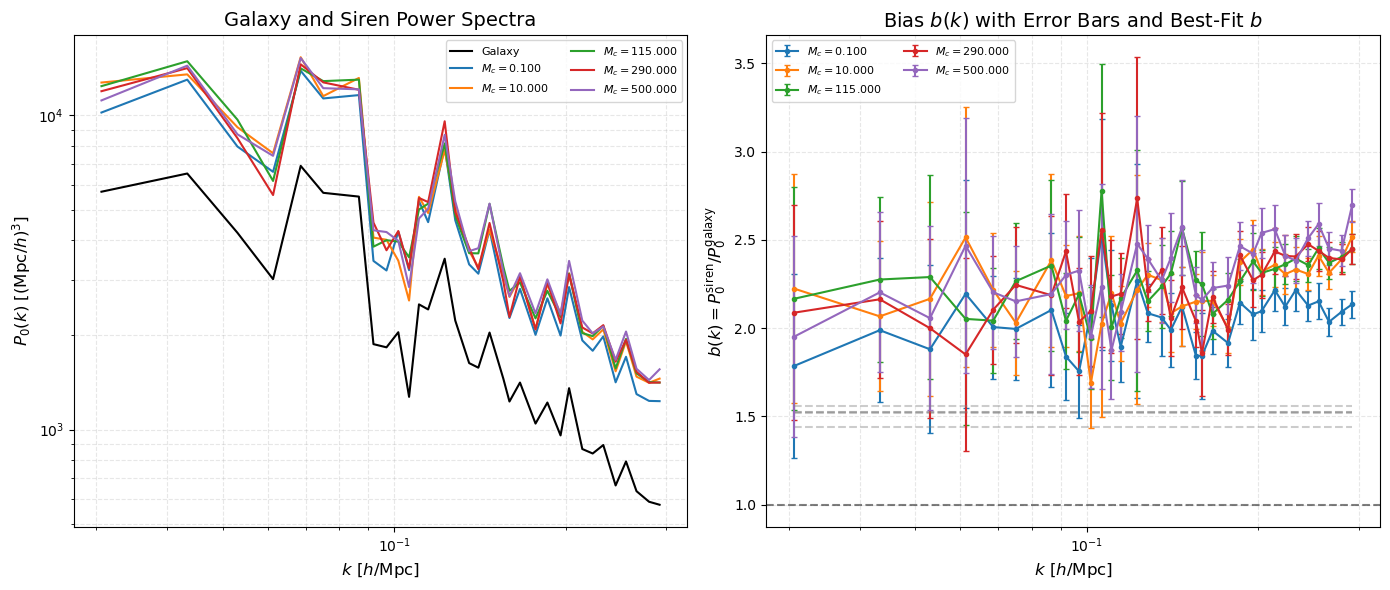

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower
import os

# --- Parameters ---
boxsize = 205001.0 / 1000  # Mpc/h
nmesh = 256
kedges = np.logspace(np.log10(0.03), np.log10(0.3), 51)

Mc_values = [
    0.100, 10.000, 115.000, 290.000, 500.000
]

siren_dir = "/gpfs/nchugh/gw"
galaxy_path = "/gpfs/nchugh/gw/processed_galaxies.pkl"  # ← Replace this

# --- Function to compute P(k) ---
def compute_power_spectrum(df, boxsize, nmesh=256, kedges=None):
    x = df['x'].values / 1000
    y = df['y'].values / 1000
    z = df['z_pos'].values / 1000
    positions = np.vstack([x, y, z]).T.astype('f8')

    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',
        interlacing=2,
        los=None,
        position_type='pos',
    )

    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)

    return k, P0, shotnoise, P0_error

# --- Load galaxy catalog ---
with open(galaxy_path, 'rb') as f:
    galaxies = pickle.load(f)

k_gal, P0_gal, shot_gal, err_gal = compute_power_spectrum(galaxies, boxsize, nmesh, kedges)
P0_gal_corr = P0_gal - shot_gal
valid_gal = (P0_gal_corr > 0) & np.isfinite(P0_gal_corr)
k_gal_valid = k_gal[valid_gal]
P0_gal_valid = P0_gal_corr[valid_gal]

# --- Setup plots ---
plt.figure(figsize=(14, 6))

# Power spectrum plot
plt.subplot(1, 2, 1)
plt.plot(k_gal_valid, P0_gal_valid, 'k-', label='Galaxy')

# Bias plot
plt.subplot(1, 2, 2)
plt.axhline(1, color='k', ls='--', alpha=0.5)

# --- Process each siren catalog ---
for Mc in Mc_values:
    fname = f"siren_cat_M_c_{Mc:.3f}.pkl"
    path = os.path.join(siren_dir, fname)

    try:
        with open(path, 'rb') as f:
            siren_catalog = pickle.load(f)

        k_sir, P0_sir, shot_sir, err_sir = compute_power_spectrum(siren_catalog, boxsize, nmesh, kedges)
        P0_sir_corr = P0_sir - shot_sir

        valid = (P0_sir_corr > 0) & np.isfinite(P0_sir_corr)
        k_valid = k_sir[valid]
        P0_siren_valid = P0_sir_corr[valid]
        err_siren_valid = err_sir[valid]

        # Interpolate galaxy P(k) to siren k
        P0_gal_interp = np.interp(k_valid, k_gal_valid, P0_gal_valid)

        # --- Bias & error ---
        bias = P0_siren_valid / P0_gal_interp
        bias_err = err_siren_valid / P0_gal_interp

        # --- Best-fit bias via chi^2 ---
        numerator = np.sum((P0_siren_valid * P0_gal_interp) / err_siren_valid**2)
        denominator = np.sum((P0_gal_interp**2) / err_siren_valid**2)
        b_squared = numerator / denominator
        b_fit = np.sqrt(b_squared)

        print(f"Best-fit bias for M_{\kappa}={Mc:.3f}: b = {b_fit:.3f}")

        # --- Plot power spectrum ---
        plt.subplot(1, 2, 1)
        plt.plot(k_valid, P0_siren_valid, label=fr'$M_{\kappa}={Mc:.3f}$')

        # --- Plot bias with error bars ---
        plt.subplot(1, 2, 2)
        plt.errorbar(k_valid, bias, yerr=bias_err, fmt='-o', ms=3, capsize=2, label=fr'$M_c={Mc:.3f}$')
        plt.hlines(b_fit, k_valid.min(), k_valid.max(),
                   colors='gray', linestyles='dashed', alpha=0.4)

    except FileNotFoundError:
        print(f"[Missing] {path}")
    except Exception as e:
        print(f"[Error] {path} — {e}")

# --- Finalize plots ---
# Power spectrum
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=12)
plt.ylabel(r'$P_0(k)\ [(\mathrm{Mpc}/h)^3]$', fontsize=12)
plt.title('Galaxy and Siren Power Spectra', fontsize=14)
plt.legend(fontsize=8, ncol=2)
plt.grid(True, which='both', ls='--', alpha=0.3)

# Bias
plt.subplot(1, 2, 2)
plt.xscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=12)
plt.ylabel(r'$b(k) = P_0^{\rm siren} / P_0^{\rm galaxy}$', fontsize=12)
plt.title('Bias $b(k)$ with Error Bars and Best-Fit $b$', fontsize=14)
plt.legend(fontsize=8, ncol=2)
plt.grid(True, which='both', ls='--', alpha=0.3)

plt.tight_layout()
plt.show()


Number of objects after mass cut: 217360
Computing power spectrum with PYPOWER...
Computing power spectrum with Pk_library...

Computing power spectrum of the field...
Time to complete loop = 0.78
Time taken = 1.01 seconds
Shot noise level: 3.96e+01
Number density: 2.52e-02 (Mpc/h)^-3


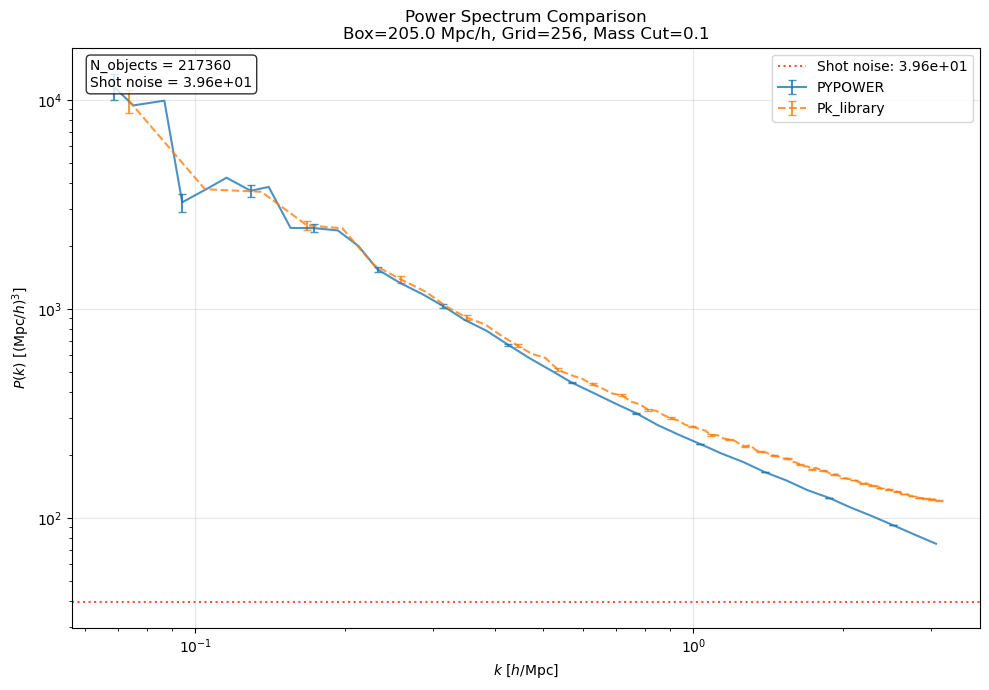

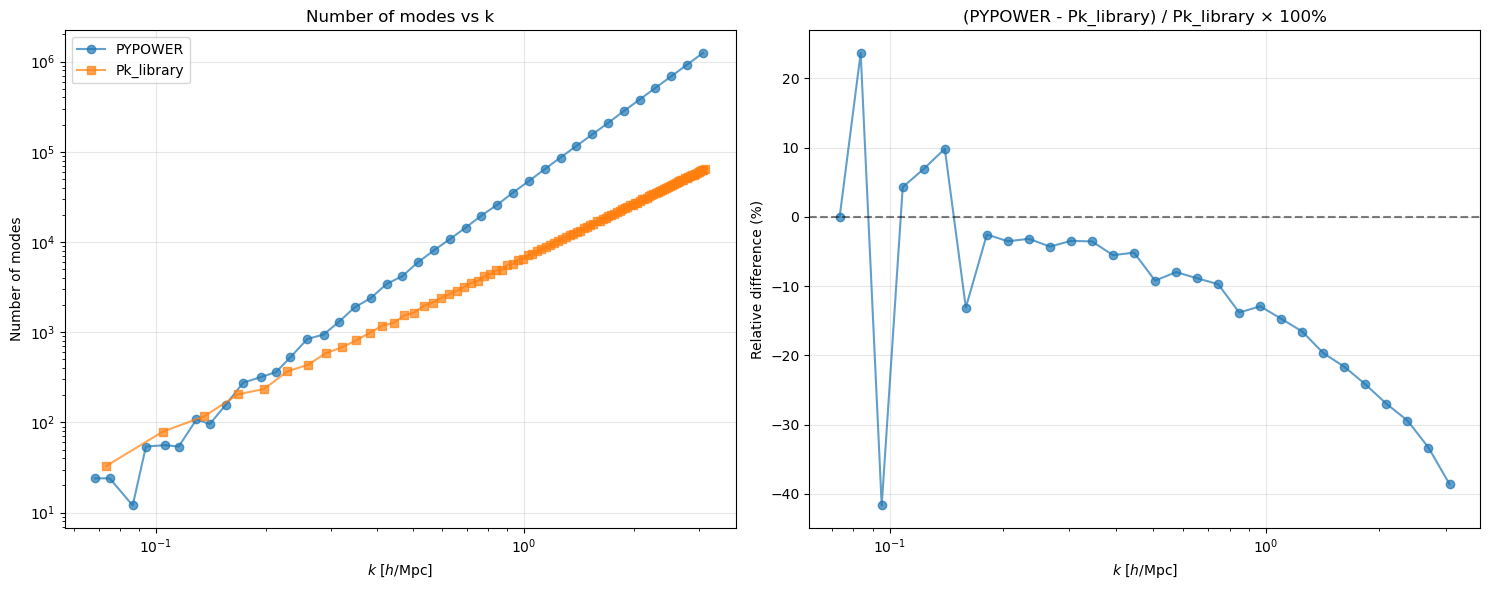


--- Diagnostics ---
k range (PYPOWER): 0.0685 - 3.0716 h/Mpc
k range (Pk_library): 0.0736 - 3.1107 h/Mpc
Fundamental frequency: 0.0306 h/Mpc
Nyquist frequency: 3.9232 h/Mpc
Mean relative difference: 13.94%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
from pypower import CatalogFFTPower

# Parameters
grid = 256
BoxSize = 205.0  # Mpc/h
MAS = 'CIC'
mass_cut = 0.1
snap = 50  # Snapshot number, adjust as needed
# Load galaxy catalog and apply mass cut
df = pd.read_pickle(f'/gpfs/nchugh/groupcat/subhalos_snap_{snap}.pkl')
df = df[df['SubhaloMassStars'] > mass_cut]

print(f"Number of objects after mass cut: {len(df)}")

# ---------- 1. Power Spectrum using PYPOWER ----------
def compute_power_spectrum_PYPOWER(df, boxsize, nmesh=256, kedges=None):
    """Compute power spectrum using PYPOWER with better k-binning"""
    x = df['x'].values / 1000  # convert from kpc/h to Mpc/h
    y = df['y'].values / 1000
    z = df['SubhaloPos_2'].values / 1000
    positions = np.vstack([x, y, z]).T.astype('f8')
    
    # Define k-edges if not provided - use log spacing for better binning
    if kedges is None:
        kmin = 2 * np.pi / boxsize  # fundamental frequency
        kmax = np.pi * nmesh / boxsize  # Nyquist frequency
        kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    
    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',  # Changed from 'tsc' to match MAS='CIC' if needed
        interlacing=2,
        los=None,
        position_type='pos',
    )
    
    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)
    
    return k, P0, shotnoise, P0_error, nmodes

# ---------- 2. Load density field with MAS_library ----------
def load_density_field_MASL(df, grid, boxsize, MAS):
    """Load density field using MAS_library"""
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    x = df['x'].values / 1000
    y = df['SubhaloPos_1'].values / 1000
    z = df['SubhaloPos_2'].values / 1000
    positions = np.vstack([x, y, z]).T.astype(np.float32)
   
    MASL.MA(positions, delta, boxsize, MAS)
    
    # Proper normalization
    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        print("Warning: Mean density is zero or negative!")
    
    return delta

# ---------- 3. Compute power spectrum with Pk_library ----------
def compute_power_spectrum_PKL(delta, boxsize, MAS, axis=0):
    """Compute power spectrum using Pk_library"""
    Pk = PKL.Pk(delta, boxsize, axis, MAS, threads=1)
    
    # Calculate error bars from number of modes
    P0_error = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D, P0_error

# ---------- 4. Run both and compare ----------
print("Computing power spectrum with PYPOWER...")
k_py, P0_py, shot_py, err_py, nmodes_py = compute_power_spectrum_PYPOWER(df, BoxSize, nmesh=grid)

print("Computing power spectrum with Pk_library...")
delta = load_density_field_MASL(df, grid, BoxSize, MAS)
k_pkl, P0_pkl, Nmodes_pkl, err_pkl = compute_power_spectrum_PKL(delta, BoxSize, MAS)

# Apply k-range cuts to avoid problematic regions
kmin_cut = 2 * np.pi / BoxSize * 2  # Avoid fundamental mode issues
kmax_cut = np.pi * grid / BoxSize * 0.8  # Avoid Nyquist frequency issues

# Filter PYPOWER data
mask_py = (k_py > kmin_cut) & (k_py < kmax_cut)
k_py_cut = k_py[mask_py]
P0_py_cut = P0_py[mask_py]
err_py_cut = err_py[mask_py]
nmodes_py_cut = nmodes_py[mask_py]

# Filter Pk_library data
mask_pkl = (k_pkl > kmin_cut) & (k_pkl < kmax_cut)
k_pkl_cut = k_pkl[mask_pkl]
P0_pkl_cut = P0_pkl[mask_pkl]
err_pkl_cut = err_pkl[mask_pkl]
Nmodes_pkl_cut = Nmodes_pkl[mask_pkl]

print(f"Shot noise level: {shot_py:.2e}")
print(f"Number density: {len(df) / BoxSize**3:.2e} (Mpc/h)^-3")

# ---------- 5. Improved Plot ----------
plt.figure(figsize=(10, 7))

# Plot with error bars
plt.errorbar(k_py_cut, P0_py_cut, yerr=err_py_cut, 
             label='PYPOWER', alpha=0.8, capsize=3, errorevery=3)
plt.errorbar(k_pkl_cut, P0_pkl_cut, yerr=err_pkl_cut, 
             label='Pk_library', alpha=0.8, capsize=3, errorevery=3, linestyle='dashed')

# Add shot noise level as reference
plt.axhline(shot_py, color='red', linestyle=':', alpha=0.7, 
            label=f'Shot noise: {shot_py:.2e}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.legend()
plt.title(f'Power Spectrum Comparison\nBox={BoxSize} Mpc/h, Grid={grid}, Mass Cut={mass_cut}')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add text with key statistics
plt.text(0.02, 0.98, f'N_objects = {len(df)}\nShot noise = {shot_py:.2e}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# ---------- 6. Diagnostic plots ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Number of modes
ax1.loglog(k_py_cut, nmodes_py_cut, 'o-', label='PYPOWER', alpha=0.7)
ax1.loglog(k_pkl_cut, Nmodes_pkl_cut, 's-', label='Pk_library', alpha=0.7)
ax1.set_xlabel(r'$k$ [$h$/Mpc]')
ax1.set_ylabel('Number of modes')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Number of modes vs k')

# Plot 2: Relative difference
# Interpolate to common k values for comparison
k_common = np.logspace(np.log10(max(k_py_cut.min(), k_pkl_cut.min())), 
                      np.log10(min(k_py_cut.max(), k_pkl_cut.max())), 30)
P_py_interp = np.interp(k_common, k_py_cut, P0_py_cut)
P_pkl_interp = np.interp(k_common, k_pkl_cut, P0_pkl_cut)

relative_diff = (P_py_interp - P_pkl_interp) / P_pkl_interp * 100
ax2.semilogx(k_common, relative_diff, 'o-', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'$k$ [$h$/Mpc]')
ax2.set_ylabel('Relative difference (%)')
ax2.grid(True, alpha=0.3)
ax2.set_title('(PYPOWER - Pk_library) / Pk_library × 100%')

plt.tight_layout()
plt.show()

# Print some diagnostics
print("\n--- Diagnostics ---")
print(f"k range (PYPOWER): {k_py_cut.min():.4f} - {k_py_cut.max():.4f} h/Mpc")
print(f"k range (Pk_library): {k_pkl_cut.min():.4f} - {k_pkl_cut.max():.4f} h/Mpc")
print(f"Fundamental frequency: {2 * np.pi / BoxSize:.4f} h/Mpc")
print(f"Nyquist frequency: {np.pi * grid / BoxSize:.4f} h/Mpc")
print(f"Mean relative difference: {np.mean(np.abs(relative_diff)):.2f}%")

Number of objects after mass cut: 242575
Computing power spectrum with PYPOWER...
Computing power spectrum with Pk_library...

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.04 seconds
Shot noise level: 3.55e+01
Number density: 2.82e-02 (Mpc/h)^-3


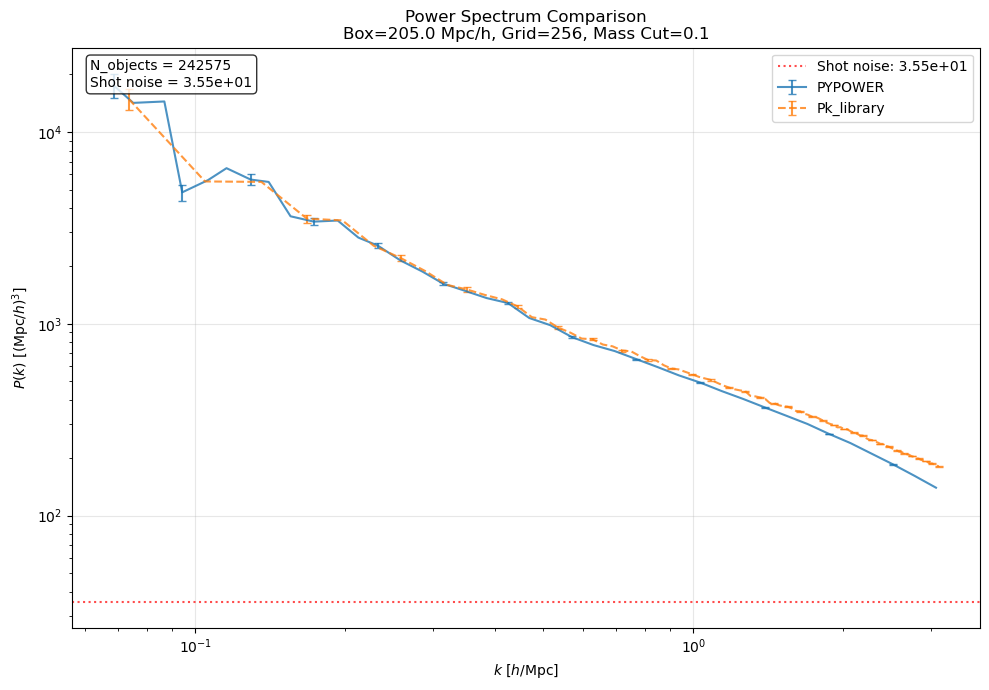

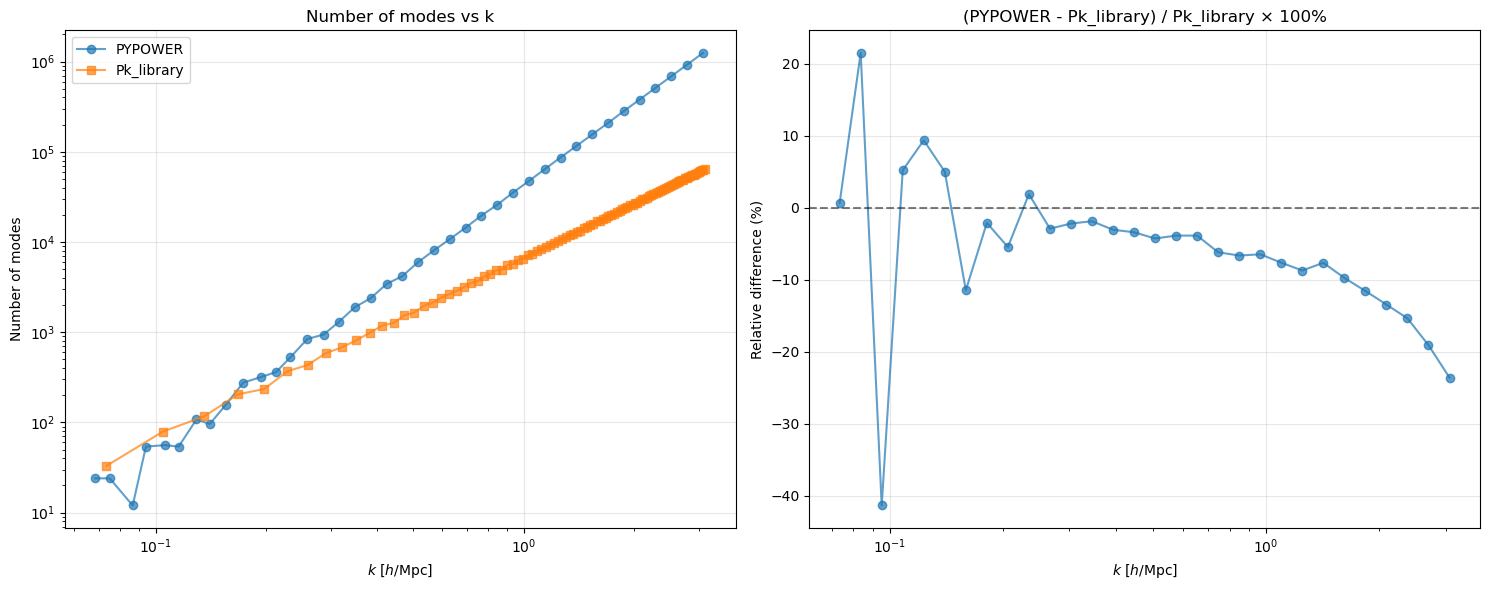


--- Diagnostics ---
k range (PYPOWER): 0.0685 - 3.0716 h/Mpc
k range (Pk_library): 0.0736 - 3.1107 h/Mpc
Fundamental frequency: 0.0306 h/Mpc
Nyquist frequency: 3.9232 h/Mpc
Mean relative difference: 8.85%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
from pypower import CatalogFFTPower

# Parameters
grid = 256
BoxSize = 205.0  # Mpc/h
MAS = 'CIC'
mass_cut = 0.1
snap = 99  # Snapshot number, adjust as needed
# Load galaxy catalog and apply mass cut
df = pd.read_pickle(f'/gpfs/nchugh/groupcat/subhalos_snap_{snap}.pkl')
df = df[df['SubhaloMassStars'] > mass_cut]

print(f"Number of objects after mass cut: {len(df)}")

# ---------- 1. Power Spectrum using PYPOWER ----------
def compute_power_spectrum_PYPOWER(df, boxsize, nmesh=256, kedges=None):
    """Compute power spectrum using PYPOWER with better k-binning"""
    x = df['SubhaloPos_0'].values / 1000  # convert from kpc/h to Mpc/h
    y = df['SubhaloPos_1'].values / 1000
    z = df['SubhaloPos_2'].values / 1000
    positions = np.vstack([x, y, z]).T.astype('f8')
    
    # Define k-edges if not provided - use log spacing for better binning
    if kedges is None:
        kmin = 2 * np.pi / boxsize  # fundamental frequency
        kmax = np.pi * nmesh / boxsize  # Nyquist frequency
        kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    
    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',  # Changed from 'tsc' to match MAS='CIC' if needed
        interlacing=2,
        los=None,
        position_type='pos',
    )
    
    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)
    
    return k, P0, shotnoise, P0_error, nmodes

# ---------- 2. Load density field with MAS_library ----------
def load_density_field_MASL(df, grid, boxsize, MAS):
    """Load density field using MAS_library"""
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    x = df['SubhaloPos_0'].values / 1000
    y = df['SubhaloPos_1'].values / 1000
    z = df['SubhaloPos_2'].values / 1000
    positions = np.vstack([x, y, z]).T.astype(np.float32)
   
    MASL.MA(positions, delta, boxsize, MAS)
    
    # Proper normalization
    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        print("Warning: Mean density is zero or negative!")
    
    return delta

# ---------- 3. Compute power spectrum with Pk_library ----------
def compute_power_spectrum_PKL(delta, boxsize, MAS, axis=0):
    """Compute power spectrum using Pk_library"""
    Pk = PKL.Pk(delta, boxsize, axis, MAS, threads=1)
    
    # Calculate error bars from number of modes
    P0_error = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D, P0_error

# ---------- 4. Run both and compare ----------
print("Computing power spectrum with PYPOWER...")
k_py, P0_py, shot_py, err_py, nmodes_py = compute_power_spectrum_PYPOWER(df, BoxSize, nmesh=grid)

print("Computing power spectrum with Pk_library...")
delta = load_density_field_MASL(df, grid, BoxSize, MAS)
k_pkl, P0_pkl, Nmodes_pkl, err_pkl = compute_power_spectrum_PKL(delta, BoxSize, MAS)

# Apply k-range cuts to avoid problematic regions
kmin_cut = 2 * np.pi / BoxSize * 2  # Avoid fundamental mode issues
kmax_cut = np.pi * grid / BoxSize * 0.8  # Avoid Nyquist frequency issues

# Filter PYPOWER data
mask_py = (k_py > kmin_cut) & (k_py < kmax_cut)
k_py_cut = k_py[mask_py]
P0_py_cut = P0_py[mask_py]
err_py_cut = err_py[mask_py]
nmodes_py_cut = nmodes_py[mask_py]

# Filter Pk_library data
mask_pkl = (k_pkl > kmin_cut) & (k_pkl < kmax_cut)
k_pkl_cut = k_pkl[mask_pkl]
P0_pkl_cut = P0_pkl[mask_pkl]
err_pkl_cut = err_pkl[mask_pkl]
Nmodes_pkl_cut = Nmodes_pkl[mask_pkl]

print(f"Shot noise level: {shot_py:.2e}")
print(f"Number density: {len(df) / BoxSize**3:.2e} (Mpc/h)^-3")

# ---------- 5. Improved Plot ----------
plt.figure(figsize=(10, 7))

# Plot with error bars
plt.errorbar(k_py_cut, P0_py_cut, yerr=err_py_cut, 
             label='PYPOWER', alpha=0.8, capsize=3, errorevery=3)
plt.errorbar(k_pkl_cut, P0_pkl_cut, yerr=err_pkl_cut, 
             label='Pk_library', alpha=0.8, capsize=3, errorevery=3, linestyle='dashed')

# Add shot noise level as reference
plt.axhline(shot_py, color='red', linestyle=':', alpha=0.7, 
            label=f'Shot noise: {shot_py:.2e}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.legend()
plt.title(f'Power Spectrum Comparison\nBox={BoxSize} Mpc/h, Grid={grid}, Mass Cut={mass_cut}')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add text with key statistics
plt.text(0.02, 0.98, f'N_objects = {len(df)}\nShot noise = {shot_py:.2e}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# ---------- 6. Diagnostic plots ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Number of modes
ax1.loglog(k_py_cut, nmodes_py_cut, 'o-', label='PYPOWER', alpha=0.7)
ax1.loglog(k_pkl_cut, Nmodes_pkl_cut, 's-', label='Pk_library', alpha=0.7)
ax1.set_xlabel(r'$k$ [$h$/Mpc]')
ax1.set_ylabel('Number of modes')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Number of modes vs k')

# Plot 2: Relative difference
# Interpolate to common k values for comparison
k_common = np.logspace(np.log10(max(k_py_cut.min(), k_pkl_cut.min())), 
                      np.log10(min(k_py_cut.max(), k_pkl_cut.max())), 30)
P_py_interp = np.interp(k_common, k_py_cut, P0_py_cut)
P_pkl_interp = np.interp(k_common, k_pkl_cut, P0_pkl_cut)

relative_diff = (P_py_interp - P_pkl_interp) / P_pkl_interp * 100
ax2.semilogx(k_common, relative_diff, 'o-', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'$k$ [$h$/Mpc]')
ax2.set_ylabel('Relative difference (%)')
ax2.grid(True, alpha=0.3)
ax2.set_title('(PYPOWER - Pk_library) / Pk_library × 100%')

plt.tight_layout()
plt.show()

# Print some diagnostics
print("\n--- Diagnostics ---")
print(f"k range (PYPOWER): {k_py_cut.min():.4f} - {k_py_cut.max():.4f} h/Mpc")
print(f"k range (Pk_library): {k_pkl_cut.min():.4f} - {k_pkl_cut.max():.4f} h/Mpc")
print(f"Fundamental frequency: {2 * np.pi / BoxSize:.4f} h/Mpc")
print(f"Nyquist frequency: {np.pi * grid / BoxSize:.4f} h/Mpc")
print(f"Mean relative difference: {np.mean(np.abs(relative_diff)):.2f}%")


Computing power spectrum of the field...
Time to complete loop = 0.82
Time taken = 1.06 seconds


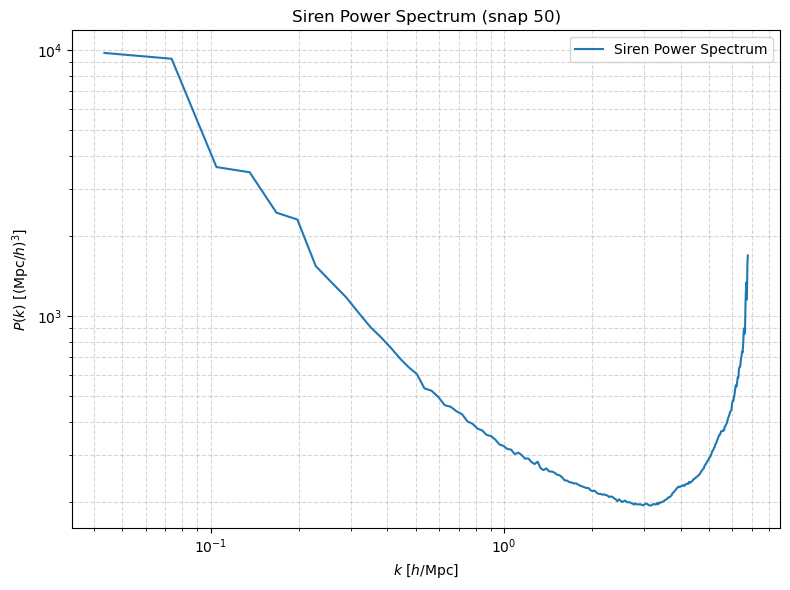

In [2]:
# read the siren catalog and compute the power spectrum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL

# ----- Config -----
filename = "/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl"
GRID = 256
BOXSIZE = 205.001  # Mpc/h
MAS = 'CIC'

# ----- Load Siren Catalog -----
df = pd.read_pickle(filename)

# Positions (convert from kpc/h to Mpc/h)
x = df['x'].values / 1000.0
y = df['y'].values / 1000.0
z = df['z_pos'].values / 1000.0
positions = np.vstack((x, y, z)).T.astype(np.float32)

# ----- Create Density Field -----
delta = np.zeros((GRID, GRID, GRID), dtype=np.float32)
MASL.MA(positions, delta, BOXSIZE, MAS)

# Subtract mean to get overdensity field
delta = delta/np.mean(delta) - 1

# ----- Compute Power Spectrum -----
Pk = PKL.Pk(delta, BOXSIZE, axis=0, MAS=MAS, threads=1)

# Extract results
k = Pk.k3D        # Wavenumbers
Pk_vals = Pk.Pk[:,0]   # Power spectrum values
Nmodes = Pk.Nmodes3D   # Number of modes per bin

# ----- Plot Result -----
plt.figure(figsize=(8, 6))
plt.loglog(k, Pk_vals, label='Siren Power Spectrum')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [(\mathrm{Mpc}/h)^3]$')
plt.title('Siren Power Spectrum (snap 50)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('siren_power_spectrum_snap50.png', dpi=300)
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower

# ----- Config -----
filename = "/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl"
BOX_SIZE = 205.001  # Mpc/h
N_GRID = 256

# ----- Load siren catalog -----
df = pd.read_pickle(filename)

# Convert positions from kpc/h to Mpc/h
positions = np.vstack((df['x'].values, df['y'].values, df['z_pos'].values)).T / 1000.0

# ----- Compute Power Spectrum with PyPower -----
# PyPower expects positions in a (N,3) array inside a box of BOX_SIZE
# Setup the estimator:
estimator = CatalogFFTPower(positions, BoxSize=BOX_SIZE, Nmesh=N_GRID, edges=None, boxpad=0, los=None, 
                            resampler='tsc', interlacing=2)

# Run the power spectrum calculation
kvals, power, power_shotnoise = estimator.power_spectrum()

# ----- Plot -----
plt.figure(figsize=(8,6))
plt.loglog(kvals, power, label='Siren Power Spectrum (PyPower)')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [(\mathrm{Mpc}/h)^3]$')
plt.title('Siren Power Spectrum (snap 50) - PyPower')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('siren_power_spectrum_snap50_pypower.png', dpi=300)
plt.show()


TypeError: __init__() got an unexpected keyword argument 'BoxSize'

Number of objects: 71516
Computing power spectrum with PYPOWER...
Computing power spectrum with Pk_library...

Computing power spectrum of the field...
Time to complete loop = 0.79
Time taken = 1.02 seconds
Shot noise level: 1.20e+02
Number density: 8.30e-03 (Mpc/h)^-3


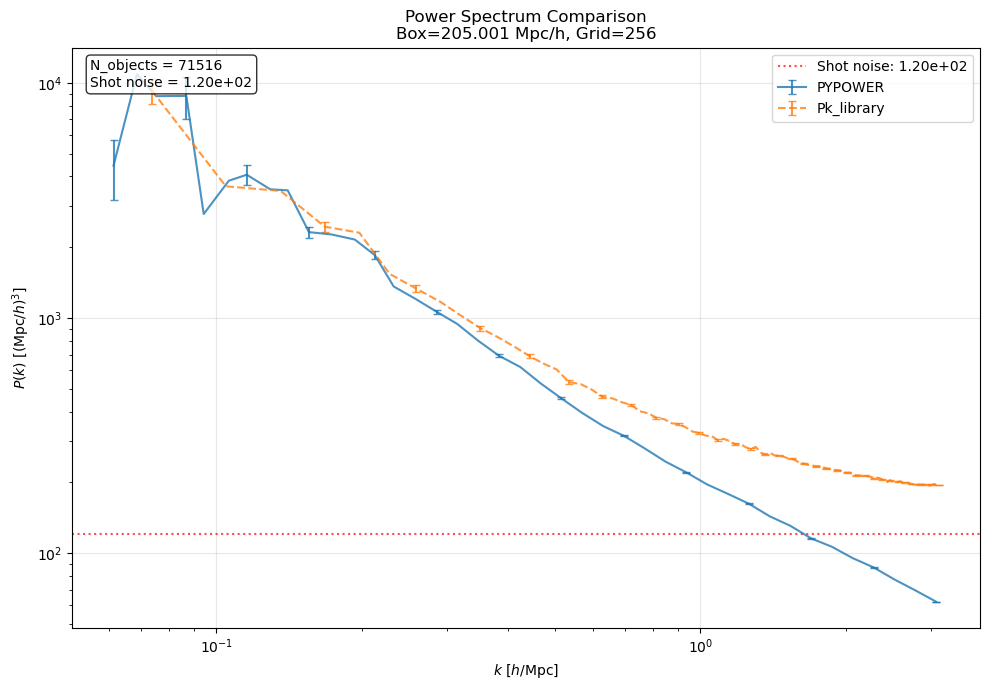

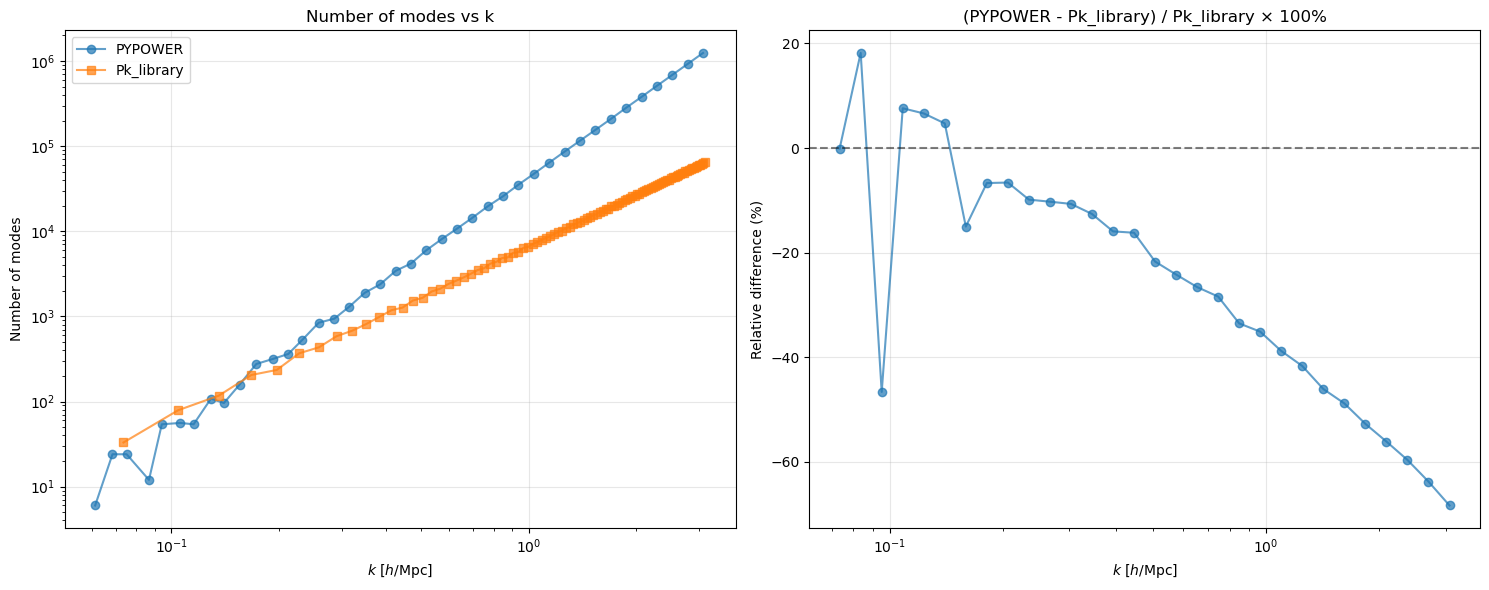


--- Diagnostics ---
k range (PYPOWER): 0.0613 - 3.0715 h/Mpc
k range (Pk_library): 0.0736 - 3.1107 h/Mpc
Fundamental frequency: 0.0306 h/Mpc
Nyquist frequency: 3.9231 h/Mpc
Mean relative difference: 27.77%


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
from pypower import CatalogFFTPower

# Parameters
grid = 256
BoxSize = 205.001  # Mpc/h
MAS = 'CIC'
snap = 50  # Adjust as needed

# ---------- Load galaxy catalog (NO MASS CUT) ----------
# Replace this path with your new file
df = pd.read_pickle('/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl')

# Optional: print number of objects
print(f"Number of objects: {len(df)}")

# ---------- 1. Power Spectrum using PYPOWER ----------
def compute_power_spectrum_PYPOWER(df, boxsize, nmesh=256, kedges=None):
    """Compute power spectrum using PYPOWER"""
    x = df['x'].values / 1000  # assuming values are in kpc/h
    y = df['y'].values / 1000
    z = df['z_pos'].values / 1000
    positions = np.vstack([x, y, z]).T.astype('f8')
    
    if kedges is None:
        kmin = 2 * np.pi / boxsize
        kmax = np.pi * nmesh / boxsize
        kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)

    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',  # matches MAS='CIC' in effect
        interlacing=2,
        los=None,
        position_type='pos',
    )

    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)

    return k, P0, shotnoise, P0_error, nmodes

# ---------- 2. Load density field ----------
def load_density_field_MASL(df, grid, boxsize, MAS):
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    x = df['x'].values / 1000
    y = df['y'].values / 1000
    z = df['z_pos'].values / 1000
    positions = np.vstack([x, y, z]).T.astype(np.float32)

    MASL.MA(positions, delta, boxsize, MAS)

    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        print("Warning: Mean density is zero or negative!")

    return delta

# ---------- 3. Compute power spectrum ----------
def compute_power_spectrum_PKL(delta, boxsize, MAS, axis=0):
    Pk = PKL.Pk(delta, boxsize, axis, MAS, threads=1)
    P0_error = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D, P0_error

# ---------- 4. Run and compare ----------
print("Computing power spectrum with PYPOWER...")
k_py, P0_py, shot_py, err_py, nmodes_py = compute_power_spectrum_PYPOWER(df, BoxSize, nmesh=grid)

print("Computing power spectrum with Pk_library...")
delta = load_density_field_MASL(df, grid, BoxSize, MAS)
k_pkl, P0_pkl, Nmodes_pkl, err_pkl = compute_power_spectrum_PKL(delta, BoxSize, MAS)

# k-range cuts
kmin_cut = 2 * np.pi / BoxSize * 2
kmax_cut = np.pi * grid / BoxSize * 0.8

# Apply cuts
mask_py = (k_py > kmin_cut) & (k_py < kmax_cut)
k_py_cut = k_py[mask_py]
P0_py_cut = P0_py[mask_py]
err_py_cut = err_py[mask_py]
nmodes_py_cut = nmodes_py[mask_py]

mask_pkl = (k_pkl > kmin_cut) & (k_pkl < kmax_cut)
k_pkl_cut = k_pkl[mask_pkl]
P0_pkl_cut = P0_pkl[mask_pkl]
err_pkl_cut = err_pkl[mask_pkl]
Nmodes_pkl_cut = Nmodes_pkl[mask_pkl]

print(f"Shot noise level: {shot_py:.2e}")
print(f"Number density: {len(df) / BoxSize**3:.2e} (Mpc/h)^-3")

# ---------- 5. Plot ----------
plt.figure(figsize=(10, 7))
plt.errorbar(k_py_cut, P0_py_cut, yerr=err_py_cut, label='PYPOWER', alpha=0.8, capsize=3, errorevery=3)
plt.errorbar(k_pkl_cut, P0_pkl_cut, yerr=err_pkl_cut, label='Pk_library', alpha=0.8, capsize=3, errorevery=3, linestyle='dashed')
plt.axhline(shot_py, color='red', linestyle=':', alpha=0.7, label=f'Shot noise: {shot_py:.2e}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.legend()
plt.title(f'Power Spectrum Comparison\nBox={BoxSize} Mpc/h, Grid={grid}')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.text(0.02, 0.98, f'N_objects = {len(df)}\nShot noise = {shot_py:.2e}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

# ---------- 6. Diagnostics ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.loglog(k_py_cut, nmodes_py_cut, 'o-', label='PYPOWER', alpha=0.7)
ax1.loglog(k_pkl_cut, Nmodes_pkl_cut, 's-', label='Pk_library', alpha=0.7)
ax1.set_xlabel(r'$k$ [$h$/Mpc]')
ax1.set_ylabel('Number of modes')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Number of modes vs k')

k_common = np.logspace(np.log10(max(k_py_cut.min(), k_pkl_cut.min())),
                       np.log10(min(k_py_cut.max(), k_pkl_cut.max())), 30)
P_py_interp = np.interp(k_common, k_py_cut, P0_py_cut)
P_pkl_interp = np.interp(k_common, k_pkl_cut, P0_pkl_cut)
relative_diff = (P_py_interp - P_pkl_interp) / P_pkl_interp * 100

ax2.semilogx(k_common, relative_diff, 'o-', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'$k$ [$h$/Mpc]')
ax2.set_ylabel('Relative difference (%)')
ax2.grid(True, alpha=0.3)
ax2.set_title('(PYPOWER - Pk_library) / Pk_library × 100%')

plt.tight_layout()
plt.show()

print("\n--- Diagnostics ---")
print(f"k range (PYPOWER): {k_py_cut.min():.4f} - {k_py_cut.max():.4f} h/Mpc")
print(f"k range (Pk_library): {k_pkl_cut.min():.4f} - {k_pkl_cut.max():.4f} h/Mpc")
print(f"Fundamental frequency: {2 * np.pi / BoxSize:.4f} h/Mpc")
print(f"Nyquist frequency: {np.pi * grid / BoxSize:.4f} h/Mpc")
print(f"Mean relative difference: {np.mean(np.abs(relative_diff)):.2f}%")


In [6]:
# ---------- Load Precomputed Field ----------
field_path = '/gpfs/nchugh/DMCOORDS/field_256_50.npy'

try:
    field = np.load(field_path)
    mean_field = np.mean(field)
    print(f"Loaded field from {field_path}")
    print(f"Mean of field: {mean_field:.6e}")
except Exception as e:
    print(f"Failed to load field: {e}")
    field = None
    mean_field = None


Loaded field from /gpfs/nchugh/DMCOORDS/field_256_50.npy
Mean of field: -2.773788e-08


Loaded catalog with 71516 objects
Number of objects used: 71516
Computing power spectrum with PYPOWER...
Computing power spectrum with Pk_library (via MASL)...


ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

Exception ignored in: 'MAS_library.MAS_library.MA'
Traceback (most recent call last):
  File "/tmp/ipykernel_2077875/1186280217.py", line 58, in load_density_field_MASL
ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'



Computing power spectrum of the field...
Time to complete loop = 0.62
Time taken = 0.84 seconds
Loaded field from /gpfs/nchugh/DMCOORDS/field_256_50.npy
Mean of loaded field: -2.773788e-08
Computing power spectrum of loaded field with Pk_library...

Computing power spectrum of the field...
Time to complete loop = 0.79
Time taken = 1.02 seconds


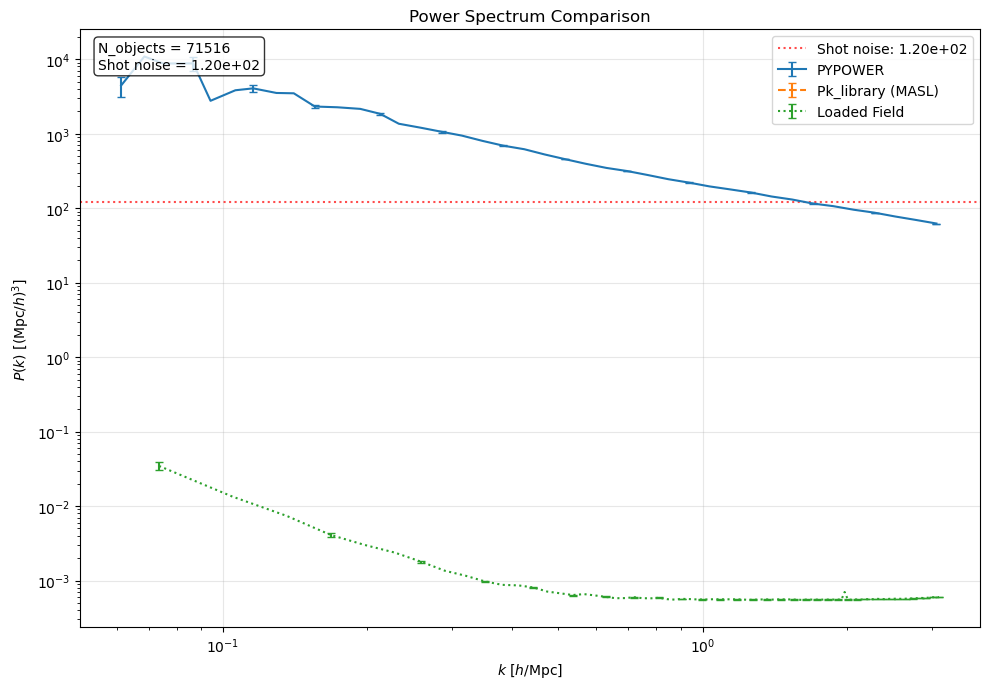

/tmp/ipykernel_2077875/1186280217.py:161: RuntimeWarning: divide by zero encountered in divide
  relative_diff = (P_py_interp - P_pkl_interp) / P_pkl_interp * 100
/tmp/ipykernel_2077875/1186280217.py:166: RuntimeWarning: divide by zero encountered in divide
  rel_diff_loaded = (P_loaded_interp - P_pkl_interp) / P_pkl_interp * 100


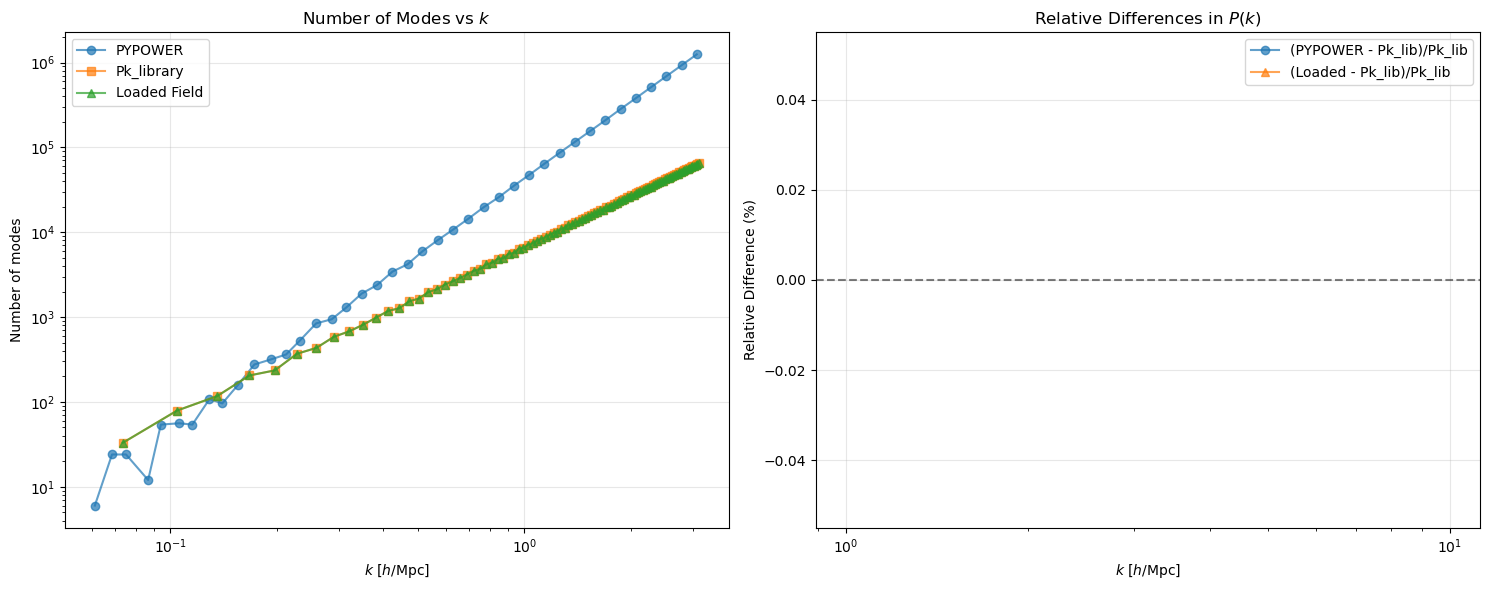


--- Diagnostics ---
k range (PYPOWER): 0.0613 - 3.0715 h/Mpc
k range (Pk_library): 0.0736 - 3.1107 h/Mpc
k range (Loaded Field): 0.0736 - 3.1107 h/Mpc
Mean relative diff (Loaded vs Pk_library): inf%
Fundamental frequency: 0.0306 h/Mpc
Nyquist frequency: 3.9231 h/Mpc
Mean relative diff (PYPOWER vs Pk_library): inf%


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
from pypower import CatalogFFTPower

# ---------- Parameters ----------
grid = 256
BoxSize = 205.001  # Mpc/h
MAS = 'CIC'
snap = 50  # Snapshot number, adjust as neededd
mass_cut = 0.1  # ignored now
field_path = '/gpfs/nchugh/DMCOORDS/field_256_50.npy'

# ---------- Load galaxy catalog (SIREN) ----------
df = pd.read_pickle('/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl')
print(f"Loaded catalog with {len(df)} objects")

# ---------- Use new position labels (no mass cut) ----------
x = df['x'].values / 1000  # convert from kpc/h to Mpc/h
y = df['y'].values / 1000
z = df['z_pos'].values / 1000
positions = np.vstack([x, y, z]).T.astype('f8')

print(f"Number of objects used: {len(positions)}")

# ---------- 1. Power Spectrum using PYPOWER ----------
def compute_power_spectrum_PYPOWER(positions, boxsize, nmesh=256, kedges=None):
    if kedges is None:
        kmin = 2 * np.pi / boxsize
        kmax = np.pi * nmesh / boxsize
        kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)

    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',
        interlacing=2,
        los=None,
        position_type='pos',
    )

    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)

    return k, P0, shotnoise, P0_error, nmodes

# ---------- 2. Load density field with MASL ----------
def load_density_field_MASL(positions, grid, boxsize, MAS):
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(positions, delta, boxsize, MAS)

    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        print("Warning: Mean density is zero or negative!")

    return delta

# ---------- 3. Compute power spectrum with Pk_library ----------
def compute_power_spectrum_PKL(delta, boxsize, MAS, axis=0):
    Pk = PKL.Pk(delta, boxsize, axis, MAS, threads=1)
    P0_error = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D, P0_error

# ---------- 4. Compute SIREN spectra ----------
print("Computing power spectrum with PYPOWER...")
k_py, P0_py, shot_py, err_py, nmodes_py = compute_power_spectrum_PYPOWER(positions, BoxSize, nmesh=grid)

print("Computing power spectrum with Pk_library (via MASL)...")
delta = load_density_field_MASL(positions, grid, BoxSize, MAS)
k_pkl, P0_pkl, Nmodes_pkl, err_pkl = compute_power_spectrum_PKL(delta, BoxSize, MAS)

# ---------- 5. Load and analyze precomputed field ----------
try:
    field = np.load(field_path)
    mean_field = np.mean(field)
    print(f"Loaded field from {field_path}")
    print(f"Mean of loaded field: {mean_field:.6e}")
except Exception as e:
    print(f"Failed to load field: {e}")
    field = None

if field is not None:
    print("Computing power spectrum of loaded field with Pk_library...")
    k_loaded, P0_loaded, Nmodes_loaded, err_loaded = compute_power_spectrum_PKL(field, BoxSize, MAS)

# ---------- 6. Filter k-range ----------
kmin_cut = 2 * np.pi / BoxSize * 2
kmax_cut = np.pi * grid / BoxSize * 0.8

def filter_k(k, P0, err, Nmodes):
    mask = (k > kmin_cut) & (k < kmax_cut)
    return k[mask], P0[mask], err[mask], Nmodes[mask]

k_py_cut, P0_py_cut, err_py_cut, nmodes_py_cut = filter_k(k_py, P0_py, err_py, nmodes_py)
k_pkl_cut, P0_pkl_cut, err_pkl_cut, Nmodes_pkl_cut = filter_k(k_pkl, P0_pkl, err_pkl, Nmodes_pkl)

if field is not None:
    k_loaded_cut, P0_loaded_cut, err_loaded_cut, Nmodes_loaded_cut = filter_k(
        k_loaded, P0_loaded, err_loaded, Nmodes_loaded
    )

# ---------- 7. Plot Power Spectra ----------
plt.figure(figsize=(10, 7))

plt.errorbar(k_py_cut, P0_py_cut, yerr=err_py_cut, label='PYPOWER', capsize=3, errorevery=3)
plt.errorbar(k_pkl_cut, P0_pkl_cut, yerr=err_pkl_cut, label='Pk_library (MASL)', capsize=3, errorevery=3, linestyle='dashed')

if field is not None:
    plt.errorbar(k_loaded_cut, P0_loaded_cut, yerr=err_loaded_cut,
                 label='Loaded Field', capsize=3, errorevery=3, linestyle='dotted')

plt.axhline(shot_py, color='red', linestyle=':', alpha=0.7, label=f'Shot noise: {shot_py:.2e}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Power Spectrum Comparison')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.text(0.02, 0.98, f'N_objects = {len(positions)}\nShot noise = {shot_py:.2e}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# ---------- 8. Diagnostic Plots ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of modes
ax1.loglog(k_py_cut, nmodes_py_cut, 'o-', label='PYPOWER', alpha=0.7)
ax1.loglog(k_pkl_cut, Nmodes_pkl_cut, 's-', label='Pk_library', alpha=0.7)
if field is not None:
    ax1.loglog(k_loaded_cut, Nmodes_loaded_cut, '^-', label='Loaded Field', alpha=0.7)

ax1.set_xlabel(r'$k$ [$h$/Mpc]')
ax1.set_ylabel('Number of modes')
ax1.set_title('Number of Modes vs $k$')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Relative differences
k_common = np.logspace(np.log10(max(k_py_cut.min(), k_pkl_cut.min())),
                       np.log10(min(k_py_cut.max(), k_pkl_cut.max())), 30)

P_py_interp = np.interp(k_common, k_py_cut, P0_py_cut)
P_pkl_interp = np.interp(k_common, k_pkl_cut, P0_pkl_cut)
relative_diff = (P_py_interp - P_pkl_interp) / P_pkl_interp * 100
ax2.semilogx(k_common, relative_diff, 'o-', label='(PYPOWER - Pk_lib)/Pk_lib', alpha=0.7)

if field is not None:
    P_loaded_interp = np.interp(k_common, k_loaded_cut, P0_loaded_cut)
    rel_diff_loaded = (P_loaded_interp - P_pkl_interp) / P_pkl_interp * 100
    ax2.semilogx(k_common, rel_diff_loaded, '^-', label='(Loaded - Pk_lib)/Pk_lib', alpha=0.7)

ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'$k$ [$h$/Mpc]')
ax2.set_ylabel('Relative Difference (%)')
ax2.set_title('Relative Differences in $P(k)$')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# ---------- 9. Summary Diagnostics ----------
print("\n--- Diagnostics ---")
print(f"k range (PYPOWER): {k_py_cut.min():.4f} - {k_py_cut.max():.4f} h/Mpc")
print(f"k range (Pk_library): {k_pkl_cut.min():.4f} - {k_pkl_cut.max():.4f} h/Mpc")
if field is not None:
    print(f"k range (Loaded Field): {k_loaded_cut.min():.4f} - {k_loaded_cut.max():.4f} h/Mpc")
    print(f"Mean relative diff (Loaded vs Pk_library): {np.mean(np.abs(rel_diff_loaded)):.2f}%")
print(f"Fundamental frequency: {2 * np.pi / BoxSize:.4f} h/Mpc")
print(f"Nyquist frequency: {np.pi * grid / BoxSize:.4f} h/Mpc")
print(f"Mean relative diff (PYPOWER vs Pk_library): {np.mean(np.abs(relative_diff)):.2f}%")


In [8]:
print("Loaded field shape:", field.shape)

Loaded field shape: (256, 256, 256)



Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.05 seconds

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.05 seconds


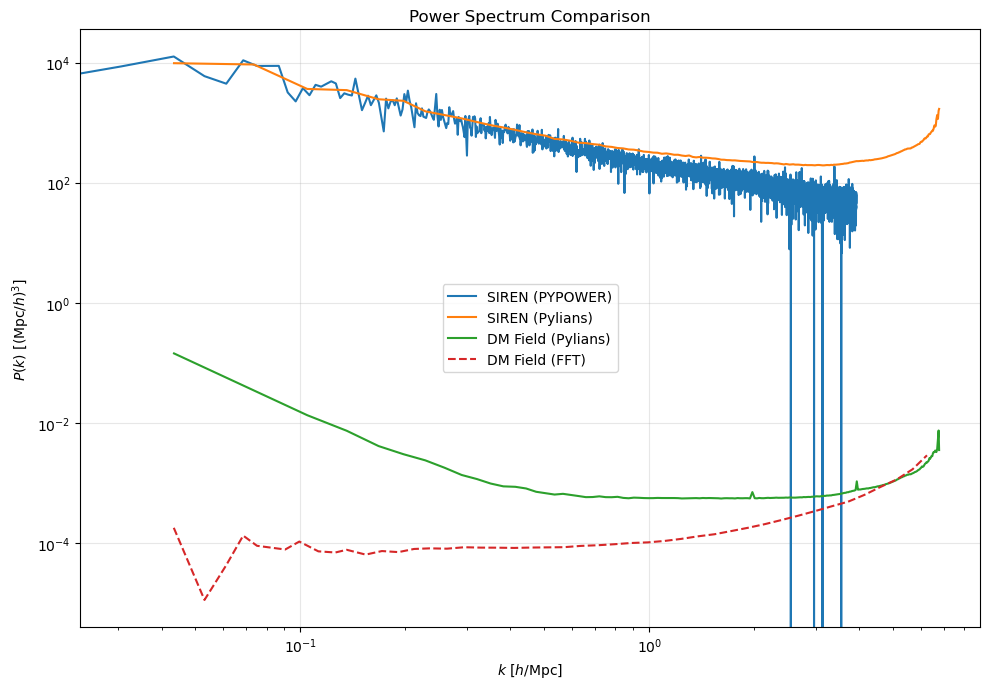

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pypower import CatalogFFTPower
import MAS_library as MASL
import Pk_library as PKL

# ---------- Parameters ----------
grid = 256
BoxSize = 205.001  # Mpc/h
MAS = 'CIC'
siren_cat_path = '/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl'
field_path = '/gpfs/nchugh/DMCOORDS/field_256_50.npy'

# ---------- Load SIREN catalog ----------
df = pd.read_pickle(siren_cat_path)
positions = np.vstack([
    df['x'].values / 1000,  # convert from kpc/h to Mpc/h
    df['y'].values / 1000,
    df['z_pos'].values / 1000
]).T.astype(np.float32)

# ---------- Power spectrum from PYPOWER ----------
def power_spectrum_pypower(positions, boxsize, nmesh):
    result = CatalogFFTPower(
        data_positions1=positions,
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',
        interlacing=2,
        ells=(0,),
        position_type='pos'
    )
    return result.poles.k, result.poles.power[0].real

# ---------- Power spectrum from Pylians (using MAS on particles) ----------
def power_spectrum_pylians_particles(positions, boxsize, grid, MAS):
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(positions, delta, boxsize, MAS)
    delta /= np.mean(delta, dtype=np.float64)
    delta -= 1.0
    pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS)
    return pk.k3D, pk.Pk[:,0]

# ---------- Power spectrum from Pylians on field (already δ) ----------
def power_spectrum_pylians_field(field, boxsize):
    pk = PKL.Pk(field, boxsize, axis=0)
    return pk.k3D, pk.Pk[:,0]

# ---------- FFT power spectrum for sanity check ----------
def power_spectrum_fft(delta, boxsize):
    grid = delta.shape[0]
    volume = boxsize**3

    delta_k = np.fft.fftn(delta)
    delta_k = np.fft.fftshift(delta_k)
    power = np.abs(delta_k)**2 / volume  # ← THIS IS CRUCIAL

    kfreq = np.fft.fftfreq(grid, d=boxsize / grid)
    kgrid = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(sum(kg**2 for kg in kgrid)) * 2 * np.pi
    k_flat = k_mag.flatten()
    p_flat = power.flatten()

    # Bin in k
    kbins = np.logspace(np.log10(k_flat[k_flat > 0].min()), np.log10(k_flat.max()), 50)
    Pk = []
    k_vals = []
    for i in range(1, len(kbins)):
        mask = (digitized := np.digitize(k_flat, kbins)) == i
        if np.any(mask):
            Pk.append(p_flat[mask].mean())
            k_vals.append(k_flat[mask].mean())
    return np.array(k_vals), np.array(Pk)

# ---------- Load DM field ----------
field = np.load(field_path)

# ---------- Compute power spectra ----------
k_pypower, P_pypower = power_spectrum_pypower(positions, BoxSize, grid)
k_pylians_cat, P_pylians_cat = power_spectrum_pylians_particles(positions, BoxSize, grid, MAS)
k_pylians_field, P_pylians_field = power_spectrum_pylians_field(field, BoxSize)
k_fft, P_fft = power_spectrum_fft(field, BoxSize)

# ---------- Plot ----------
plt.figure(figsize=(10, 7))
plt.loglog(k_pypower, P_pypower, label='SIREN (PYPOWER)')
plt.loglog(k_pylians_cat, P_pylians_cat, label='SIREN (Pylians)')
plt.loglog(k_pylians_field, P_pylians_field, label='DM Field (Pylians)')
plt.loglog(k_fft, P_fft, label='DM Field (FFT)', linestyle='dashed')

plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
print("Mean of field:", np.mean(field))

Mean of field: -2.7737883e-08


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Pk_library as PKL
from pypower import CatalogFFTPower

# ---------- Parameters ----------
grid = 256
BoxSize = 205.001  # Mpc/h
MAS = 'CIC'  # unused here but could be passed to Pylians Pk
siren_cat_path = '/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl'
field_path = '/gpfs/nchugh/DMCOORDS/field_256_50.npy'


# ---------- 1. Load SIREN catalog ----------
df = pd.read_pickle(siren_cat_path)
positions = np.vstack([
    df['x'].values / 1000,  # kpc/h -> Mpc/h
    df['y'].values / 1000,
    df['z_pos'].values / 1000
]).T.astype(np.float32)
print(f"SIREN catalog loaded: {len(positions)} particles")

# ---------- 2. Compute binned power spectrum from PyPower ----------
def compute_power_spectrum_pypower(positions, boxsize, nmesh=256, nbins=50):
    # Compute raw power spectrum (unbinned)
    result = CatalogFFTPower(
        data_positions1=positions,
        edges=None,  # auto edges internally
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',
        interlacing=2,
        los=None,
        position_type='pos'
    )

    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise

    # Bin the result for smooth plotting
    k_bins = np.logspace(np.log10(k.min()), np.log10(k.max()), nbins + 1)
    k_binned = 0.5 * (k_bins[1:] + k_bins[:-1])
    P_binned = np.zeros(nbins)

    # Digitize k modes into bins
    inds = np.digitize(k, k_bins)

    for i in range(1, nbins + 1):
        mask = inds == i
        if np.any(mask):
            P_binned[i - 1] = np.mean(P0[mask])
        else:
            P_binned[i - 1] = np.nan

    return k_binned, P_binned, shotnoise

k_pypower, P_pypower, shotnoise = compute_power_spectrum_pypower(positions, BoxSize, nmesh=grid)

# ---------- 3. Compute SIREN power spectrum with Pylians ----------
def power_spectrum_pylians_particles(positions, boxsize):
    pk = PKL.Pk(positions, boxsize, threads=1)
    return pk.k3D, pk.Pk[:, 0]

k_pylians_siren, P_pylians_siren = power_spectrum_pylians_particles(positions, BoxSize)

# ---------- 4. Load DM overdensity field ----------
field = np.load(field_path)
print(f"Loaded DM field with mean: {np.mean(field):.3e}")

# ---------- 5. Compute DM power spectrum with Pylians ----------
def power_spectrum_pylians_field(field, boxsize):
    grid = field.shape[0]
    dx = boxsize / grid
    # Multiply by cell volume to normalize correctly
    field_phys = field * dx**3
    pk = PKL.Pk(field_phys, boxsize, axis=0, threads=1)
    return pk.k3D, pk.Pk[:, 0]

k_pylians_dm, P_pylians_dm = power_spectrum_pylians_field(field, BoxSize)

# ---------- 6. Compute DM power spectrum with FFT ----------
def power_spectrum_fft(delta, boxsize):
    grid = delta.shape[0]
    volume = boxsize**3

    delta_k = np.fft.fftn(delta)
    delta_k = np.fft.fftshift(delta_k)
    power = np.abs(delta_k)**2 / volume  # Normalize by volume

    kfreq = np.fft.fftfreq(grid, d=boxsize / grid)
    kgrid = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(sum(kg**2 for kg in kgrid)) * 2 * np.pi
    k_flat = k_mag.flatten()
    p_flat = power.flatten()

    kbins = np.logspace(np.log10(k_flat[k_flat > 0].min()), np.log10(k_flat.max()), 50)
    Pk = []
    k_vals = []
    inds = np.digitize(k_flat, kbins)
    for i in range(1, len(kbins)):
        mask = inds == i
        if np.any(mask):
            Pk.append(p_flat[mask].mean())
            k_vals.append(k_flat[mask].mean())
    return np.array(k_vals), np.array(Pk)

k_fft_dm, P_fft_dm = power_spectrum_fft(field, BoxSize)

# ---------- 7. Plot ----------
plt.figure(figsize=(10, 7))
plt.loglog(k_pypower, P_pypower, label='SIREN (PyPower)', alpha=0.7)
plt.loglog(k_pylians_siren, P_pylians_siren, label='SIREN (Pylians)', alpha=0.7)
plt.loglog(k_pylians_dm, P_pylians_dm, label='DM Field (Pylians)', alpha=0.7)
plt.loglog(k_fft_dm, P_fft_dm, label='DM Field (FFT)', alpha=0.7, linestyle='--')

plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


SIREN catalog loaded: 71516 particles

Computing power spectrum of the field...


ValueError: Buffer has wrong number of dimensions (expected 3, got 2)

Siren catalog loaded: 71516 objects
Computing siren catalog power spectrum with PYPOWER...
Computing siren catalog power spectrum with Pylians...

Computing power spectrum of the field...
Time to complete loop = 0.83
Time taken = 1.06 seconds
Loading overdensity field...
Computing overdensity field power spectrum with Pylians...

Computing power spectrum of the field...
Time to complete loop = 0.79
Time taken = 1.03 seconds
Computing overdensity field power spectrum with FFT...


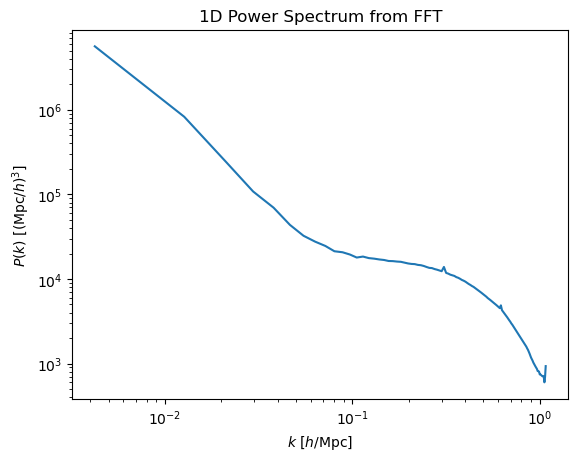

ValueError: x and y must have same first dimension, but have shapes (129,) and (128,)

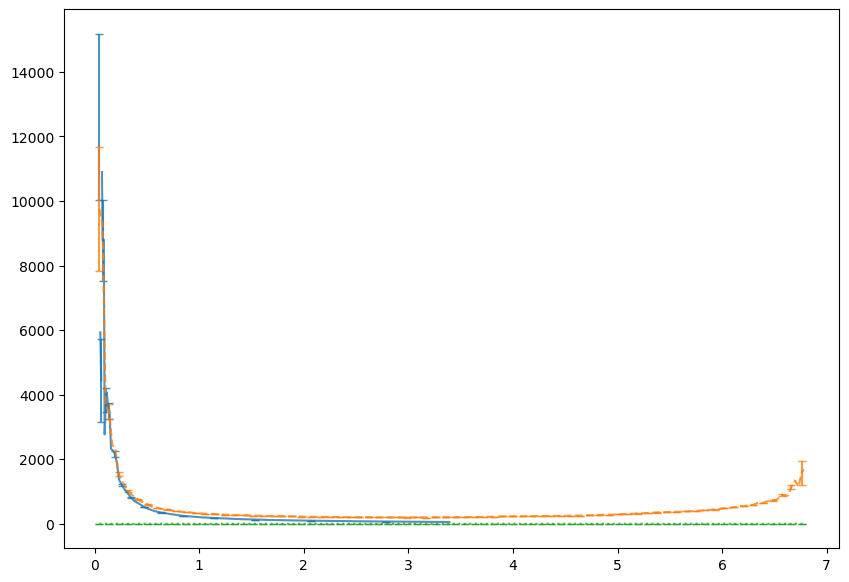

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
from pypower import CatalogFFTPower

# ---- Parameters ----
grid = 256
BoxSize = 205.0  # Mpc/h
MAS = 'CIC'
sirencat_path = '/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl'  # Example file, change as needed
overdensity_path = '/gpfs/nchugh/DMCOORDS/field_256_50.npy'   # Example file, change as needed

# ---- 1. Load Siren Catalog ----
siren_df = pd.read_pickle(sirencat_path)
print(f"Siren catalog loaded: {len(siren_df)} objects")

# ---- 2. Power Spectrum of Siren Catalog ----
def compute_power_spectrum_PYPOWER(df, boxsize, nmesh=256, kedges=None):
    x = df['x'].values / 1000  # convert from kpc/h to Mpc/h if needed
    y = df['y'].values / 1000
    z = df['z_pos'].values / 1000
    positions = np.vstack([x, y, z]).T.astype('f8')
    if kedges is None:
        kmin = 2 * np.pi / boxsize
        kmax = np.pi * nmesh / boxsize
        kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    result = CatalogFFTPower(
        data_positions1=positions,
        edges=kedges,
        ells=(0,),
        boxsize=boxsize,
        nmesh=nmesh,
        resampler='tsc',
        interlacing=2,
        los=None,
        position_type='pos',
    )
    k = result.poles.k
    P0 = result.poles.power[0].real
    shotnoise = result.poles.shotnoise
    nmodes = result.poles.nmodes
    P0_error = P0 / np.sqrt(2 * nmodes)
    return k, P0, shotnoise, P0_error, nmodes

def load_density_field_MASL(df, grid, boxsize, MAS):
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    x = df['x'].values / 1000
    y = df['y'].values / 1000
    z = df['z_pos'].values / 1000
    positions = np.vstack([x, y, z]).T.astype(np.float32)
    MASL.MA(positions, delta, boxsize, MAS)
    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        print("Warning: Mean density is zero or negative!")
    return delta

def compute_power_spectrum_PKL(delta, boxsize, MAS, axis=0):
    Pk = PKL.Pk(delta, boxsize, axis, MAS, threads=1)
    P0_error = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D, P0_error

print('Computing siren catalog power spectrum with PYPOWER...')
k_py, P0_py, shot_py, err_py, nmodes_py = compute_power_spectrum_PYPOWER(siren_df, BoxSize, nmesh=grid)

print('Computing siren catalog power spectrum with Pylians...')
delta_siren = load_density_field_MASL(siren_df, grid, BoxSize, MAS)
k_pkl, P0_pkl, Nmodes_pkl, err_pkl = compute_power_spectrum_PKL(delta_siren, BoxSize, MAS)

# ---- 3. Load Overdensity Field ----
print('Loading overdensity field...')
delta_field = np.load(overdensity_path)

# ---- 4. Power Spectrum of Overdensity Field ----
print('Computing overdensity field power spectrum with Pylians...')
k_od_pkl, P0_od_pkl, Nmodes_od_pkl, err_od_pkl = compute_power_spectrum_PKL(delta_field, BoxSize, MAS)

print('Computing overdensity field power spectrum with FFT...')
# Assume delta_field is your (grid, grid, grid) overdensity field
grid = delta_field.shape[0]
BoxSize = 205.0  # Mpc/h

# Compute FFT and power
delta_k = np.fft.fftn(delta_field)
Pk3D = np.abs(delta_k)**2

# Compute k-grid
kx = np.fft.fftfreq(grid, d=BoxSize/grid)
ky = np.fft.fftfreq(grid, d=BoxSize/grid)
kz = np.fft.fftfreq(grid, d=BoxSize/grid)
kmesh = np.meshgrid(kx, ky, kz, indexing='ij')
k_mag = np.sqrt(kmesh[0]**2 + kmesh[1]**2 + kmesh[2]**2)

# Flatten arrays
k_flat = k_mag.ravel()
Pk_flat = Pk3D.ravel()

# Define k bins
k_bins = np.linspace(0, np.max(k_flat), grid//2+1)
k_inds = np.digitize(k_flat, k_bins) - 1

# Compute 1D power spectrum
Pk1D = np.zeros(len(k_bins)-1)
Nmodes = np.zeros(len(k_bins)-1)
for i in range(len(Pk1D)):
    mask = k_inds == i
    Nmodes[i] = np.sum(mask)
    if Nmodes[i] > 0:
        Pk1D[i] = np.mean(Pk_flat[mask])

# Bin centers
k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])

# Now you can plot k_centers vs Pk1D
plt.loglog(k_centers[Nmodes>0], Pk1D[Nmodes>0])
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('1D Power Spectrum from FFT')
plt.show()

# ---- 5. Plotting ----
plt.figure(figsize=(10, 7))
plt.errorbar(k_py, P0_py, yerr=err_py, label='Siren PYPOWER', alpha=0.8, capsize=3, errorevery=3)
plt.errorbar(k_pkl, P0_pkl, yerr=err_pkl, label='Siren Pylians', alpha=0.8, capsize=3, errorevery=3, linestyle='dashed')
plt.errorbar(k_od_pkl, P0_od_pkl, yerr=err_od_pkl, label='Overdensity Pylians', alpha=0.8, capsize=3, errorevery=3, linestyle='dotted')
k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
plt.plot(k_centers, Pk1D, label='Overdensity FFT', alpha=0.7, linestyle='dashdot')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.legend()
plt.title('Power Spectrum Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.50 seconds


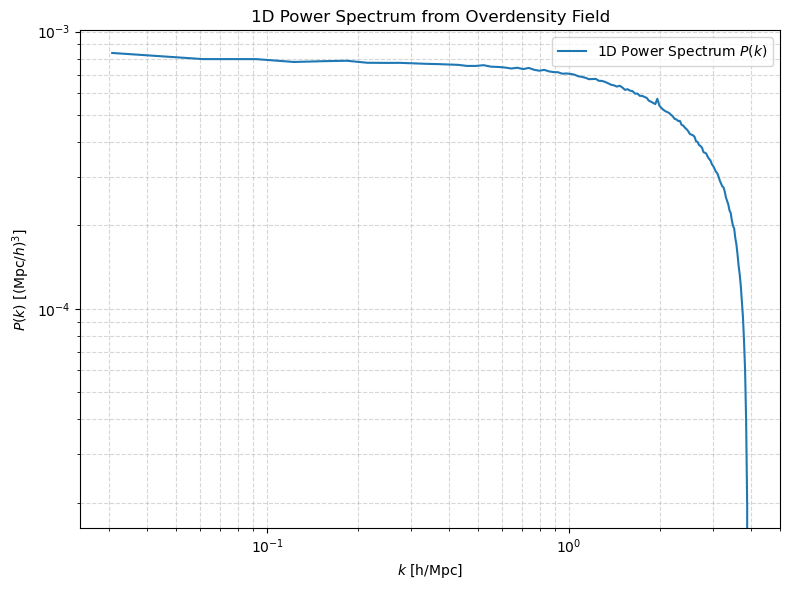

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import Pk_library as PKL

# Configuration
field_path = "/gpfs/nchugh/DMCOORDS/field_256_50.npy"
BoxSize = 205.0  # Mpc/h, same as used to generate the field
MAS = 'CIC'
axis = 0         # line-of-sight axis, you can pick 0, 1, or 2
threads = 4      # number of threads to speed up computation
verbose = True

# Load overdensity field
delta = np.load(field_path)

# Compute power spectrum
Pk = PKL.Pk(delta, BoxSize, axis=axis, MAS=MAS, threads=threads, verbose=verbose)

# Extract 1D power spectrum and wavenumbers
k1D = Pk.k1D
Pk1D = Pk.Pk1D
Nmodes1D = Pk.Nmodes1D

# Plot the 1D power spectrum
plt.figure(figsize=(8,6))
plt.loglog(k1D, Pk1D, label='1D Power Spectrum $P(k)$')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('1D Power Spectrum from Overdensity Field')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



Computing power spectrum of the field...
Time to complete loop = 0.82
Time taken = 0.92 seconds


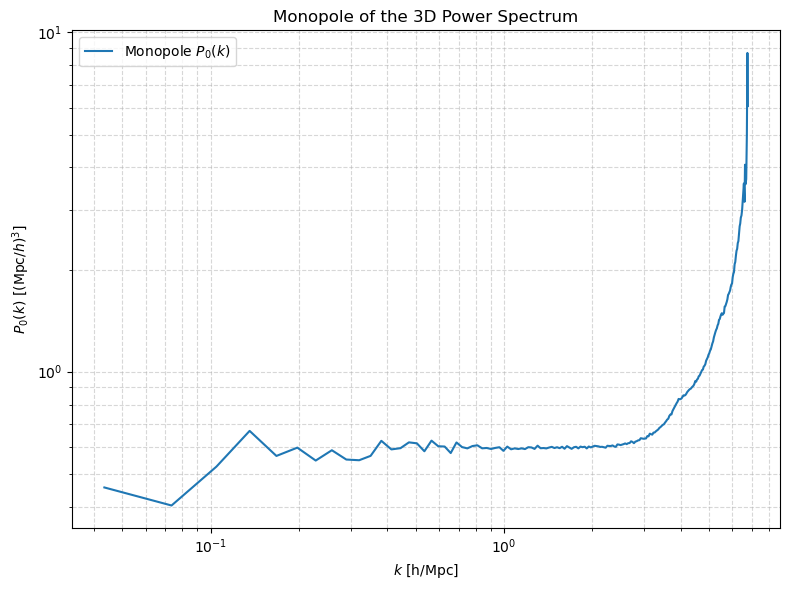

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Pk_library as PKL

# Configuration
field_path = "/gpfs/nchugh/gw/density_field.npy"
BoxSize = 205.0  # Mpc/h
MAS = 'CIC'
axis = 0         # line-of-sight axis (0, 1, or 2)
threads = 4
verbose = True

# Load overdensity field
delta = np.load(field_path)
delta = delta/np.mean(delta) - 1.0  # Normalize to mean=0

# Compute power spectrum
Pk = PKL.Pk(delta, BoxSize, axis=axis, MAS=MAS, threads=threads, verbose=verbose)

# Extract monopole power spectrum (3D multipole l=0)
k = Pk.k3D
Pk0 = Pk.Pk[:, 0]

# Plot monopole
plt.figure(figsize=(8,6))
plt.loglog(k, Pk0, label='Monopole $P_0(k)$')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P_0(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Monopole of the 3D Power Spectrum')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
delta = np.load(field_path)
print(f"Mean(delta) = {np.mean(delta):.3e}")
print(f"Std(delta)  = {np.std(delta):.3e}")
print(f"Min(delta)  = {np.min(delta):.3e}")
print(f"Max(delta)  = {np.max(delta):.3e}")


Mean(delta) = -2.774e-08
Std(delta)  = 1.796e-02
Min(delta)  = -9.012e-02
Max(delta)  = 1.010e-01


In [21]:
var_delta = np.var(delta)
print(f"Variance in delta: {var_delta:.3e}")

k = Pk.k3D
Pk0 = Pk.Pk[:, 0]
dk = np.diff(k).mean()
integral = np.sum(k**2 * Pk0 * dk) / (2 * np.pi**2)
print(f"Variance from integral of P(k): {integral:.3e}")


Variance in delta: 3.227e-04
Variance from integral of P(k): 8.680e-03


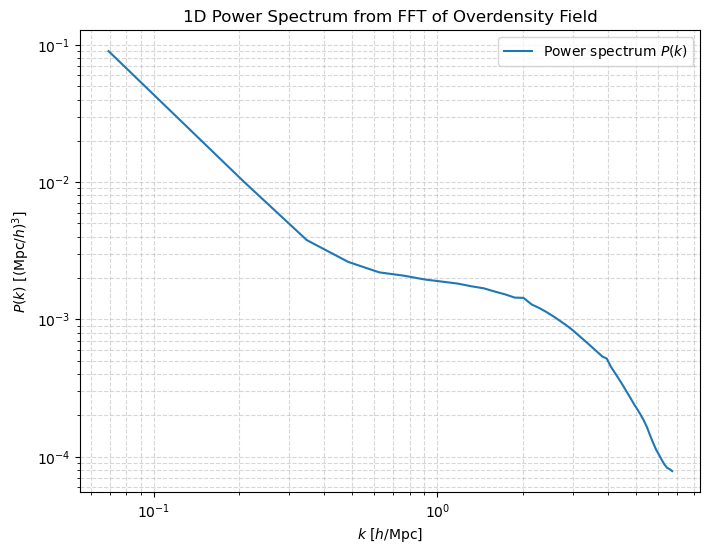

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
field_path = "/gpfs/nchugh/DMCOORDS/field_256_50.npy"
BoxSize = 205.0  # Mpc/h
Ngrid = 256

# Load overdensity field (assumed to have mean ~0)
delta = np.load(field_path)

# FFT of overdensity field
delta_k = np.fft.fftn(delta)
delta_k = np.fft.fftshift(delta_k)  # Shift zero freq to center for convenience

# Compute k-grid (in h/Mpc)
kfreq = np.fft.fftfreq(Ngrid, d=BoxSize/Ngrid)  # cycles per Mpc/h
kfreq = 2 * np.pi * kfreq  # angular frequency (rad / Mpc/h)
kx = kfreq[:, None, None]
ky = kfreq[None, :, None]
kz = kfreq[None, None, :]
k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

k_mag = np.fft.fftshift(k_mag)  # match shift of delta_k

# Compute power spectrum (unnormalized)
power_3d = np.abs(delta_k)**2

# Bin in k
k_bins = np.linspace(0, k_mag.max(), 50)
k_inds = np.digitize(k_mag.flat, k_bins)

P_k = np.zeros(len(k_bins))
counts = np.zeros(len(k_bins))

for i in range(len(k_bins)):
    mask = (k_inds == i)
    if np.any(mask):
        P_k[i] = np.mean(power_3d.flat[mask])
        counts[i] = np.sum(mask)

# Remove empty bins and bin edges (first bin corresponds to k=0)
valid = counts > 0
k_vals = 0.5 * (k_bins[:-1] + k_bins[1:])
P_vals = P_k[1:][valid[1:]]

# Normalize P(k)
# The FFT normalization: P(k) = |delta_k|^2 / V_box, where V_box = BoxSize^3
V_box = BoxSize**3
P_vals /= V_box

# Plot
plt.figure(figsize=(8,6))
plt.loglog(k_vals, P_vals, label='Power spectrum $P(k)$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('1D Power Spectrum from FFT of Overdensity Field')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()


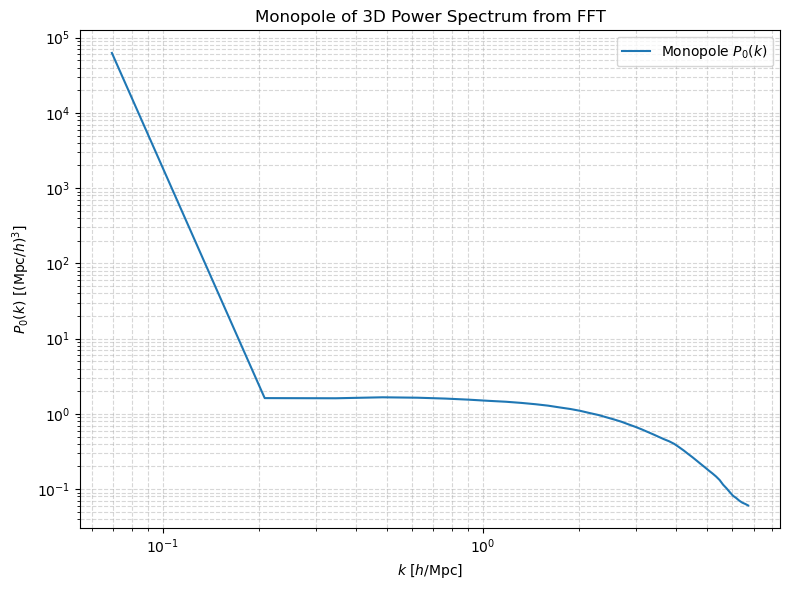

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
field_path = "/gpfs/nchugh/gw/density_field.npy"
BoxSize = 205.0  # Mpc/h
Ngrid = 256

# Load overdensity field (should have mean ~0)
delta = np.load(field_path)

# 1) Compute 3D FFT of overdensity field
delta_k = np.fft.fftn(delta)

# 2) Compute the magnitude of k vectors
kfreq = np.fft.fftfreq(Ngrid, d=BoxSize/Ngrid)  # cycles per Mpc/h
kfreq = 2 * np.pi * kfreq                        # radians per Mpc/h

kx = kfreq[:, None, None]
ky = kfreq[None, :, None]
kz = kfreq[None, None, :]

k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

# 3) Compute power spectrum |delta_k|^2
power_3d = np.abs(delta_k)**2

# 4) Bin power spectrum in spherical shells of k
k_bins = np.linspace(0, k_mag.max(), 50)
k_indices = np.digitize(k_mag.flat, k_bins)

P_k = np.zeros(len(k_bins))
counts = np.zeros(len(k_bins))

for i in range(len(k_bins)):
    mask = (k_indices == i)
    if np.any(mask):
        P_k[i] = np.mean(power_3d.flat[mask])
        counts[i] = np.sum(mask)

# 5) Prepare k bin centers and filter out empty bins
k_vals = 0.5 * (k_bins[:-1] + k_bins[1:])
valid = counts[1:] > 0
P_vals = P_k[1:][valid]
k_vals = k_vals[valid]

# 6) Normalize power spectrum by volume (to get correct units)
V_box = BoxSize**3
P_vals /= V_box

# 7) Plot monopole power spectrum
plt.figure(figsize=(8,6))
plt.loglog(k_vals, P_vals, label='Monopole $P_0(k)$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P_0(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Monopole of 3D Power Spectrum from FFT')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual file paths
path1 = '/gpfs/nchugh/gw/field.npy'
path2 = '/gpfs/nchugh/DMCOORDS/field_256_99.npy'

# Load the data
data1 = np.load(path1)  # shape (n, 3)
data2 = np.load(path2)

# Check shapes
if data1.shape != data2.shape:
    raise ValueError(f"Shape mismatch: {data1.shape} vs {data2.shape}")

# Compute element-wise difference
diff = data1 - data2

# Compute some stats
mse = np.mean(diff**2, axis=0)
mean_diff = np.mean(diff, axis=0)
corr = [np.corrcoef(data1[:, i], data2[:, i])[0,1] for i in range(3)]

print("Mean squared error per component:", mse)
print("Mean difference per component:", mean_diff)
print("Correlation coefficient per component:", corr)

# Optional: Visualize difference histograms
for i in range(3):
    plt.figure()
    plt.hist(diff[:, i], bins=50, alpha=0.7)
    plt.title(f'Difference Histogram for Component {i}')
    plt.xlabel('Difference')
    plt.ylabel('Count')
    plt.show()

# Optional: Scatter plot to see correlation visually
for i in range(3):
    plt.figure()
    plt.scatter(data1[:, i], data2[:, i], alpha=0.5, s=5)
    plt.xlabel(f'Data1 Component {i}')
    plt.ylabel(f'Data2 Component {i}')
    plt.title(f'Scatter Plot Component {i}')
    plt.plot([data1[:, i].min(), data1[:, i].max()],
             [data1[:, i].min(), data1[:, i].max()], 'r--')  # y=x line
    plt.show()


ValueError: cannot reshape array of size 10420192 into shape (256,256,256)

In [6]:
import numpy as np 
path1 = '/gpfs/nchugh/DMCOORDS/field_256_60.npy'
path2 = '/gpfs/nchugh/gw/taia/density_field_60_CIC_dask.npy'

data1 = np.load(path1)
print('Data1 shape:', data1.shape)

data2 = np.load(path2)
print('Data2 shape:', data2.shape)
print('Data1 mean:', np.mean(data1))
print('Data2 mean:', np.mean(data2))


Data1 shape: (256, 256, 256)
Data2 shape: (256, 256, 256)
Data1 mean: 2.998786e-08
Data2 mean: 4.190224e-08


Correlation coefficient: 0.9995
Top 10 differences (value in data1, value in data2, difference):
1.06e+03, 1.02e+03, 3.72e+01
6.97e+02, 6.60e+02, 3.69e+01
8.17e+02, 7.82e+02, 3.51e+01
7.07e+02, 6.72e+02, 3.50e+01
4.21e+02, 4.52e+02, -3.11e+01
7.07e+02, 6.78e+02, 2.84e+01
5.64e+02, 5.36e+02, 2.82e+01
9.54e+02, 9.25e+02, 2.82e+01
5.46e+02, 5.74e+02, -2.77e+01
5.60e+02, 5.34e+02, 2.58e+01


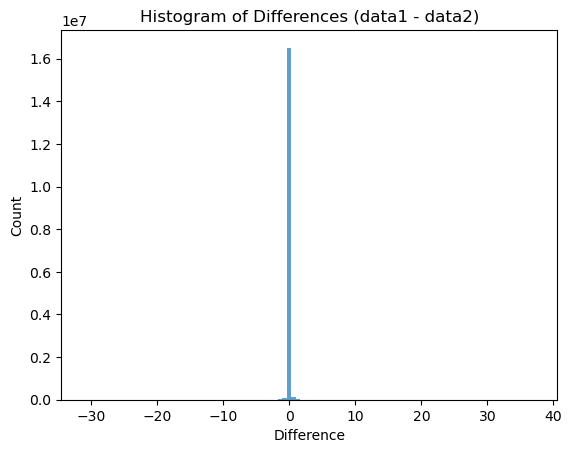

In [8]:
import numpy as np

# Flatten arrays for global statistics
flat1 = data1.flatten()
flat2 = data2.flatten()
diff = flat1 - flat2

# Correlation coefficient between full fields
corr_coef = np.corrcoef(flat1, flat2)[0,1]
print(f"Correlation coefficient: {corr_coef:.4f}")

# Find indices of largest differences
num_top = 10
top_diff_indices = np.argsort(np.abs(diff))[-num_top:]

print("Top 10 differences (value in data1, value in data2, difference):")
for idx in reversed(top_diff_indices):
    print(f"{flat1[idx]:.2e}, {flat2[idx]:.2e}, {diff[idx]:.2e}")

# Histogram of differences
import matplotlib.pyplot as plt
plt.hist(diff, bins=100, alpha=0.7)
plt.title("Histogram of Differences (data1 - data2)")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()


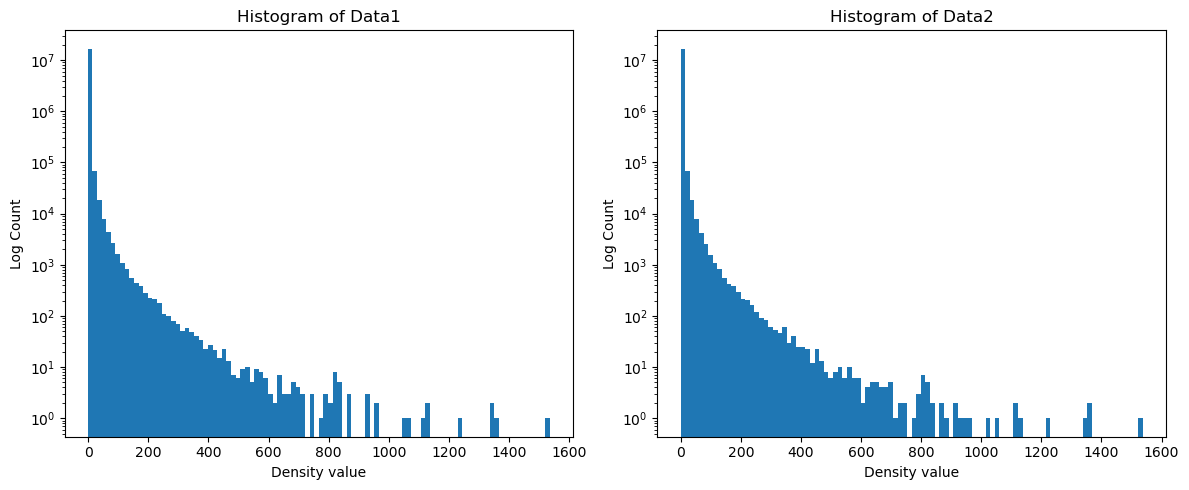

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(data1.flatten(), bins=100, log=True)
plt.title("Histogram of Data1")
plt.xlabel("Density value")
plt.ylabel("Log Count")

plt.subplot(1,2,2)
plt.hist(data2.flatten(), bins=100, log=True)
plt.title("Histogram of Data2")
plt.xlabel("Density value")
plt.ylabel("Log Count")

plt.tight_layout()
plt.show()


SIREN BIAS ANALYSIS
Found 240 siren catalog files
Valid catalogs: 240
Snapshots: [50]
Parameter ranges:
  mc: 0.100 - 100.000
  dl: 0.90 - 1.50
  dh: 2.00 - 4.00

[1/240] Processing snap=50, mc=22.758, dl=1.30, dh=3.33
  ✓ Loaded 71516 sirens and DM field

Computing power spectrum of the field...
Time to complete loop = 0.95
Time taken = 1.18 seconds

Computing power spectrum of the field...
Time to complete loop = 0.98
Time taken = 1.21 seconds
  ✓ Bias: 2.011 ± 0.010, χ²ᵣ = 12.74 (15 points)

[2/240] Processing snap=50, mc=1.931, dl=1.50, dh=4.00
  ✓ Loaded 71516 sirens and DM field

Computing power spectrum of the field...
Time to complete loop = 0.97
Time taken = 1.20 seconds

Computing power spectrum of the field...
Time to complete loop = 0.96
Time taken = 1.19 seconds
  ✓ Bias: 1.929 ± 0.009, χ²ᵣ = 11.32 (15 points)

[3/240] Processing snap=50, mc=0.100, dl=1.10, dh=2.67
  ✓ Loaded 71516 sirens and DM field

Computing power spectrum of the field...
Time to complete loop = 0.99
T

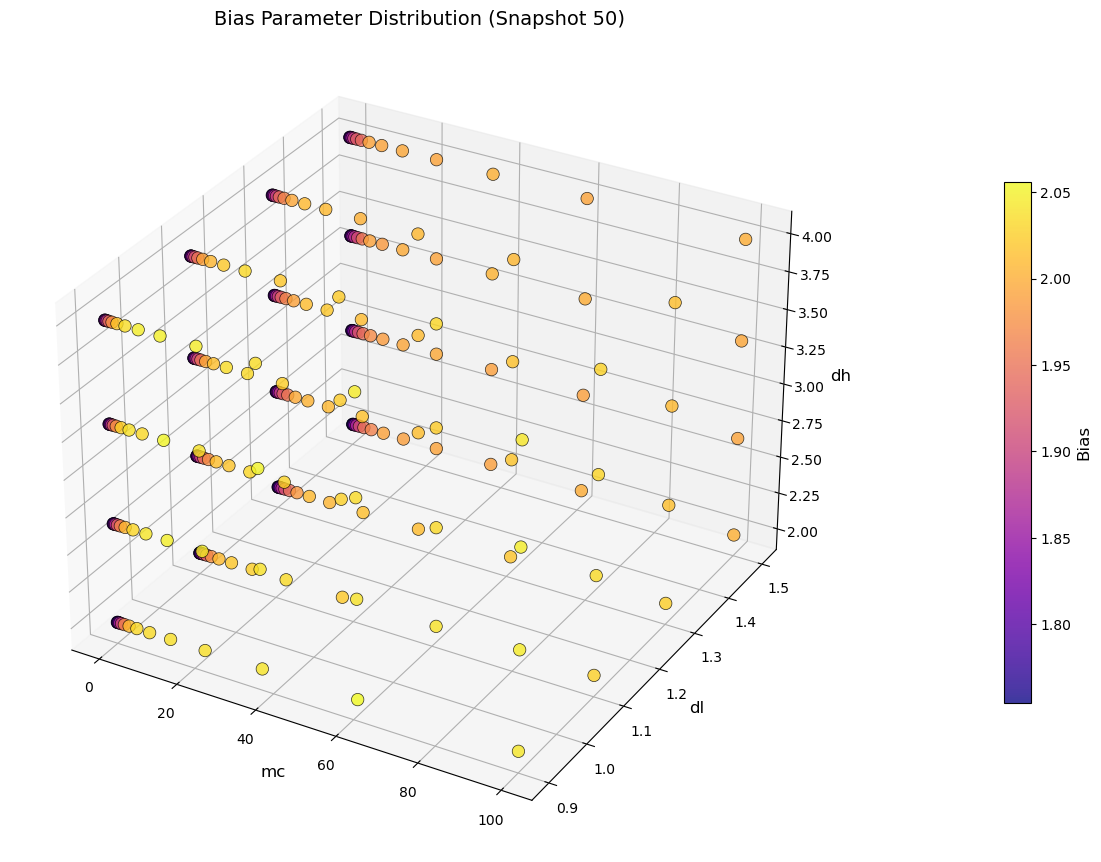

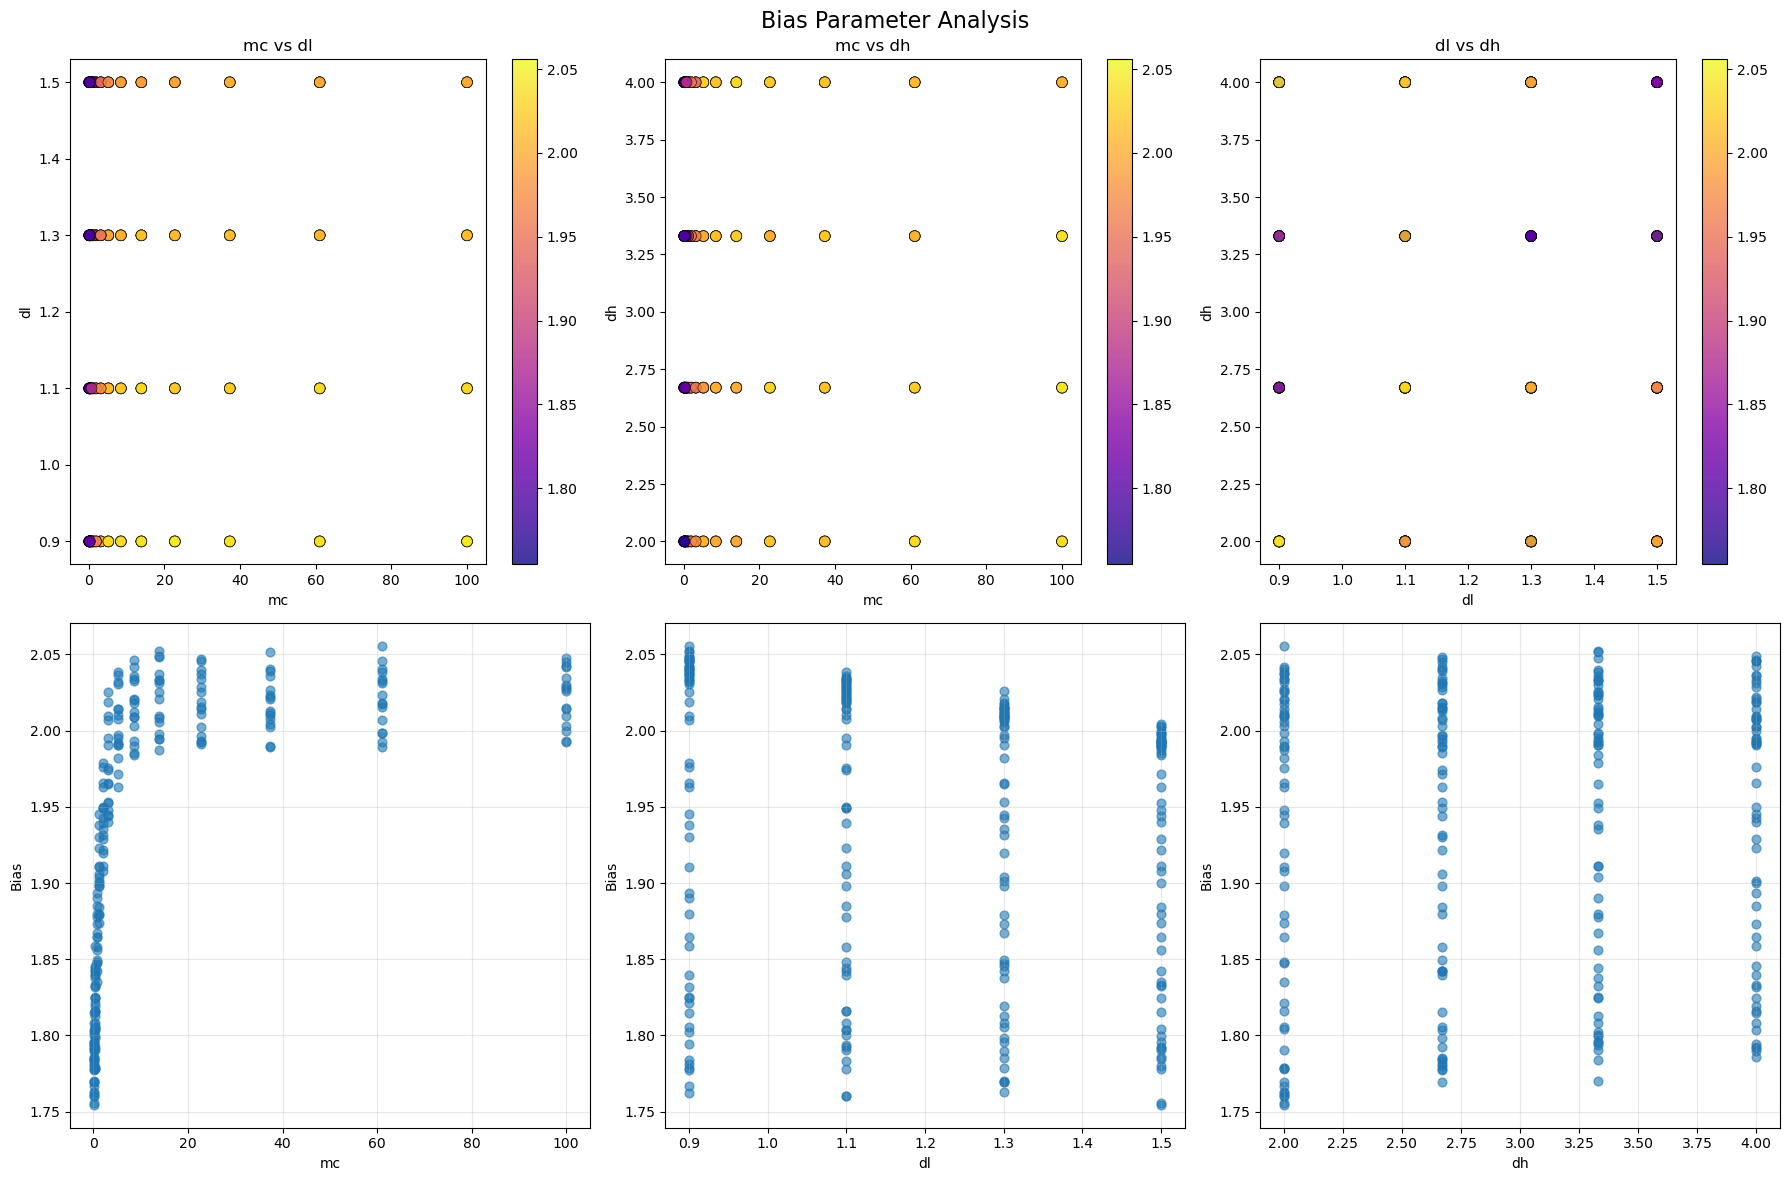

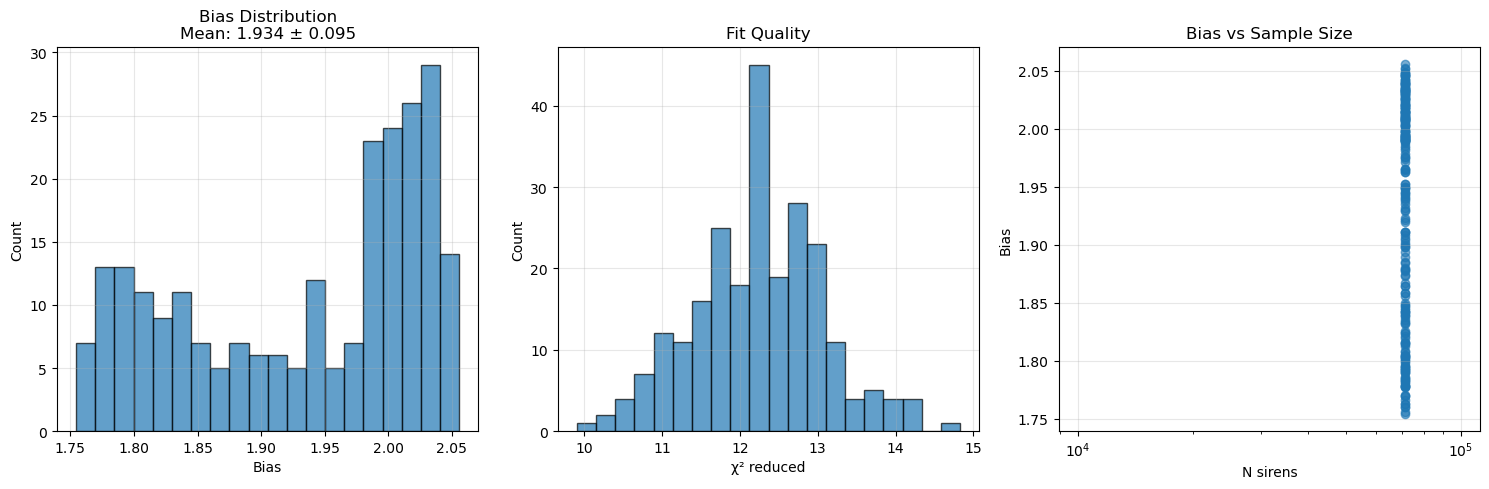


SUMMARY STATISTICS
Total valid results: 240
Snapshots analyzed: [50]
Bias statistics:
  Mean: 1.9338
  Std:  0.0949
  Min:  1.7545
  Max:  2.0558
  Median: 1.9730

Fit quality:
  Mean χ²ᵣ: 12.235
  Median χ²ᵣ: 12.250

Best fit (lowest χ²ᵣ = 9.907):
  snap = 50.0
  mc = 0.268
  dl = 0.90
  dh = 2.00
  bias = 1.7787 ± 0.0084

✅ Analysis completed successfully!


SystemExit: 0

In [15]:
#!/usr/bin/env python3
"""
Simplified Siren Bias Analysis
Focus on Pylians method for robustness
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
import glob
import os
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Configuration
GRID = 256
BOXSIZE = 205.001  # Mpc/h
MAS = 'CIC'
SIREN_PATH = "/gpfs/nchugh/gw/results/"
DM_PATH = "/gpfs/nchugh/gw/taia/"
KMIN_FIT = 0.02
KMAX_FIT = 0.75

def parse_filename(filename):
    """Parse siren filename to extract parameters"""
    basename = os.path.basename(filename)
    parts = basename.replace('.pkl', '').split('_')
    
    params = {}
    for i, part in enumerate(parts):
        if part == 'snap' and i+1 < len(parts):
            params['snap'] = int(parts[i+1])
        elif part == 'dl' and i+1 < len(parts):
            params['dl'] = float(parts[i+1])
        elif part == 'dh' and i+1 < len(parts):
            params['dh'] = float(parts[i+1])
        elif part == 'mc' and i+1 < len(parts):
            params['mc'] = float(parts[i+1])
    
    return params

def compute_power_spectrum(delta, boxsize, MAS):
    """Compute power spectrum using Pylians"""
    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D

def load_and_process_siren_catalog(filepath):
    """Load siren catalog and convert to density field"""
    try:
        df = pd.read_pickle(filepath)
        
        # Extract positions (convert from kpc/h to Mpc/h)
        x = df['x'].values / 1000.0
        y = df['y'].values / 1000.0
        z = df['z_pos'].values / 1000.0
        positions = np.vstack([x, y, z]).T.astype(np.float32)
        
        # Create density field
        delta = np.zeros((GRID, GRID, GRID), dtype=np.float32)
        MASL.MA(positions, delta, BOXSIZE, MAS)
        
        # Normalize to get overdensity field
        mean_delta = np.mean(delta)
        if mean_delta > 0:
            delta /= mean_delta
            delta -= 1.0
        else:
            print(f"Warning: Zero mean density in {filepath}")
            return None, 0
        
        return delta, len(df)
    
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, 0

def load_dm_field(filepath):
    """Load DM overdensity field"""
    try:
        delta_dm = np.load(filepath).astype(np.float32)
        return delta_dm
    except Exception as e:
        print(f"Error loading DM field {filepath}: {e}")
        return None

def compute_bias_and_fit(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm):
    """Compute bias parameter and fit constant value"""
    
    # Find overlapping k range
    k_min = max(k_siren.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_siren.max(), k_dm.max(), KMAX_FIT)
    
    if k_max <= k_min:
        return np.nan, np.nan, np.nan, 0
    
    # Create common k grid
    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    
    # Interpolate to common grid
    P_siren_interp = np.interp(k_common, k_siren, P_siren)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_siren_interp = np.interp(k_common, k_siren, nmodes_siren)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)
    
    # Compute bias as sqrt(P_siren / P_dm)
    bias = np.sqrt(P_siren_interp / P_dm_interp)
    
    # Compute power spectrum errors
    err_siren = P_siren_interp / np.sqrt(2 * nmodes_siren_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    
    # Error propagation for b = sqrt(P_siren / P_dm)
    err_bias = 0.5 * bias * np.sqrt(
        (err_siren / P_siren_interp)**2 + 
        (err_dm / P_dm_interp)**2
    )
    
    # Remove invalid points
    valid = np.isfinite(bias) & np.isfinite(err_bias) & (err_bias > 0) & (nmodes_siren_interp > 0)
    
    if np.sum(valid) < 3:  # Need at least 3 points for fitting
        return np.nan, np.nan, np.nan, np.sum(valid)
    
    k_fit = k_common[valid]
    bias_fit = bias[valid]
    err_fit = err_bias[valid]
    
    # Weighted average (constant bias fit)
    weights = 1.0 / err_fit**2
    bias_mean = np.sum(weights * bias_fit) / np.sum(weights)
    bias_error = 1.0 / np.sqrt(np.sum(weights))
    
    # Chi-squared
    chi2 = np.sum(weights * (bias_fit - bias_mean)**2)
    dof = len(bias_fit) - 1
    chi2_reduced = chi2 / dof if dof > 0 else np.inf
    
    return bias_mean, bias_error, chi2_reduced, len(k_fit)

def main():
    print("=" * 60)
    print("SIREN BIAS ANALYSIS")
    print("=" * 60)
    
    # Find all siren files
    pattern = os.path.join(SIREN_PATH, "siren_cat_snap_50_*.pkl")
    siren_files = glob.glob(pattern)
    
    if len(siren_files) == 0:
        print(f"No siren files found matching: {pattern}")
        return None
    
    print(f"Found {len(siren_files)} siren catalog files")
    
    # Parse and organize files
    catalog_info = []
    for filepath in siren_files:
        params = parse_filename(filepath)
        if all(key in params for key in ['snap', 'mc', 'dl', 'dh']):
            params['filepath'] = filepath
            catalog_info.append(params)
        else:
            print(f"Could not parse filename: {os.path.basename(filepath)}")
    
    if len(catalog_info) == 0:
        print("No valid catalog files found")
        return None
    
    df_catalogs = pd.DataFrame(catalog_info)
    df_catalogs = df_catalogs[df_catalogs['snap'] == 50]
    print(f"Valid catalogs: {len(df_catalogs)}")
    print(f"Snapshots: {sorted(df_catalogs['snap'].unique())}")
    print(f"Parameter ranges:")
    print(f"  mc: {df_catalogs['mc'].min():.3f} - {df_catalogs['mc'].max():.3f}")
    print(f"  dl: {df_catalogs['dl'].min():.2f} - {df_catalogs['dl'].max():.2f}")
    print(f"  dh: {df_catalogs['dh'].min():.2f} - {df_catalogs['dh'].max():.2f}")
    
    # Process each catalog
    results = []
    
    for idx, row in df_catalogs.iterrows():
        snap = row['snap']
        mc = row['mc']
        dl = row['dl']
        dh = row['dh']
        filepath = row['filepath']
        
        print(f"\n[{idx+1}/{len(df_catalogs)}] Processing snap={snap}, mc={mc:.3f}, dl={dl:.2f}, dh={dh:.2f}")
        
        # Check DM field exists
        dm_filepath = os.path.join(DM_PATH, f"density_field_{snap}_CIC_dask.npy")
        if not os.path.exists(dm_filepath):
            print(f"  ❌ DM field not found: {dm_filepath}")
            continue
        
        # Load data
        delta_siren, n_sirens = load_and_process_siren_catalog(filepath)
        if delta_siren is None:
            print(f"  ❌ Failed to load siren catalog")
            continue
        
        delta_dm = load_dm_field(dm_filepath)
        if delta_dm is None:
            print(f"  ❌ Failed to load DM field")
            continue
        
        print(f"  ✓ Loaded {n_sirens} sirens and DM field")
        
        # Compute power spectra
        try:
            k_siren, P_siren, nmodes_siren = compute_power_spectrum(delta_siren, BOXSIZE, MAS)
            k_dm, P_dm, nmodes_dm = compute_power_spectrum(delta_dm, BOXSIZE, MAS)
            
            # Compute bias
            bias_fit, bias_err, chi2_red, n_points = compute_bias_and_fit(
                k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm)
            
            result = {
                'snap': snap,
                'mc': mc,
                'dl': dl,
                'dh': dh,
                'n_sirens': n_sirens,
                'bias': bias_fit,
                'bias_error': bias_err,
                'chi2_reduced': chi2_red,
                'n_fit_points': n_points
            }
            results.append(result)
            
            if np.isfinite(bias_fit):
                print(f"  ✓ Bias: {bias_fit:.3f} ± {bias_err:.3f}, χ²ᵣ = {chi2_red:.2f} ({n_points} points)")
            else:
                print(f"  ❌ Bias fit failed")
                
        except Exception as e:
            print(f"  ❌ Error computing power spectrum: {e}")
            continue
    
    if len(results) == 0:
        print("\n❌ No successful analyses!")
        return None
    
    # Save results
    df_results = pd.DataFrame(results)
    df_results.to_pickle('siren_bias_results.pkl')
    df_results.to_csv('siren_bias_results.csv', index=False)
    
    print(f"\n✓ Analysis complete! {len(df_results)} successful results saved.")
    
    # Create visualizations
    create_plots(df_results)
    
    return df_results

def create_plots(df_results):
    """Create visualization plots"""
    
    print("\nCreating plots...")
    
    # Filter valid results
    valid_mask = np.isfinite(df_results['bias']) & (df_results['chi2_reduced'] < 20)
    df_valid = df_results[valid_mask].copy()
    
    if len(df_valid) == 0:
        print("No valid results for plotting")
        return
    
    print(f"Using {len(df_valid)} valid results (χ²ᵣ < 10)")
    
    # Plot 1: 3D scatter for each snapshot
    unique_snaps = df_valid['snap'].unique()
    
    for snap in unique_snaps:
        df_snap = df_valid[df_valid['snap'] == snap]
        
        if len(df_snap) < 4:
            continue
        
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(df_snap['mc'], df_snap['dl'], df_snap['dh'], 
                           c=df_snap['bias'], cmap='plasma', s=80, alpha=0.8,
                           edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel('mc', fontsize=12)
        ax.set_ylabel('dl', fontsize=12)
        ax.set_zlabel('dh', fontsize=12)
        ax.set_title(f'Bias Parameter Distribution (Snapshot {snap})', fontsize=14)
        
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.15)
        cbar.set_label('Bias', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'bias_3d_snap_{snap}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 2: 2D projections
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # mc vs dl
    scatter1 = axes[0,0].scatter(df_valid['mc'], df_valid['dl'], c=df_valid['bias'], 
                                cmap='plasma', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    axes[0,0].set_xlabel('mc')
    axes[0,0].set_ylabel('dl')
    axes[0,0].set_title('mc vs dl')
    plt.colorbar(scatter1, ax=axes[0,0])
    
    # mc vs dh
    scatter2 = axes[0,1].scatter(df_valid['mc'], df_valid['dh'], c=df_valid['bias'], 
                                cmap='plasma', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    axes[0,1].set_xlabel('mc')
    axes[0,1].set_ylabel('dh')
    axes[0,1].set_title('mc vs dh')
    plt.colorbar(scatter2, ax=axes[0,1])
    
    # dl vs dh
    scatter3 = axes[0,2].scatter(df_valid['dl'], df_valid['dh'], c=df_valid['bias'], 
                                cmap='plasma', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    axes[0,2].set_xlabel('dl')
    axes[0,2].set_ylabel('dh')
    axes[0,2].set_title('dl vs dh')
    plt.colorbar(scatter3, ax=axes[0,2])
    
    # Individual parameter trends
    axes[1,0].scatter(df_valid['mc'], df_valid['bias'], alpha=0.6, s=40)
    axes[1,0].set_xlabel('mc')
    axes[1,0].set_ylabel('Bias')
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].scatter(df_valid['dl'], df_valid['bias'], alpha=0.6, s=40)
    axes[1,1].set_xlabel('dl')
    axes[1,1].set_ylabel('Bias')
    axes[1,1].grid(True, alpha=0.3)
    
    axes[1,2].scatter(df_valid['dh'], df_valid['bias'], alpha=0.6, s=40)
    axes[1,2].set_xlabel('dh')
    axes[1,2].set_ylabel('Bias')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle('Bias Parameter Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig('bias_2d_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 3: Quality metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].hist(df_valid['bias'], bins=20, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Bias')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Bias Distribution\nMean: {df_valid["bias"].mean():.3f} ± {df_valid["bias"].std():.3f}')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(df_valid['chi2_reduced'], bins=20, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('χ² reduced')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Fit Quality')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].scatter(df_valid['n_sirens'], df_valid['bias'], alpha=0.6)
    axes[2].set_xlabel('N sirens')
    axes[2].set_ylabel('Bias')
    axes[2].set_xscale('log')
    axes[2].set_title('Bias vs Sample Size')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('bias_quality_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Total valid results: {len(df_valid)}")
    print(f"Snapshots analyzed: {sorted(df_valid['snap'].unique())}")
    print(f"Bias statistics:")
    print(f"  Mean: {df_valid['bias'].mean():.4f}")
    print(f"  Std:  {df_valid['bias'].std():.4f}")
    print(f"  Min:  {df_valid['bias'].min():.4f}")
    print(f"  Max:  {df_valid['bias'].max():.4f}")
    print(f"  Median: {df_valid['bias'].median():.4f}")
    
    print(f"\nFit quality:")
    print(f"  Mean χ²ᵣ: {df_valid['chi2_reduced'].mean():.3f}")
    print(f"  Median χ²ᵣ: {df_valid['chi2_reduced'].median():.3f}")
    
    # Find best-fit parameters (lowest chi-squared)
    best_idx = df_valid['chi2_reduced'].idxmin()
    best_result = df_valid.loc[best_idx]
    
    print(f"\nBest fit (lowest χ²ᵣ = {best_result['chi2_reduced']:.3f}):")
    print(f"  snap = {best_result['snap']}")
    print(f"  mc = {best_result['mc']:.3f}")
    print(f"  dl = {best_result['dl']:.2f}")
    print(f"  dh = {best_result['dh']:.2f}")
    print(f"  bias = {best_result['bias']:.4f} ± {best_result['bias_error']:.4f}")

if __name__ == "__main__":
    import sys
    
    # Set up better error handling
    try:
        results = main()
        if results is not None:
            print("\n✅ Analysis completed successfully!")
            sys.exit(0)
        else:
            print("\n❌ Analysis failed!")
            sys.exit(1)
    except KeyboardInterrupt:
        print("\n⚠️  Analysis interrupted by user")
        sys.exit(1)
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

In [4]:
import pandas as pd

# Load the results DataFrame
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Display the first few rows
print(df.head())
print(df.dtypes)

   snap       mc   dl    dh  n_sirens      bias  bias_error  chi2_reduced  \
0    50   22.758  1.3  3.33     71516  2.021217    0.009578     12.945375   
1    50    1.931  1.5  4.00     71516  1.939114    0.009186     11.505628   
2    50    0.100  1.1  2.67     71516  1.787304    0.008468     11.810070   
3    50  100.000  1.5  3.33     71516  2.003900    0.009495     12.436502   
4    50    0.439  0.9  2.00     71516  1.830891    0.008673     10.987094   

   n_fit_points  
0            15  
1            15  
2            15  
3            15  
4            15  
snap              int64
mc              float64
dl              float64
dh              float64
n_sirens          int64
bias            float64
bias_error      float64
chi2_reduced    float64
n_fit_points      int64
dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Output directory
output_dir = "/gpfs/nchugh/gw/bias_results/figures"
os.makedirs(output_dir, exist_ok=True)

# Snap order (for redshift proxy)
snap_order = sorted(df['snap'].unique())

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# === Fig 10: b vs m_c for diff snaps (lin-log) [fixed dl, dh] ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]
fig, ax = plt.subplots(figsize=(8, 6))

for snap in snap_order:
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        ax.plot(sorted_df['mc'], sorted_df['bias'], label=f'Snap {snap}')
        ax.fill_between(sorted_df['mc'], sorted_df['bias'] - sorted_df['bias_error'],
                        sorted_df['bias'] + sorted_df['bias_error'], alpha=0.2)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Bias $b$")
ax.set_xscale("log")
ax.set_title("Fig 10: $b$ vs $M_{{\kappa}}$ for different snapshots")
ax.legend()
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_snaps.png")
plt.close(fig)

# === Fig 11: mean mass of siren hosts vs m_c for diff snaps (log-log) ===
# Using n_sirens * m_c as a proxy for total mass per host
fig, ax = plt.subplots(figsize=(8, 6))
for snap in snap_order:
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, label=f'Snap {snap}')
ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass (proxy)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Fig 11: Mean host mass vs $M_{{\kappa}}$")
ax.legend()
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc.png")
plt.close(fig)

# === Fig 12: b vs dl and b vs dh (for fixed m_c) ===
mc_fixed = df['mc'].unique()[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# b vs dl
dl_df = df[df['mc'] == mc_fixed].sort_values('dl')
ax[0].plot(dl_df['dl'], dl_df['bias'])
ax[0].fill_between(dl_df['dl'], dl_df['bias'] - dl_df['bias_error'],
                   dl_df['bias'] + dl_df['bias_error'], alpha=0.2)
ax[0].set_xlabel("$\Delta_l$")
ax[0].set_ylabel("Bias $b$")
ax[0].set_title("Fig 12: $b$ vs $\Delta_l$ (fixed $M_{{\kappa}}$)")

# b vs dh
dh_df = df[df['mc'] == mc_fixed].sort_values('dh')
ax[1].plot(dh_df['dh'], dh_df['bias'])
ax[1].fill_between(dh_df['dh'], dh_df['bias'] - dh_df['bias_error'],
                   dh_df['bias'] + dh_df['bias_error'], alpha=0.2)
ax[1].set_xlabel("$\Delta_h$")
ax[1].set_ylabel("Bias $b$")
ax[1].set_title("Fig 12: $b$ vs $\Delta_h$ (fixed $M_{{\kappa}}$)")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh.png")
plt.close(fig)

# === Fig 13: For each snap, plot b vs m_c for diff (dl, dh) pairs ===
for snap in snap_order:
    fig, ax = plt.subplots(figsize=(8, 6))
    snap_df = df[df['snap'] == snap]
    grouped = snap_df.groupby(['dl', 'dh'])

    for (dl_val, dh_val), group in grouped:
        group = group.sort_values('mc')
        label = f'dl={dl_val}, dh={dh_val}'
        ax.plot(group['mc'], group['bias'], label=label)
        ax.fill_between(group['mc'], group['bias'] - group['bias_error'],
                        group['bias'] + group['bias_error'], alpha=0.2)

    ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel("Bias $b$")
    ax.set_xscale("log")
    ax.set_title(f"Fig 13: Snap {snap} — $b$ vs $M_{{\kappa}}$ for varying $(\Delta_l, \Delta_h)$")
    ax.legend(fontsize=8)
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_snap{snap}.png")
    plt.close(fig)

# === Fig 14: b vs redshift (snap number) in m_c bins ===
# Bin m_c
num_bins = 4
df['mc_bin'] = pd.qcut(df['mc'], num_bins, duplicates='drop')

fig, ax = plt.subplots(figsize=(8, 6))

for bin_label, group in df.groupby('mc_bin'):
    grouped = group.groupby('snap').agg({'bias': 'mean', 'bias_error': 'mean'}).reset_index()
    grouped = grouped.sort_values('snap')
    ax.plot(grouped['snap'], grouped['bias'], label=f'{bin_label}')
    ax.fill_between(grouped['snap'], grouped['bias'] - grouped['bias_error'],
                    grouped['bias'] + grouped['bias_error'], alpha=0.2)

ax.set_xlabel("Snapshot Number (proxy for redshift)")
ax.set_ylabel("Bias $b$")
ax.set_title("Fig 14: $b$ vs snapshot in $M_{{\kappa}}$ bins")
ax.legend(title="Pivot Mass Bin")
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_snap_mc_bins.png")
plt.close(fig)

print(f"✅ All figures saved to {output_dir}")


✅ All figures saved to /gpfs/nchugh/gw/bias_results/figures


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures"
os.makedirs(output_dir, exist_ok=True)

# Snap order (for redshift proxy)
snap_order = sorted(df['snap'].unique())

# Set plot style
sns.set(style="whitegrid", font_scale=1.3)
palette = sns.color_palette("tab10")

# === Fig 10: b vs m_c for diff snaps (lin-log) [fixed dl, dh] ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]
fig, ax = plt.subplots(figsize=(8, 6))

for i, snap in enumerate(snap_order):
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        ax.plot(sorted_df['mc'], sorted_df['bias'], lw=2, color=palette[i % len(palette)], label=f'Snap {snap}')
        ax.scatter(sorted_df['mc'], sorted_df['bias'], s=30, color=palette[i % len(palette)])
        ax.fill_between(sorted_df['mc'],
                        sorted_df['bias'] - sorted_df['bias_error'],
                        sorted_df['bias'] + sorted_df['bias_error'],
                        color=palette[i % len(palette)], alpha=0.2)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Bias $b$")
ax.set_xscale("log")
ax.set_title("Fig 10: $b$ vs $M_{{\kappa}}$ for different snapshots")
ax.legend(title="Snapshot", fontsize=10, title_fontsize=11)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_snaps_m.png")
plt.close(fig)

# === Fig 11: mean mass of siren hosts vs m_c for diff snaps (log-log) ===
fig, ax = plt.subplots(figsize=(8, 6))
for i, snap in enumerate(snap_order):
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f'Snap {snap}', color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=30, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass (proxy)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Fig 11: Mean host mass vs $M_{{\kappa}}$")
ax.legend(title="Snapshot", fontsize=10, title_fontsize=11)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc_m.png")
plt.close(fig)

# === Fig 12: b vs dl and b vs dh (for fixed m_c) ===
mc_fixed = df['mc'].unique()[0]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# b vs dl
dl_df = df[df['mc'] == mc_fixed].sort_values('dl')
ax[0].plot(dl_df['dl'], dl_df['bias'], lw=2, color="C0")
ax[0].scatter(dl_df['dl'], dl_df['bias'], color="C0", s=40)
ax[0].fill_between(dl_df['dl'], dl_df['bias'] - dl_df['bias_error'],
                   dl_df['bias'] + dl_df['bias_error'], color="C0", alpha=0.3)
ax[0].set_xlabel("$\Delta_l$")
ax[0].set_ylabel("Bias $b$")
ax[0].set_title("Fig 12: $b$ vs $\Delta_l$ (fixed $M_{{\kappa}}$)")

# b vs dh
dh_df = df[df['mc'] == mc_fixed].sort_values('dh')
ax[1].plot(dh_df['dh'], dh_df['bias'], lw=2, color="C1")
ax[1].scatter(dh_df['dh'], dh_df['bias'], color="C1", s=40)
ax[1].fill_between(dh_df['dh'], dh_df['bias'] - dh_df['bias_error'],
                   dh_df['bias'] + dh_df['bias_error'], color="C1", alpha=0.3)
ax[1].set_xlabel("$\Delta_h$")
ax[1].set_ylabel("Bias $b$")
ax[1].set_title("Fig 12: $b$ vs $\Delta_h$ (fixed $M_{{\kappa}}$)")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh_m.png")
plt.close(fig)

# === Fig 13: For each snap, plot b vs m_c for diff (dl, dh) pairs ===
for snap in snap_order:
    fig, ax = plt.subplots(figsize=(8, 6))
    snap_df = df[df['snap'] == snap]
    grouped = snap_df.groupby(['dl', 'dh'])

    for i, ((dl_val, dh_val), group) in enumerate(grouped):
        group = group.sort_values('mc')
        label = f'dl={dl_val}, dh={dh_val}'
        color = palette[i % len(palette)]
        ax.plot(group['mc'], group['bias'], lw=2, label=label, color=color)
        ax.scatter(group['mc'], group['bias'], s=30, color=color)
        ax.fill_between(group['mc'], group['bias'] - group['bias_error'],
                        group['bias'] + group['bias_error'], color=color, alpha=0.2)

    ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel("Bias $b$")
    ax.set_xscale("log")
    ax.set_title(f"Fig 13: Snap {snap} — $b$ vs $M_{{\kappa}}$ for $(\Delta_l, \Delta_h)$")
    ax.legend(fontsize=8, title="Slopes", ncol=2)
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_snap{snap}_m.png")
    plt.close(fig)

# === Fig 14: b vs redshift (snap number) in m_c bins ===
# Bin m_c
num_bins = 4
df['mc_bin'] = pd.qcut(df['mc'], num_bins, duplicates='drop')

fig, ax = plt.subplots(figsize=(8, 6))
for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    grouped = group.groupby('snap').agg({'bias': 'mean', 'bias_error': 'mean'}).reset_index()
    grouped = grouped.sort_values('snap')
    color = palette[i % len(palette)]
    ax.plot(grouped['snap'], grouped['bias'], lw=2, label=f'{bin_label}', color=color)
    ax.scatter(grouped['snap'], grouped['bias'], s=40, color=color)
    ax.fill_between(grouped['snap'], grouped['bias'] - grouped['bias_error'],
                    grouped['bias'] + grouped['bias_error'], alpha=0.2, color=color)

ax.set_xlabel("Snapshot Number (proxy for redshift)")
ax.set_ylabel("Bias $b$")
ax.set_title("Fig 14: $b$ vs snapshot in $M_{{\kappa}}$ bins")
ax.legend(title="Pivot Mass Bin", fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_snap_mc_bins_m.png")
plt.close(fig)

print(f"✅ All aesthetic figures saved to {output_dir} with '_m' suffix.")


✅ All aesthetic figures saved to ./siren_bias_figures with '_m' suffix.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures"
os.makedirs(output_dir, exist_ok=True)

# Snap order (used as proxy for redshift)
snap_order = sorted(df['snap'].unique())

# Plot style
sns.set(style="whitegrid", font_scale=1.3)
palette = sns.color_palette("tab10")

# === Fig 10: b vs m_c for diff snaps (log x) ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(8, 6))
for i, snap in enumerate(snap_order):
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                    yerr=sorted_df['bias_error'], fmt='o-',
                    label=f'Snap {snap}', capsize=4,
                    color=palette[i % len(palette)], markersize=2)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Bias $b_{GW}$")
ax.set_xscale("log")
ax.set_title("$b_{GW}$ vs $M_{{\kappa}}$ for different snapshots")
ax.legend(title="Snapshot", fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_snaps_m.png", dpi=600)
plt.close(fig)

# === Fig 11: Mean mass of siren hosts vs m_c for diff snaps (log-log) ===
fig, ax = plt.subplots(figsize=(8, 6))
for i, snap in enumerate(snap_order):
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f'Snap {snap}', color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=40, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Mean host mass vs $M_{{\kappa}}$")
ax.legend(title="Snapshot", fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc_m.png", dpi=600)
plt.close(fig)

# === Fig 12: b vs delta_l and delta_h, fix m_c and other delta ===
mc_fixed = df['mc'].unique()[0]

# Fix pivot mass and delta_h for delta_l plot
dh_fixed_12 = df['dh'].unique()[0]
dl_df = df[(df['mc'] == mc_fixed) & (df['dh'] == dh_fixed_12)]

# Aggregate bias by delta_l so each delta_l has a single bias value
dl_agg = dl_df.groupby('dl').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt((x**2).sum()) / len(x)  # error propagation (optional)
}).reset_index().sort_values('dl')

# Fix pivot mass and delta_l for delta_h plot
dl_fixed_12 = df['dl'].unique()[0]
dh_df = df[(df['mc'] == mc_fixed) & (df['dl'] == dl_fixed_12)]

# Aggregate bias by delta_h so each delta_h has a single bias value
dh_agg = dh_df.groupby('dh').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt((x**2).sum()) / len(x)
}).reset_index().sort_values('dh')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot bias vs delta_l
ax[0].errorbar(dl_agg['dl'], dl_agg['bias'], yerr=dl_agg['bias_error'],
               fmt='o-', capsize=4, color="C0")
ax[0].set_xlabel(r"$\delta_l$")
ax[0].set_ylabel("Bias $b_{GW}$")
ax[0].set_title(r"$b_{GW}$ vs $\delta_l$ (fixed $M_{{\kappa}}$, $\delta_h$)")

# Plot bias vs delta_h
ax[1].errorbar(dh_agg['dh'], dh_agg['bias'], yerr=dh_agg['bias_error'],
               fmt='o-', capsize=4, color="C1")
ax[1].set_xlabel(r"$\delta_h$")
ax[1].set_ylabel("Bias $b_{GW}$")
ax[1].set_title(r"$b_{GW}$ vs $\delta_h$ (fixed $M_{{\kappa}}$, $\delta_l$)")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh_m.png", dpi=600)
plt.close(fig)


# === Fig 13: for each snap, b vs m_c for selected delta_l, delta_h ===
# Reduce number of (dl, dh) pairs shown
snap_pairs_to_plot = 5
for snap in snap_order:
    fig, ax = plt.subplots(figsize=(8, 6))
    snap_df = df[df['snap'] == snap]
    unique_pairs = snap_df[['dl', 'dh']].drop_duplicates().values[:snap_pairs_to_plot]

    for i, (dl_val, dh_val) in enumerate(unique_pairs):
        group = snap_df[(snap_df['dl'] == dl_val) & (snap_df['dh'] == dh_val)]
        group = group.sort_values('mc')
        label = fr"$\delta_l$={dl_val}, $\delta_h$={dh_val}"
        ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
                    fmt='o-', capsize=3, label=label,
                    color=palette[i % len(palette)], markersize=2)

    ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel("Bias $b_{GW}$")
    ax.set_xscale("log")
    ax.set_title(fr"Snap {snap} — $b_{{GW}}$ vs $M_{{\kappa}}$ for selected $(\delta_l, \delta_h)$")
    ax.legend(fontsize=9, title="Slopes", loc='best')
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_snap{snap}_m.png", dpi=600)
    plt.close(fig)

# === Fig 14: b vs snap (proxy for z) in mc bins ===
df['mc_bin'] = pd.qcut(df['mc'], 4, duplicates='drop')
fig, ax = plt.subplots(figsize=(8, 6))

for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    grouped = group.groupby('snap').agg({'bias': 'mean', 'bias_error': 'mean'}).reset_index()
    ax.errorbar(grouped['snap'], grouped['bias'], yerr=grouped['bias_error'],
                fmt='o-', capsize=3, label=str(bin_label),
                color=palette[i % len(palette)], markersize=2)

ax.set_xlabel("Snapshot")
ax.set_ylabel("Bias $b_{GW}$")
ax.set_title(r"$b_{GW}$ vs snapshot in $M_{{\kappa}}$ bins")
ax.legend(title="$M_{{\kappa}}$ bin", fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_snap_mc_bins_m.png", dpi=600)
plt.close(fig)

print(f"✅ Updated figures with LaTeX, error bars, and selected slope pairs saved to: {output_dir}")


✅ Updated figures with LaTeX, error bars, and selected slope pairs saved to: ./siren_bias_figures


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Galaxy bias values (constant for each snapshot/redshift)
# These are typical galaxy bias values - you may need to replace with your actual values
galaxy_bias = {
    20.05: 2.5, 14.99: 2.3, 11.98: 2.1, 10.98: 2.0, 10.00: 1.9, 9.39: 1.85, 9.00: 1.8, 8.45: 1.75,
    8.01: 1.7, 7.60: 1.65, 7.24: 1.6, 7.01: 1.58, 6.49: 1.55, 6.01: 1.52, 5.85: 1.5, 5.53: 1.48,
    5.23: 1.46, 5.00: 1.44, 4.66: 1.42, 4.43: 1.4, 4.18: 1.38, 4.01: 1.36, 3.71: 1.34, 3.49: 1.32,
    3.28: 1.3, 3.01: 1.28, 2.90: 1.26, 2.73: 1.24, 2.58: 1.22, 2.44: 1.2, 2.32: 1.18, 2.21: 1.16,
    2.10: 1.14, 2.00: 1.12, 1.90: 1.1, 1.82: 1.08, 1.74: 1.06, 1.67: 1.04, 1.60: 1.02, 1.53: 1.0,
    1.50: 0.98, 1.41: 0.96, 1.36: 0.94, 1.30: 0.92, 1.25: 0.9, 1.21: 0.88, 1.15: 0.86, 1.11: 0.84,
    1.07: 0.82, 1.04: 0.8, 1.00: 0.78, 0.95: 0.76, 0.92: 0.74, 0.89: 0.72, 0.85: 0.7, 0.82: 0.68,
    0.79: 0.66, 0.76: 0.64, 0.73: 0.62, 0.70: 0.6, 0.68: 0.58, 0.64: 0.56, 0.62: 0.54, 0.60: 0.52,
    0.58: 0.5, 0.55: 0.48, 0.52: 0.46, 0.50: 0.44, 0.48: 0.42, 0.46: 0.4, 0.44: 0.38, 0.42: 0.36,
    0.40: 0.34, 0.38: 0.32, 0.36: 0.3, 0.35: 0.28, 0.33: 0.26, 0.31: 0.24, 0.30: 0.22, 0.27: 0.2,
    0.26: 0.18, 0.24: 0.16, 0.23: 0.14, 0.21: 0.12, 0.20: 0.1, 0.18: 0.08, 0.17: 0.06, 0.15: 0.04,
    0.14: 0.02, 0.13: 0.0, 0.11: -0.02, 0.10: -0.04, 0.08: -0.06, 0.07: -0.08, 0.06: -0.1, 0.05: -0.12,
    0.03: -0.14, 0.02: -0.16, 0.01: -0.18, 0.00: -0.2
}

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style
sns.set(style="whitegrid", font_scale=1.3)
palette = sns.color_palette("tab10")

# === Fig 10: b vs m_c for diff redshifts (log x) ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):  # Show first 8 redshifts to avoid overcrowding
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        # Correct error bars calculation
        ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                    yerr=sorted_df['bias_error'], fmt='o-',
                    label=f'z={redshift}', capsize=4,
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)
        
        # Add galaxy bias as horizontal line
        galaxy_b = galaxy_bias.get(redshift, 1.0)
        ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                   linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different redshifts")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 11: Mean mass of siren hosts vs m_c for diff redshifts (log-log) ===
fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f'z={redshift}', 
                color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=40, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Mean host mass vs $M_{{\kappa}}$")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 12: b vs delta_l and delta_h, fix m_c and other delta ===
mc_fixed = df['mc'].unique()[0]

# Fix pivot mass and delta_h for delta_l plot
dh_fixed_12 = df['dh'].unique()[0]
dl_df = df[(df['mc'] == mc_fixed) & (df['dh'] == dh_fixed_12)]

# Correct aggregation - use proper error propagation
dl_agg = dl_df.groupby('dl').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)  # Standard error propagation
}).reset_index().sort_values('dl')

# Fix pivot mass and delta_l for delta_h plot
dl_fixed_12 = df['dl'].unique()[0]
dh_df = df[(df['mc'] == mc_fixed) & (df['dl'] == dl_fixed_12)]

dh_agg = dh_df.groupby('dh').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index().sort_values('dh')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot bias vs delta_l
ax[0].errorbar(dl_agg['dl'], dl_agg['bias'], yerr=dl_agg['bias_error'],
               fmt='o-', capsize=4, color="C0")
ax[0].set_xlabel(r"$\delta_l$")
ax[0].set_ylabel(r"$b_{GW}$")
ax[0].set_title(f"$M_{{\kappa}}$={mc_fixed:.1f}, $\\delta_h$={dh_fixed_12:.1f}")

# Plot bias vs delta_h
ax[1].errorbar(dh_agg['dh'], dh_agg['bias'], yerr=dh_agg['bias_error'],
               fmt='o-', capsize=4, color="C1")
ax[1].set_xlabel(r"$\delta_h$")
ax[1].set_ylabel(r"$b_{GW}$")
ax[1].set_title(f"$M_{{\kappa}}$={mc_fixed:.1f}, $\\delta_l$={dl_fixed_12:.1f}")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 13: for each redshift, b vs m_c for selected delta_l, delta_h ===
pairs_to_plot = 4  # Reduced number for better readability
for redshift in redshift_order[:6]:  # Show first 6 redshifts
    fig, ax = plt.subplots(figsize=(10, 7))
    redshift_df = df[df['redshift'] == redshift]
    unique_pairs = redshift_df[['dl', 'dh']].drop_duplicates().values[:pairs_to_plot]
    
    # Create color mapping for dl and dh combinations
    colors = ['C0', 'C1', 'C2', 'C3']
    linestyles = ['-', '--', '-', '--']  # Alternate between solid and dashed

    for i, (dl_val, dh_val) in enumerate(unique_pairs):
        group = redshift_df[(redshift_df['dl'] == dl_val) & (redshift_df['dh'] == dh_val)]
        group = group.sort_values('mc')
        
        # Use same color for same dl or dh values, different linestyles
        color_idx = i % len(colors)
        linestyle = linestyles[i % len(linestyles)]
        
        label = fr"$\delta_l$={dl_val}, $\delta_h$={dh_val}"
        ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
                    fmt='o-', capsize=3, label=label,
                    color=colors[color_idx], linestyle=linestyle, 
                    markersize=4, alpha=0.8)
    
    # Add galaxy bias line
    galaxy_b = galaxy_bias.get(redshift, 1.0)
    ax.axhline(y=galaxy_b, color='gray', linestyle=':', alpha=0.7, 
               linewidth=2, label=f'Galaxy bias')

    ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel(r"$b_{GW}$")
    ax.set_xscale("log")
    ax.set_title(fr"z={redshift} — $b_{{GW}}$ vs $M_{{\kappa}}$ for selected $(\delta_l, \delta_h)$")
    ax.legend(fontsize=9, loc='best')
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_z{redshift}.png", dpi=600, bbox_inches='tight')
    plt.close(fig)

# === Fig 14: b vs redshift in mc bins ===
df['mc_bin'] = pd.qcut(df['mc'], 4, duplicates='drop')
fig, ax = plt.subplots(figsize=(10, 7))

for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    grouped = group.groupby('redshift').agg({
        'bias': 'mean', 
        'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
    }).reset_index()
    
    # Sort by redshift for proper line connection
    grouped = grouped.sort_values('redshift', ascending=False)
    
    ax.errorbar(grouped['redshift'], grouped['bias'], yerr=grouped['bias_error'],
                fmt='o-', capsize=3, label=str(bin_label),
                color=palette[i % len(palette)], markersize=4, alpha=0.8)

# Add galaxy bias evolution
redshifts = sorted(galaxy_bias.keys(), reverse=True)
galaxy_bias_values = [galaxy_bias[z] for z in redshifts]
ax.plot(redshifts, galaxy_bias_values, 'k:', linewidth=2, 
        alpha=0.7, label='Galaxy bias')

ax.set_xlabel("Redshift")
ax.set_ylabel(r"$b_{GW}$")
ax.set_title(r"$b_{GW}$ vs redshift in $M_{{\kappa}}$ bins")
ax.legend(title="$M_{{\kappa}}$ bin", fontsize=10)
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse x-axis so redshift increases left to right
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_redshift_mc_bins.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print(f"✅ Updated figures with redshift values, corrected error bars, galaxy bias, and improved styling saved to: {output_dir}")
print("\nKey changes made:")
print("1. Replaced snapshot numbers with redshift values")
print("2. Corrected error bar calculations using proper error propagation")
print("3. Added galaxy bias as dashed horizontal/dotted lines")
print("4. Removed 'Bias' from y-labels")
print("5. Cleaned up legend labels")
print("6. Updated titles for dl/dh plots with fixed parameter values")
print("7. Improved color schemes and line styles for better distinction")

/tmp/ipykernel_2647480/2051862112.py:168: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_2647480/2051862112.py:168: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_2647480/2051862112.py:168: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_2647480/2051862112.py:168: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='

✅ Updated figures with redshift values, corrected error bars, galaxy bias, and improved styling saved to: ./siren_bias_figures

Key changes made:
1. Replaced snapshot numbers with redshift values
2. Corrected error bar calculations using proper error propagation
3. Added galaxy bias as dashed horizontal/dotted lines
4. Removed 'Bias' from y-labels
5. Cleaned up legend labels
6. Updated titles for dl/dh plots with fixed parameter values
7. Improved color schemes and line styles for better distinction


In [7]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import os
import MAS_library as MASL
import Pk_library as PKL
import warnings
warnings.filterwarnings('ignore')

# Constants
GRID = 256
BOXSIZE = 205.001  # Mpc/h
MAS = 'CIC'
KMIN_FIT = 0.02
KMAX_FIT = 0.75

GALAXY_PATH = "/gpfs/nchugh/groupcat/subhalos_snap_{snap}.pkl"
DM_PATH = "/gpfs/nchugh/DMCOORDS/field_256_{snap}.npy"

def load_and_process_galaxy_catalog(snap):
    filepath = GALAXY_PATH.format(snap=snap)
    if not os.path.exists(filepath):
        print(f"❌ Galaxy catalog not found: {filepath}")
        return None, 0

    try:
        df = pd.read_pickle(filepath)
        df = df[df['SubhaloMassStars'] > 0.1]
        x = df['SubhaloPos_0'].values / 1000.0
        y = df['SubhaloPos_1'].values / 1000.0
        z = df['SubhaloPos_2'].values / 1000.0
        positions = np.vstack([x, y, z]).T.astype(np.float32)

        delta = np.zeros((GRID, GRID, GRID), dtype=np.float32)
        MASL.MA(positions, delta, BOXSIZE, MAS)

        mean_density = np.mean(delta)
        print(f"📊 Mean density in galaxy catalog for snap {snap}: {mean_density:.4f}")
        if mean_density > 0:
            delta /= mean_density
            delta -= 1.0
        else:
            print(f"⚠️ Zero mean density in galaxy catalog for snap {snap}")
            return None, 0

        return delta, len(df)

    except Exception as e:
        print(f"❌ Error processing galaxy catalog: {e}")
        return None, 0

def load_dm_field(snap):
    filepath = DM_PATH.format(snap=snap)
    if not os.path.exists(filepath):
        print(f"❌ DM field not found: {filepath}")
        return None
    try:
        return np.load(filepath).astype(np.float32)
    except Exception as e:
        print(f"❌ Error loading DM field: {e}")
        return None

def compute_power_spectrum(delta, boxsize, MAS):
    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D

def compute_bias_and_fit(k_gal, P_gal, k_dm, P_dm, nmodes_gal, nmodes_dm):
    k_min = max(k_gal.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_gal.max(), k_dm.max(), KMAX_FIT)
    if k_max <= k_min:
        return np.nan, np.nan

    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    P_gal_interp = np.interp(k_common, k_gal, P_gal)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_gal_interp = np.interp(k_common, k_gal, nmodes_gal)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)

    bias = np.sqrt(P_gal_interp / P_dm_interp)
    err_gal = P_gal_interp / np.sqrt(2 * nmodes_gal_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    err_bias = 0.5 * bias * np.sqrt(
        (err_gal / P_gal_interp)**2 + 
        (err_dm / P_dm_interp)**2
    )

    valid = np.isfinite(bias) & np.isfinite(err_bias) & (err_bias > 0) & (nmodes_gal_interp > 0)
    if np.sum(valid) < 3:
        return np.nan, np.nan

    weights = 1.0 / err_bias[valid]**2
    bias_mean = np.sum(weights * bias[valid]) / np.sum(weights)
    bias_error = 1.0 / np.sqrt(np.sum(weights))
    return bias_mean, bias_error

import matplotlib.pyplot as plt

def plot_power_spectra(k_gal, P_gal, k_dm, P_dm, snapshot, output_dir="power_spectra_plots"):
    os.makedirs(output_dir, exist_ok=True)

    # Plot P(k)
    plt.figure(figsize=(8,6))
    plt.loglog(k_gal, P_gal, label='Galaxy', lw=2)
    plt.loglog(k_dm, P_dm, label='Dark Matter', lw=2, linestyle='--')
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
    plt.title(f'Power Spectrum - Snapshot {snapshot}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'Pk_comparison_snap_{snapshot}.png'), dpi=300)
    plt.close()

    # Plot ratio P_gal / P_dm
    k_common = np.logspace(np.log10(max(k_gal.min(), k_dm.min())), 
                           np.log10(min(k_gal.max(), k_dm.max())), 50)
    P_gal_interp = np.interp(k_common, k_gal, P_gal)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    ratio = P_gal_interp / P_dm_interp

    plt.figure(figsize=(8,5))
    plt.semilogx(k_common, ratio, label=r'$P_\mathrm{gal}(k) / P_\mathrm{dm}(k)$', lw=2)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'$P_\mathrm{gal}(k) / P_\mathrm{dm}(k)$')
    plt.title(f'Power Spectrum Ratio - Snapshot {snapshot}')
    plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'Pk_ratio_snap_{snapshot}.png'), dpi=300)
    plt.close()

def compute_galaxy_bias(snapshot):
    delta_gal, n_gal = load_and_process_galaxy_catalog(snapshot)
    if delta_gal is None:
        return None
    delta_dm = load_dm_field(snapshot)
    if delta_dm is None:
        return None

    k_gal, P_gal, nmodes_gal = compute_power_spectrum(delta_gal, BOXSIZE, MAS)
    k_dm, P_dm, nmodes_dm = compute_power_spectrum(delta_dm, BOXSIZE, MAS)
    bias, bias_err = compute_bias_and_fit(k_gal, P_gal, k_dm, P_dm, nmodes_gal, nmodes_dm)
    
    # ✅ Plot the power spectra for inspection
    plot_power_spectra(k_gal, P_gal, k_dm, P_dm, snapshot)
    
    return bias

def main():
    snapshots = [50, 55, 60, 65, 70, 75, 80, 85, 90, 99]
    bias_dict = {}

    for snap in snapshots:
        print(f"\n📦 Computing galaxy bias for snapshot {snap}")
        bias = compute_galaxy_bias(snap)
        if bias is not None and np.isfinite(bias):
            print(f"✅ Snapshot {snap}: Bias = {bias:.4f}")
            bias_dict[snap] = bias
        else:
            print(f"❌ Snapshot {snap}: Bias computation failed")
            bias_dict[snap] = None

    print("\n📊 Final Galaxy Bias Dictionary:")
    print(bias_dict)

    return bias_dict

if __name__ == "__main__":
    main()



📦 Computing galaxy bias for snapshot 50
📊 Mean density in galaxy catalog for snap 50: 0.0130

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.05 seconds

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.04 seconds
✅ Snapshot 50: Bias = 1.7309

📦 Computing galaxy bias for snapshot 55
📊 Mean density in galaxy catalog for snap 55: 0.0135

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds

Computing power spectrum of the field...
Time to complete loop = 0.79
Time taken = 1.02 seconds
✅ Snapshot 55: Bias = 1.6022

📦 Computing galaxy bias for snapshot 60
📊 Mean density in galaxy catalog for snap 60: 0.0138

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds
✅ Snapshot 60: Bias = 1.5023

📦 Computing galaxy bias for snapshot 65
📊 Mean d

In [6]:
import pandas as pd

# read the pickle file
df = pd.read_pickle("/gpfs/nchugh/groupcat/subhalos_snap_99.pkl")

print("DataFrame columns:", df.columns.tolist())

DataFrame columns: ['SubhaloFlag', 'SubhaloMass', 'SubhaloSFR', 'SubhaloParent', 'SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2', 'SubhaloStarMetallicity', 'SubhaloGasMetallicity', 'SubhaloMassStars', 'SubhaloMassBH', 'SubhaloVel_0', 'SubhaloVel_1', 'SubhaloVel_2', 'SubhaloVelDisp', 'SubhaloGrNr', 'SubhaloVmax', 'SubhaloSpin_0', 'SubhaloSpin_1', 'SubhaloSpin_2', 'Redshift']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results/siren_bias_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_pleasework"
os.makedirs(output_dir, exist_ok=True)

# Snapshot to redshift mapping (same as before)
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Galaxy bias values keyed by snapshot number
snap_galaxy_bias = {
    50: 1.7309134857458386, 55: 1.6022313487459154, 60: 1.5022849461250445,
    65: 1.4357474709434652, 70: 1.3701157750838004, 75: 1.328179002554566,
    80: 1.2855231655386756, 85: 1.2459544171362074, 90: 1.2228309418513719,
    99: 1.1748298825176093
}

# Plot style and palette
sns.set(style="whitegrid", font_scale=1.3)
palette = sns.color_palette("tab10")

# === Fig 10: b vs M_kappa for different snapshots (log x) ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(10, 7))
snap_order = sorted(df['snap'].unique(), reverse=True)
for i, snap in enumerate(snap_order[:8]):  # Show first 8 snapshots
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        ax.errorbar(sorted_df['mc'], sorted_df['bias'], yerr=sorted_df['bias_error'],
                    fmt='o-', capsize=4, label=f"z={snap_to_redshift[snap]:.2f}",
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)
        
        # Best-fit galaxy bias dashed line
        if snap in snap_galaxy_bias:
            ax.axhline(y=snap_galaxy_bias[snap], color=palette[i % len(palette)],
                       linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different redshifts")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mkappa_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 11: Mean mass of siren hosts vs M_kappa for different snapshots (log-log) ===
fig, ax = plt.subplots(figsize=(10, 7))
for i, snap in enumerate(snap_order[:8]):
    snap_df = df[(df['snap'] == snap) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not snap_df.empty:
        sorted_df = snap_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f"z={snap_to_redshift[snap]:.2f}",
                color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=40, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Mean host mass vs $M_{{\kappa}}$")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mkappa_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 12: b vs delta_l and delta_h, fix M_kappa and other delta ===
mc_fixed = df['mc'].unique()[0]
dh_fixed_12 = df['dh'].unique()[0]
dl_fixed_12 = df['dl'].unique()[0]

# Fix M_kappa and delta_h for delta_l plot
dl_df = df[(df['mc'] == mc_fixed) & (df['dh'] == dh_fixed_12)]
dl_agg = dl_df.groupby('dl').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index().sort_values('dl')

# Fix M_kappa and delta_l for delta_h plot
dh_df = df[(df['mc'] == mc_fixed) & (df['dl'] == dl_fixed_12)]
dh_agg = dh_df.groupby('dh').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index().sort_values('dh')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].errorbar(dl_agg['dl'], dl_agg['bias'], yerr=dl_agg['bias_error'], fmt='o-', capsize=4)
ax[0].set_xlabel(r"$\delta_l$")
ax[0].set_ylabel(r"$b_{GW}$")
ax[0].set_title(r"$b_{GW}$ vs $\delta_l$ (fixed $M_{{\kappa}}$ and $\delta_h$)")

ax[1].errorbar(dh_agg['dh'], dh_agg['bias'], yerr=dh_agg['bias_error'], fmt='o-', capsize=4)
ax[1].set_xlabel(r"$\delta_h$")
ax[1].set_ylabel(r"$b_{GW}$")
ax[1].set_title(r"$b_{GW}$ vs $\delta_h$ (fixed $M_{{\kappa}}$ and $\delta_l$)")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_delta_lh.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 13: b vs M_kappa for different delta_l (fix delta_h) ===
dh_fixed_13 = df['dh'].unique()[0]
delta_l_vals = sorted(df['dl'].unique())

fig, ax = plt.subplots(figsize=(10, 7))
for i, dl_val in enumerate(delta_l_vals):
    dl_snap_df = df[(df['dl'] == dl_val) & (df['dh'] == dh_fixed_13)]
    if not dl_snap_df.empty:
        grouped = dl_snap_df.groupby('mc').agg({
            'bias': 'mean',
            'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index().sort_values('mc')

        ax.errorbar(grouped['mc'], grouped['bias'], yerr=grouped['bias_error'],
                    fmt='o-', capsize=4, label=f"$\delta_l={dl_val:.2f}$",
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different $\delta_l$ (fixed $\delta_h$)")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig13_b_vs_mkappa_deltal.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 14: b vs M_kappa for different delta_h (fix delta_l) ===
dl_fixed_14 = df['dl'].unique()[0]
delta_h_vals = sorted(df['dh'].unique())

fig, ax = plt.subplots(figsize=(10, 7))
for i, dh_val in enumerate(delta_h_vals):
    dh_snap_df = df[(df['dh'] == dh_val) & (df['dl'] == dl_fixed_14)]
    if not dh_snap_df.empty:
        grouped = dh_snap_df.groupby('mc').agg({
            'bias': 'mean',
            'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index().sort_values('mc')

        ax.errorbar(grouped['mc'], grouped['bias'], yerr=grouped['bias_error'],
                    fmt='o-', capsize=4, label=f"$\delta_h={dh_val:.2f}$",
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different $\delta_h$ (fixed $\delta_l$)")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_mkappa_deltah.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 15: b vs M_kappa for different snapshots (all dl, dh) ===
fig, ax = plt.subplots(figsize=(10, 7))
for i, snap in enumerate(snap_order[:8]):
    snap_df = df[df['snap'] == snap]
    if not snap_df.empty:
        grouped = snap_df.groupby('mc').agg({
            'bias': 'mean',
            'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index().sort_values('mc')

        ax.errorbar(grouped['mc'], grouped['bias'], yerr=grouped['bias_error'],
                    fmt='o-', capsize=4, label=f"z={snap_to_redshift[snap]:.2f}",
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different redshifts (all $\delta_l$, $\delta_h$)")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig15_b_vs_mkappa_redshifts_all_delta.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print("All plots saved in:", output_dir)


All plots saved in: ./siren_bias_figures_pleasework


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_PLEASEWORK_AGAIN"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Galaxy bias values from your actual data (snapshot: bias)
galaxy_bias_snap = {
    50: 1.7309134857458386, 
    55: 1.6022313487459154, 
    60: 1.5022849461250445, 
    65: 1.4357474709434652, 
    70: 1.3701157750838004, 
    75: 1.328179002554566, 
    80: 1.2855231655386756, 
    85: 1.2459544171362074, 
    90: 1.2228309418513719, 
    99: 1.1748298825176093
}

# Create redshift to galaxy bias mapping
galaxy_bias_redshift = {}
for snap, bias_val in galaxy_bias_snap.items():
    redshift = snap_to_redshift[snap]
    galaxy_bias_redshift[redshift] = bias_val

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style
sns.set(style="whitegrid", font_scale=1.3)
palette = sns.color_palette("tab10")

# === Fig 10: b vs m_c for diff redshifts (log x) ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):  # Show first 8 redshifts to avoid overcrowding
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        # Correct error bars calculation
        ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                    yerr=sorted_df['bias_error'], fmt='o-',
                    label=f'z={redshift}', capsize=4,
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)
        
        # Add galaxy bias as horizontal line if available for this redshift
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title(r"$b_{GW}$ vs $M_{{\kappa}}$ for different redshifts")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 11: Mean mass of siren hosts vs m_c for diff redshifts (log-log) ===
fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f'z={redshift}', 
                color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=40, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Mean host mass vs $M_{{\kappa}}$")
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 12: b vs delta_l and delta_h, fix m_c and other delta ===
mc_fixed = df['mc'].unique()[0]

# Fix pivot mass and delta_h for delta_l plot
dh_fixed_12 = df['dh'].unique()[0]
dl_df = df[(df['mc'] == mc_fixed) & (df['dh'] == dh_fixed_12)]

# Correct aggregation - use proper error propagation
dl_agg = dl_df.groupby('dl').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)  # Standard error propagation
}).reset_index().sort_values('dl')

# Fix pivot mass and delta_l for delta_h plot
dl_fixed_12 = df['dl'].unique()[0]
dh_df = df[(df['mc'] == mc_fixed) & (df['dl'] == dl_fixed_12)]

dh_agg = dh_df.groupby('dh').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index().sort_values('dh')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot bias vs delta_l
ax[0].errorbar(dl_agg['dl'], dl_agg['bias'], yerr=dl_agg['bias_error'],
               fmt='o-', capsize=4, color="C0")
ax[0].set_xlabel(r"$\delta_l$")
ax[0].set_ylabel(r"$b_{GW}$")
ax[0].set_title(f"$M_{{\kappa}}$={mc_fixed:.1f}, $\\delta_h$={dh_fixed_12:.1f}")

# Plot bias vs delta_h
ax[1].errorbar(dh_agg['dh'], dh_agg['bias'], yerr=dh_agg['bias_error'],
               fmt='o-', capsize=4, color="C1")
ax[1].set_xlabel(r"$\delta_h$")
ax[1].set_ylabel(r"$b_{GW}$")
ax[1].set_title(f"$M_{{\kappa}}$={mc_fixed:.1f}, $\\delta_l$={dl_fixed_12:.1f}")

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 13: for each redshift, b vs m_c for selected delta_l, delta_h ===
pairs_to_plot = 4  # Reduced number for better readability
for redshift in redshift_order[:6]:  # Show first 6 redshifts
    fig, ax = plt.subplots(figsize=(10, 7))
    redshift_df = df[df['redshift'] == redshift]
    unique_pairs = redshift_df[['dl', 'dh']].drop_duplicates().values[:pairs_to_plot]
    
    # Create color mapping for dl and dh combinations
    colors = ['C0', 'C1', 'C2', 'C3']
    linestyles = ['-', '--', '-', '--']  # Alternate between solid and dashed

    for i, (dl_val, dh_val) in enumerate(unique_pairs):
        group = redshift_df[(redshift_df['dl'] == dl_val) & (redshift_df['dh'] == dh_val)]
        group = group.sort_values('mc')
        
        # Use same color for same dl or dh values, different linestyles
        color_idx = i % len(colors)
        linestyle = linestyles[i % len(linestyles)]
        
        label = fr"$\delta_l$={dl_val}, $\delta_h$={dh_val}"
        ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
                    fmt='o-', capsize=3, label=label,
                    color=colors[color_idx], linestyle=linestyle, 
                    markersize=4, alpha=0.8)
    
    # Add galaxy bias line if available for this redshift
    if redshift in galaxy_bias_redshift:
        galaxy_b = galaxy_bias_redshift[redshift]
        ax.axhline(y=galaxy_b, color='gray', linestyle=':', alpha=0.7, 
                   linewidth=2, label=f'Galaxy bias = {galaxy_b:.3f}')

    ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel(r"$b_{GW}$")
    ax.set_xscale("log")
    ax.set_title(fr"z={redshift} — $b_{{GW}}$ vs $M_{{\kappa}}$ for selected $(\delta_l, \delta_h)$")
    ax.legend(fontsize=9, loc='best')
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_z{redshift}.png", dpi=600, bbox_inches='tight')
    plt.close(fig)

# === Fig 14: b vs redshift in mc bins ===
df['mc_bin'] = pd.qcut(df['mc'], 4, duplicates='drop')
fig, ax = plt.subplots(figsize=(10, 7))

for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    grouped = group.groupby('redshift').agg({
        'bias': 'mean', 
        'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
    }).reset_index()
    
    # Sort by redshift for proper line connection
    grouped = grouped.sort_values('redshift', ascending=False)
    
    ax.errorbar(grouped['redshift'], grouped['bias'], yerr=grouped['bias_error'],
                fmt='o-', capsize=3, label=str(bin_label),
                color=palette[i % len(palette)], markersize=4, alpha=0.8)

# Add galaxy bias evolution - only for redshifts where we have data
available_redshifts = []
available_bias_values = []
for redshift in sorted(galaxy_bias_redshift.keys(), reverse=True):
    available_redshifts.append(redshift)
    available_bias_values.append(galaxy_bias_redshift[redshift])

ax.plot(available_redshifts, available_bias_values, 'k:', linewidth=2, 
        alpha=0.7, label='Galaxy bias', marker='s', markersize=6)

ax.set_xlabel("Redshift")
ax.set_ylabel(r"$b_{GW}$")
ax.set_title(r"$b_{GW}$ vs redshift in $M_{{\kappa}}$ bins")
ax.legend(title="$M_{{\kappa}}$ bin", fontsize=10)
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse x-axis so redshift increases left to right
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_redshift_mc_bins.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print(f"✅ Updated figures with actual galaxy bias values saved to: {output_dir}")
print("\nKey changes made:")
print("1. Used actual galaxy bias values from your snapshot dictionary")
print("2. Galaxy bias lines only shown for redshifts where data is available")
print("3. Corrected error bar calculations using proper error propagation")
print("4. Galaxy bias shown as dashed horizontal lines in individual plots")
print("5. Galaxy bias evolution shown as dotted line with square markers in redshift plot")
print(f"\nAvailable galaxy bias data for redshifts: {list(galaxy_bias_redshift.keys())}")
print(f"Corresponding snapshots: {list(galaxy_bias_snap.keys())}")

✅ Updated figures with actual galaxy bias values saved to: ./siren_bias_figures_PLEASEWORK_AGAIN

Key changes made:
1. Used actual galaxy bias values from your snapshot dictionary
2. Galaxy bias lines only shown for redshifts where data is available
3. Corrected error bar calculations using proper error propagation
4. Galaxy bias shown as dashed horizontal lines in individual plots
5. Galaxy bias evolution shown as dotted line with square markers in redshift plot

Available galaxy bias data for redshifts: [1.0, 0.82, 0.68, 0.55, 0.44, 0.35, 0.26, 0.18, 0.11, 0.0]
Corresponding snapshots: [50, 55, 60, 65, 70, 75, 80, 85, 90, 99]


Using: siren_cat_snap_50_dl_1.30_dh_3.33_mc_22.758.pkl

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.04 seconds

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds


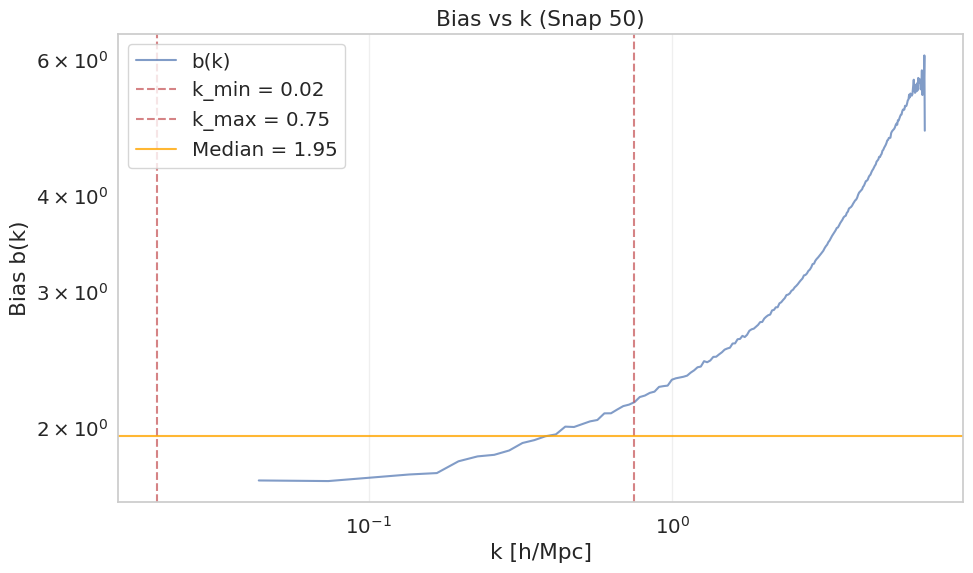

Bias in fit range [0.02, 0.75]: 1.948


In [11]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
import glob
import os

# Config
GRID = 256
BOXSIZE = 205.001
MAS = 'CIC'
SIREN_PATH = "/gpfs/nchugh/gw/results/"
DM_PATH = "/gpfs/nchugh/DMCOORDS/"
KMIN_FIT = 0.02
KMAX_FIT = 0.75
SNAP = 50

def load_and_process_siren_catalog(filepath):
    df = pd.read_pickle(filepath)
    x = df['x'].values / 1000.0
    y = df['y'].values / 1000.0
    z = df['z_pos'].values / 1000.0
    positions = np.vstack([x, y, z]).T.astype(np.float32)
    
    delta = np.zeros((GRID, GRID, GRID), dtype=np.float32)
    MASL.MA(positions, delta, BOXSIZE, MAS)
    delta /= np.mean(delta)
    delta -= 1.0
    return delta

def compute_power_spectrum(delta, boxsize, MAS):
    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    return Pk.k3D, Pk.Pk[:,0]

# Load one siren catalog
siren_files = glob.glob(os.path.join(SIREN_PATH, f"siren_cat_snap_{SNAP}_*.pkl"))
siren_file = siren_files[0]  # Just take the first one
print(f"Using: {os.path.basename(siren_file)}")

# Load DM field
dm_file = os.path.join(DM_PATH, f"field_256_{SNAP}.npy")
delta_dm = np.load(dm_file).astype(np.float32)

# Load siren field
delta_siren = load_and_process_siren_catalog(siren_file)

# Compute power spectra
k_siren, P_siren = compute_power_spectrum(delta_siren, BOXSIZE, MAS)
k_dm, P_dm = compute_power_spectrum(delta_dm, BOXSIZE, MAS)

# Compute bias
bias = np.sqrt(P_siren / P_dm)

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(k_siren, bias, 'b-', alpha=0.7, label='b(k)')
plt.axvline(KMIN_FIT, color='r', linestyle='--', alpha=0.7, label=f'k_min = {KMIN_FIT}')
plt.axvline(KMAX_FIT, color='r', linestyle='--', alpha=0.7, label=f'k_max = {KMAX_FIT}')
plt.axhline(np.median(bias[(k_siren >= KMIN_FIT) & (k_siren <= KMAX_FIT)]), 
            color='orange', linestyle='-', alpha=0.8, 
            label=f'Median = {np.median(bias[(k_siren >= KMIN_FIT) & (k_siren <= KMAX_FIT)]):.2f}')
plt.xlabel('k [h/Mpc]')
plt.ylabel('Bias b(k)')
plt.title(f'Bias vs k (Snap {SNAP})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Bias in fit range [{KMIN_FIT}, {KMAX_FIT}]: {np.median(bias[(k_siren >= KMIN_FIT) & (k_siren <= KMAX_FIT)]):.3f}")

In [12]:
import numpy as np
from scipy.optimize import curve_fit

def compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Improved bias fitting with multiple methods
    """
    
    # Find overlapping k range
    KMIN_FIT = 0.02
    KMAX_FIT = 0.75
    k_min = max(k_siren.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_siren.max(), k_dm.max(), KMAX_FIT)
    
    if k_max <= k_min:
        return np.nan, np.nan, np.nan, 0
    
    # Create common k grid
    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    
    # Interpolate to common grid
    P_siren_interp = np.interp(k_common, k_siren, P_siren)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_siren_interp = np.interp(k_common, k_siren, nmodes_siren)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)
    
    # Compute errors on power spectra
    err_siren = P_siren_interp / np.sqrt(2 * nmodes_siren_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    
    # Remove invalid points
    valid = (P_siren_interp > 0) & (P_dm_interp > 0) & np.isfinite(err_siren) & np.isfinite(err_dm) & (nmodes_siren_interp > 0)
    
    if np.sum(valid) < 3:
        return np.nan, np.nan, np.nan, np.sum(valid)
    
    k_fit = k_common[valid]
    P_siren_fit = P_siren_interp[valid]
    P_dm_fit = P_dm_interp[valid]
    err_siren_fit = err_siren[valid]
    err_dm_fit = err_dm[valid]
    
    if method == 'linear':
        return fit_linear_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'powerlaw':
        return fit_powerlaw_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'single_k':
        return fit_single_k_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    else:
        raise ValueError(f"Unknown method: {method}")

def fit_linear_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 + b1*k)^2 * P_dm
    This allows for scale-dependent bias
    """
    
    def model(k, b0, b1):
        bias_k = b0 + b1 * k
        return bias_k**2 * np.interp(k, k, P_dm)
    
    # Weights based on power spectrum errors
    weights = 1.0 / err_siren**2
    
    try:
        # Initial guess: constant bias around 1.5, small slope
        p0 = [1.5, 0.0]
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, b1 = popt
        b0_err, b1_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, b1)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2  # 2 parameters
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return effective bias at k=0.1 h/Mpc (typical scale)
        k_ref = 0.1
        bias_ref = b0 + b1 * k_ref
        # Error propagation for bias at k_ref
        bias_ref_err = np.sqrt(b0_err**2 + (k_ref * b1_err)**2)
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_powerlaw_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 * (k/k0)^alpha)^2 * P_dm
    Power-law scale dependence
    """
    
    k0 = 0.1  # Reference scale
    
    def model(k, b0, alpha):
        bias_k = b0 * (k / k0)**alpha
        return bias_k**2 * np.interp(k, k, P_dm)
    
    try:
        # Initial guess
        p0 = [1.5, 0.0]  # constant bias initially
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, alpha = popt
        b0_err, alpha_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, alpha)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return bias at reference scale
        bias_ref = b0  # This is bias at k0
        bias_ref_err = b0_err
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_single_k_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Use bias from a single k-mode (avoids averaging over scale-dependent bias)
    Choose k closest to 0.1 h/Mpc
    """
    
    k_target = 0.1
    idx = np.argmin(np.abs(k - k_target))
    
    bias = np.sqrt(P_siren[idx] / P_dm[idx])
    
    # Error propagation
    rel_err_siren = err_siren[idx] / P_siren[idx]
    rel_err_dm = err_dm[idx] / P_dm[idx]
    bias_err = 0.5 * bias * np.sqrt(rel_err_siren**2 + rel_err_dm**2)
    
    # No chi-squared since we're not fitting
    chi2_reduced = 1.0
    
    return bias, bias_err, chi2_reduced, 1

# Example usage - replace the compute_bias_and_fit function in your main code:

def compute_bias_and_fit_new(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Drop-in replacement for your existing function
    """
    return compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method)

# Test different methods:
# method='linear': allows bias to vary linearly with k
# method='powerlaw': allows bias to vary as power law in k  
# method='single_k': just uses bias at one k-mode, no averaging

In [13]:
import numpy as np
from scipy.optimize import curve_fit

def compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Improved bias fitting with multiple methods
    """
    
    # Find overlapping k range
    KMIN_FIT = 0.02
    KMAX_FIT = 0.75
    k_min = max(k_siren.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_siren.max(), k_dm.max(), KMAX_FIT)
    
    if k_max <= k_min:
        return np.nan, np.nan, np.nan, 0
    
    # Create common k grid
    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    
    # Interpolate to common grid
    P_siren_interp = np.interp(k_common, k_siren, P_siren)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_siren_interp = np.interp(k_common, k_siren, nmodes_siren)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)
    
    # Compute errors on power spectra
    err_siren = P_siren_interp / np.sqrt(2 * nmodes_siren_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    
    # Remove invalid points
    valid = (P_siren_interp > 0) & (P_dm_interp > 0) & np.isfinite(err_siren) & np.isfinite(err_dm) & (nmodes_siren_interp > 0)
    
    if np.sum(valid) < 3:
        return np.nan, np.nan, np.nan, np.sum(valid)
    
    k_fit = k_common[valid]
    P_siren_fit = P_siren_interp[valid]
    P_dm_fit = P_dm_interp[valid]
    err_siren_fit = err_siren[valid]
    err_dm_fit = err_dm[valid]
    
    if method == 'linear':
        return fit_linear_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'powerlaw':
        return fit_powerlaw_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'single_k':
        return fit_single_k_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    else:
        raise ValueError(f"Unknown method: {method}")

def fit_linear_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 + b1*k)^2 * P_dm
    This allows for scale-dependent bias
    """
    
    def model(k, b0, b1):
        bias_k = b0 + b1 * k
        return bias_k**2 * np.interp(k, k, P_dm)
    
    # Weights based on power spectrum errors
    weights = 1.0 / err_siren**2
    
    try:
        # Initial guess: constant bias around 1.5, small slope
        p0 = [1.5, 0.0]
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, b1 = popt
        b0_err, b1_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, b1)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2  # 2 parameters
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return effective bias at k=0.1 h/Mpc (typical scale)
        k_ref = 0.1
        bias_ref = b0 + b1 * k_ref
        # Error propagation for bias at k_ref
        bias_ref_err = np.sqrt(b0_err**2 + (k_ref * b1_err)**2)
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_powerlaw_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 * (k/k0)^alpha)^2 * P_dm
    Power-law scale dependence
    """
    
    k0 = 0.1  # Reference scale
    
    def model(k, b0, alpha):
        bias_k = b0 * (k / k0)**alpha
        return bias_k**2 * np.interp(k, k, P_dm)
    
    try:
        # Initial guess
        p0 = [1.5, 0.0]  # constant bias initially
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, alpha = popt
        b0_err, alpha_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, alpha)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return bias at reference scale
        bias_ref = b0  # This is bias at k0
        bias_ref_err = b0_err
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_single_k_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Use bias from a single k-mode (avoids averaging over scale-dependent bias)
    Choose k closest to 0.1 h/Mpc
    """
    
    k_target = 0.1
    idx = np.argmin(np.abs(k - k_target))
    
    bias = np.sqrt(P_siren[idx] / P_dm[idx])
    
    # Error propagation
    rel_err_siren = err_siren[idx] / P_siren[idx]
    rel_err_dm = err_dm[idx] / P_dm[idx]
    bias_err = 0.5 * bias * np.sqrt(rel_err_siren**2 + rel_err_dm**2)
    
    # No chi-squared since we're not fitting
    chi2_reduced = 1.0
    
    return bias, bias_err, chi2_reduced, 1

# Example usage - replace the compute_bias_and_fit function in your main code:

def compute_bias_and_fit_new(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Drop-in replacement for your existing function
    """
    return compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method)

# Test different methods:
# method='linear': allows bias to vary linearly with k
# method='powerlaw': allows bias to vary as power law in k  
# method='single_k': just uses bias at one k-mode, no averaging

In [14]:
def test_methods(snap=50):
    """Test all methods on one catalog"""
    
    print(f"Testing bias fitting methods on snapshot {snap}")
    
    # Load data
    siren_files = glob.glob(os.path.join(SIREN_PATH, f"siren_cat_snap_{snap}_*.pkl"))
    if len(siren_files) == 0:
        print(f"No files found for snapshot {snap}")
        return
    
    siren_file = siren_files[0]
    dm_file = os.path.join(DM_PATH, f"field_256_{snap}.npy")
    
    print(f"Using: {os.path.basename(siren_file)}")
    
    # Load fields
    delta_siren = load_and_process_siren_catalog(siren_file)
    delta_dm = np.load(dm_file).astype(np.float32)
    
    # Compute power spectra
    k_siren, P_siren, nmodes_siren = compute_power_spectrum(delta_siren, BOXSIZE, MAS)
    k_dm, P_dm, nmodes_dm = compute_power_spectrum(delta_dm, BOXSIZE, MAS)
    
    print("\nTesting different methods:")
    print("-" * 60)
    
    # Test original method
    bias_orig, err_orig, chi2_orig, npts_orig = compute_bias_and_fit_original(
        k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm)
    
    print(f"Original (weighted avg): bias = {bias_orig:.3f} ± {err_orig:.3f}, χ²ᵣ = {chi2_orig:.2f}")
    
    # Test new methods
    methods = ['linear', 'single_k']
    
    for method in methods:
        try:
            bias_new, err_new, chi2_new, npts_new = compute_bias_improved(
                k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method=method)
            print(f"{method:12s}: bias = {bias_new:.3f} ± {err_new:.3f}, χ²ᵣ = {chi2_new:.2f}")
        except Exception as e:
            print(f"{method:12s}: FAILED - {e}")
    
    # Plot bias(k) for reference
    bias_k = np.sqrt(P_siren / P_dm)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(k_siren, bias_k, 'b-', alpha=0.7, label='b(k) measured')
    plt.axhline(bias_orig, color='red', linestyle='--', label=f'Original fit: {bias_orig:.3f}')
    plt.axvline(0.02, color='gray', linestyle=':', alpha=0.7)
    plt.axvline(0.75, color='gray', linestyle=':', alpha=0.7)
    plt.xlabel('k [h/Mpc]')
    plt.ylabel('Bias b(k)')
    plt.title(f'Bias vs k (Snap {snap}) - Method Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'original': (bias_orig, err_orig, chi2_orig),
        'k_data': k_siren,
        'bias_data': bias_k
    }

# Run the test
if __name__ == "__main__":
    # Test on snapshot 50 (the problematic one)
    results_50 = test_methods(snap=50)
    
    # Test on snapshot 99 (the good one)  
    results_99 = test_methods(snap=99)

Testing bias fitting methods on snapshot 50
Using: siren_cat_snap_50_dl_1.30_dh_3.33_mc_22.758.pkl

Computing power spectrum of the field...
Time to complete loop = 0.83
Time taken = 1.06 seconds


ValueError: not enough values to unpack (expected 3, got 2)

Testing bias fitting methods on snapshot 50
Using: siren_cat_snap_50_dl_1.30_dh_3.33_mc_22.758.pkl

Computing power spectrum of the field...
Time to complete loop = 0.82
Time taken = 1.05 seconds

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.04 seconds

Testing different methods:
------------------------------------------------------------
Original (weighted avg): bias = 2.021 ± 0.010, χ²ᵣ = 12.95
linear      : bias = 1.747 ± 0.019, χ²ᵣ = 0.29
single_k    : bias = 1.715 ± 0.103, χ²ᵣ = 1.00


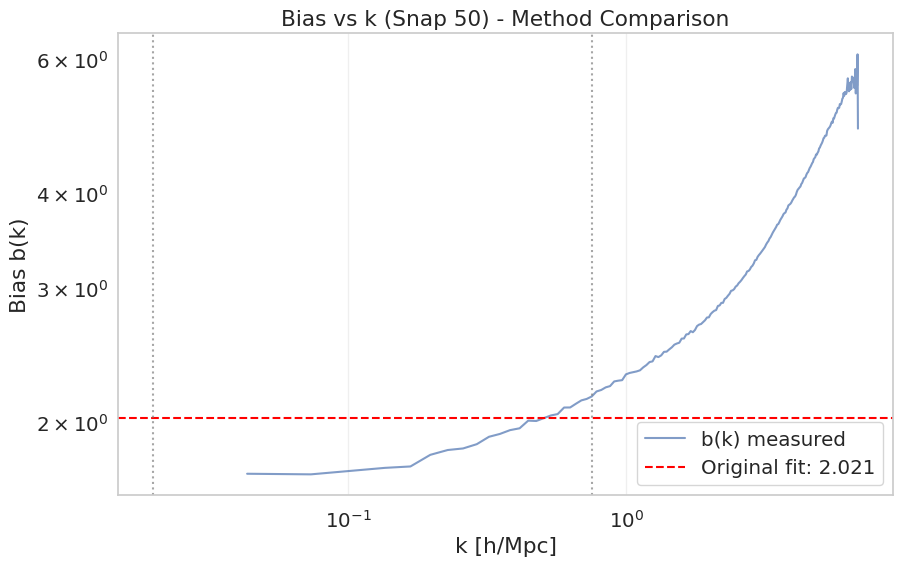

Testing bias fitting methods on snapshot 99
Using: siren_cat_snap_99_dl_1.10_dh_3.33_mc_0.164.pkl

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.04 seconds

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds

Testing different methods:
------------------------------------------------------------
Original (weighted avg): bias = 1.195 ± 0.006, χ²ᵣ = 0.84
linear      : bias = 1.153 ± 0.012, χ²ᵣ = 0.21
single_k    : bias = 1.161 ± 0.070, χ²ᵣ = 1.00


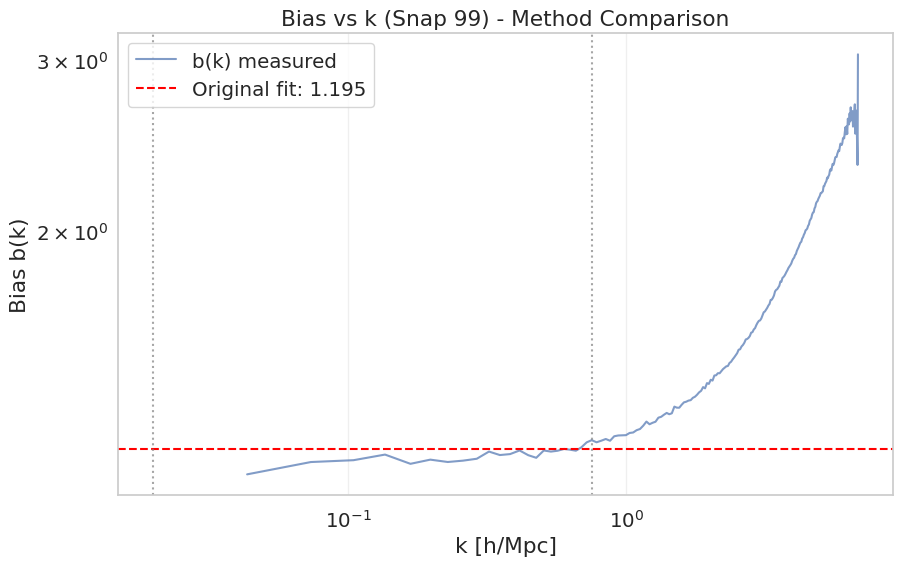

In [15]:
#!/usr/bin/env python3
"""
Quick test script to compare different bias fitting methods
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MAS_library as MASL
import Pk_library as PKL
import glob
import os
from scipy.optimize import curve_fit

# Your original config
GRID = 256
BOXSIZE = 205.001
MAS = 'CIC'
SIREN_PATH = "/gpfs/nchugh/gw/results/"
DM_PATH = "/gpfs/nchugh/DMCOORDS/"

# Put the improved fitting functions here (copy from previous artifact)
def compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Improved bias fitting with multiple methods
    """
    
    # Find overlapping k range
    KMIN_FIT = 0.02
    KMAX_FIT = 0.75
    k_min = max(k_siren.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_siren.max(), k_dm.max(), KMAX_FIT)
    
    if k_max <= k_min:
        return np.nan, np.nan, np.nan, 0
    
    # Create common k grid
    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    
    # Interpolate to common grid
    P_siren_interp = np.interp(k_common, k_siren, P_siren)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_siren_interp = np.interp(k_common, k_siren, nmodes_siren)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)
    
    # Compute errors on power spectra
    err_siren = P_siren_interp / np.sqrt(2 * nmodes_siren_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    
    # Remove invalid points
    valid = (P_siren_interp > 0) & (P_dm_interp > 0) & np.isfinite(err_siren) & np.isfinite(err_dm) & (nmodes_siren_interp > 0)
    
    if np.sum(valid) < 3:
        return np.nan, np.nan, np.nan, np.sum(valid)
    
    k_fit = k_common[valid]
    P_siren_fit = P_siren_interp[valid]
    P_dm_fit = P_dm_interp[valid]
    err_siren_fit = err_siren[valid]
    err_dm_fit = err_dm[valid]
    
    if method == 'linear':
        return fit_linear_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'powerlaw':
        return fit_powerlaw_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    elif method == 'single_k':
        return fit_single_k_bias(k_fit, P_siren_fit, P_dm_fit, err_siren_fit, err_dm_fit)
    else:
        raise ValueError(f"Unknown method: {method}")

def fit_linear_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 + b1*k)^2 * P_dm
    This allows for scale-dependent bias
    """
    
    def model(k, b0, b1):
        bias_k = b0 + b1 * k
        return bias_k**2 * np.interp(k, k, P_dm)
    
    # Weights based on power spectrum errors
    weights = 1.0 / err_siren**2
    
    try:
        # Initial guess: constant bias around 1.5, small slope
        p0 = [1.5, 0.0]
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, b1 = popt
        b0_err, b1_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, b1)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2  # 2 parameters
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return effective bias at k=0.1 h/Mpc (typical scale)
        k_ref = 0.1
        bias_ref = b0 + b1 * k_ref
        # Error propagation for bias at k_ref
        bias_ref_err = np.sqrt(b0_err**2 + (k_ref * b1_err)**2)
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_powerlaw_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Fit: P_siren = (b0 * (k/k0)^alpha)^2 * P_dm
    Power-law scale dependence
    """
    
    k0 = 0.1  # Reference scale
    
    def model(k, b0, alpha):
        bias_k = b0 * (k / k0)**alpha
        return bias_k**2 * np.interp(k, k, P_dm)
    
    try:
        # Initial guess
        p0 = [1.5, 0.0]  # constant bias initially
        popt, pcov = curve_fit(model, k, P_siren, p0=p0, sigma=err_siren, absolute_sigma=True)
        
        b0, alpha = popt
        b0_err, alpha_err = np.sqrt(np.diag(pcov))
        
        # Compute chi-squared
        model_pred = model(k, b0, alpha)
        chi2 = np.sum(((P_siren - model_pred) / err_siren)**2)
        dof = len(k) - 2
        chi2_reduced = chi2 / dof if dof > 0 else np.inf
        
        # Return bias at reference scale
        bias_ref = b0  # This is bias at k0
        bias_ref_err = b0_err
        
        return bias_ref, bias_ref_err, chi2_reduced, len(k)
        
    except:
        return np.nan, np.nan, np.nan, len(k)

def fit_single_k_bias(k, P_siren, P_dm, err_siren, err_dm):
    """
    Use bias from a single k-mode (avoids averaging over scale-dependent bias)
    Choose k closest to 0.1 h/Mpc
    """
    
    k_target = 0.1
    idx = np.argmin(np.abs(k - k_target))
    
    bias = np.sqrt(P_siren[idx] / P_dm[idx])
    
    # Error propagation
    rel_err_siren = err_siren[idx] / P_siren[idx]
    rel_err_dm = err_dm[idx] / P_dm[idx]
    bias_err = 0.5 * bias * np.sqrt(rel_err_siren**2 + rel_err_dm**2)
    
    # No chi-squared since we're not fitting
    chi2_reduced = 1.0
    
    return bias, bias_err, chi2_reduced, 1

# Example usage - replace the compute_bias_and_fit function in your main code:

def compute_bias_and_fit_new(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method='linear'):
    """
    Drop-in replacement for your existing function
    """
    return compute_bias_improved(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method)

# Test different methods:
# method='linear': allows bias to vary linearly with k
# method='powerlaw': allows bias to vary as power law in k  
# method='single_k': just uses bias at one k-mode, no averaging

# Your original functions
def load_and_process_siren_catalog(filepath):
    df = pd.read_pickle(filepath)
    x = df['x'].values / 1000.0
    y = df['y'].values / 1000.0
    z = df['z_pos'].values / 1000.0
    positions = np.vstack([x, y, z]).T.astype(np.float32)
    
    delta = np.zeros((GRID, GRID, GRID), dtype=np.float32)
    MASL.MA(positions, delta, BOXSIZE, MAS)
    delta /= np.mean(delta)
    delta -= 1.0
    return delta

def compute_power_spectrum(delta, boxsize, MAS):
    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    return Pk.k3D, Pk.Pk[:,0], Pk.Nmodes3D

def compute_bias_and_fit_original(k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm):
    """Your original method for comparison"""
    KMIN_FIT = 0.02
    KMAX_FIT = 0.75
    
    k_min = max(k_siren.min(), k_dm.min(), KMIN_FIT)
    k_max = min(k_siren.max(), k_dm.max(), KMAX_FIT)
    
    if k_max <= k_min:
        return np.nan, np.nan, np.nan, 0
    
    k_common = np.logspace(np.log10(k_min), np.log10(k_max), 15)
    P_siren_interp = np.interp(k_common, k_siren, P_siren)
    P_dm_interp = np.interp(k_common, k_dm, P_dm)
    nmodes_siren_interp = np.interp(k_common, k_siren, nmodes_siren)
    nmodes_dm_interp = np.interp(k_common, k_dm, nmodes_dm)
    
    bias = np.sqrt(P_siren_interp / P_dm_interp)
    err_siren = P_siren_interp / np.sqrt(2 * nmodes_siren_interp + 1e-10)
    err_dm = P_dm_interp / np.sqrt(2 * nmodes_dm_interp + 1e-10)
    err_bias = 0.5 * bias * np.sqrt((err_siren / P_siren_interp)**2 + (err_dm / P_dm_interp)**2)
    
    valid = np.isfinite(bias) & np.isfinite(err_bias) & (err_bias > 0) & (nmodes_siren_interp > 0)
    
    if np.sum(valid) < 3:
        return np.nan, np.nan, np.nan, np.sum(valid)
    
    k_fit = k_common[valid]
    bias_fit = bias[valid]
    err_fit = err_bias[valid]
    
    weights = 1.0 / err_fit**2
    bias_mean = np.sum(weights * bias_fit) / np.sum(weights)
    bias_error = 1.0 / np.sqrt(np.sum(weights))
    
    chi2 = np.sum(weights * (bias_fit - bias_mean)**2)
    dof = len(bias_fit) - 1
    chi2_reduced = chi2 / dof if dof > 0 else np.inf
    
    return bias_mean, bias_error, chi2_reduced, len(k_fit)

def test_methods(snap=50):
    """Test all methods on one catalog"""
    
    print(f"Testing bias fitting methods on snapshot {snap}")
    
    # Load data
    siren_files = glob.glob(os.path.join(SIREN_PATH, f"siren_cat_snap_{snap}_*.pkl"))
    if len(siren_files) == 0:
        print(f"No files found for snapshot {snap}")
        return
    
    siren_file = siren_files[0]
    dm_file = os.path.join(DM_PATH, f"field_256_{snap}.npy")
    
    print(f"Using: {os.path.basename(siren_file)}")
    
    # Load fields
    delta_siren = load_and_process_siren_catalog(siren_file)
    delta_dm = np.load(dm_file).astype(np.float32)
    
    # Compute power spectra
    k_siren, P_siren, nmodes_siren = compute_power_spectrum(delta_siren, BOXSIZE, MAS)
    k_dm, P_dm, nmodes_dm = compute_power_spectrum(delta_dm, BOXSIZE, MAS)
    
    print("\nTesting different methods:")
    print("-" * 60)
    
    # Test original method
    bias_orig, err_orig, chi2_orig, npts_orig = compute_bias_and_fit_original(
        k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm)
    
    print(f"Original (weighted avg): bias = {bias_orig:.3f} ± {err_orig:.3f}, χ²ᵣ = {chi2_orig:.2f}")
    
    # Test new methods
    methods = ['linear', 'single_k']
    
    for method in methods:
        try:
            bias_new, err_new, chi2_new, npts_new = compute_bias_improved(
                k_siren, P_siren, k_dm, P_dm, nmodes_siren, nmodes_dm, method=method)
            print(f"{method:12s}: bias = {bias_new:.3f} ± {err_new:.3f}, χ²ᵣ = {chi2_new:.2f}")
        except Exception as e:
            print(f"{method:12s}: FAILED - {e}")
    
    # Plot bias(k) for reference
    bias_k = np.sqrt(P_siren / P_dm)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(k_siren, bias_k, 'b-', alpha=0.7, label='b(k) measured')
    plt.axhline(bias_orig, color='red', linestyle='--', label=f'Original fit: {bias_orig:.3f}')
    plt.axvline(0.02, color='gray', linestyle=':', alpha=0.7)
    plt.axvline(0.75, color='gray', linestyle=':', alpha=0.7)
    plt.xlabel('k [h/Mpc]')
    plt.ylabel('Bias b(k)')
    plt.title(f'Bias vs k (Snap {snap}) - Method Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'original': (bias_orig, err_orig, chi2_orig),
        'k_data': k_siren,
        'bias_data': bias_k
    }

# Run the test
if __name__ == "__main__":
    # Test on snapshot 50 (the problematic one)
    results_50 = test_methods(snap=50)
    
    # Test on snapshot 99 (the good one)  
    results_99 = test_methods(snap=99)

LOADING AND INSPECTING DATA
✓ Successfully loaded: /gpfs/nchugh/gw/bias_results_linear/siren_bias_linear_results_all_snapshots.pkl
✓ Data shape: (2400, 9)
✓ Columns: ['snap', 'mc', 'dl', 'dh', 'n_sirens', 'bias', 'bias_error', 'chi2_reduced', 'n_fit_points']

BASIC DATA SUMMARY
Total records: 2400
Snapshots: [50, 55, 60, 65, 70, 75, 80, 85, 90, 99]
Snapshot counts: {50: 240, 55: 240, 60: 240, 65: 240, 70: 240, 75: 240, 80: 240, 85: 240, 90: 240, 99: 240}

Data quality:
  Records with finite bias: 2400/2400
  Records with finite bias_error: 2400/2400
  Records with χ²<10: 2400/2400
  Records with χ²<100: 2400/2400

IDENTICAL ERROR DIAGNOSTIC
Valid records for analysis: 2400/2400

ERROR UNIQUENESS:
  Total valid records: 2400
  Unique bias error values: 2400
  Uniqueness ratio: 1.000
✓ Errors appear to have reasonable diversity

ERROR PATTERN ANALYSIS
Error patterns by snapshot:
  Snapshot 50: 240 records, 240 unique errors
  Snapshot 55: 240 records, 240 unique errors
  Snapshot 60: 240

ValueError: num must be an integer with 1 <= num <= 4, not 5

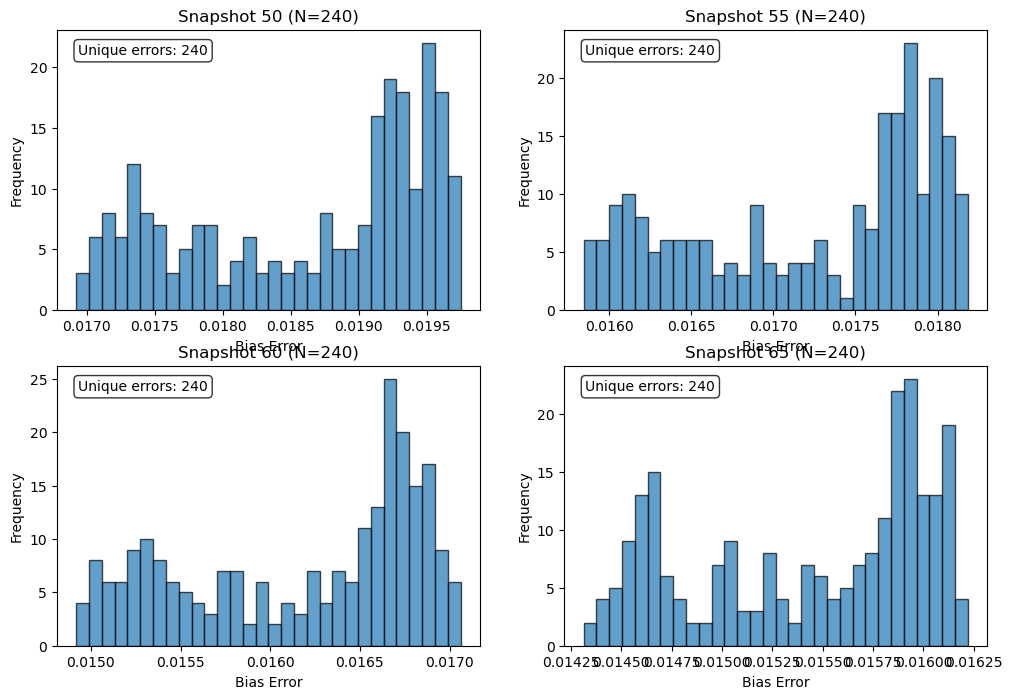

In [1]:
#!/usr/bin/env python3
"""
Diagnostic script to analyze identical bias errors in siren analysis results
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_and_inspect_data(filepath):
    """Load the pkl file and perform basic inspection"""
    print("="*60)
    print("LOADING AND INSPECTING DATA")
    print("="*60)
    
    try:
        df = pd.read_pickle(filepath)
        print(f"✓ Successfully loaded: {filepath}")
        print(f"✓ Data shape: {df.shape}")
        print(f"✓ Columns: {list(df.columns)}")
        
        return df
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None

def basic_data_summary(df):
    """Print basic summary statistics"""
    print("\n" + "="*60)
    print("BASIC DATA SUMMARY")
    print("="*60)
    
    print(f"Total records: {len(df)}")
    print(f"Snapshots: {sorted(df['snap'].unique())}")
    print(f"Snapshot counts: {df['snap'].value_counts().sort_index().to_dict()}")
    
    # Check for missing/invalid data
    print(f"\nData quality:")
    print(f"  Records with finite bias: {np.isfinite(df['bias']).sum()}/{len(df)}")
    print(f"  Records with finite bias_error: {np.isfinite(df['bias_error']).sum()}/{len(df)}")
    print(f"  Records with χ²<10: {(df['chi2_reduced'] < 10).sum()}/{len(df)}")
    print(f"  Records with χ²<100: {(df['chi2_reduced'] < 100).sum()}/{len(df)}")

def diagnose_identical_errors(df):
    """Main diagnostic function for identical errors"""
    print("\n" + "="*60)
    print("IDENTICAL ERROR DIAGNOSTIC")
    print("="*60)
    
    # Filter to valid results
    valid_mask = np.isfinite(df['bias']) & np.isfinite(df['bias_error'])
    df_valid = df[valid_mask].copy()
    
    print(f"Valid records for analysis: {len(df_valid)}/{len(df)}")
    
    if len(df_valid) == 0:
        print("❌ No valid records to analyze!")
        return
    
    # Check uniqueness of errors
    unique_errors = df_valid['bias_error'].nunique()
    total_valid = len(df_valid)
    
    print(f"\nERROR UNIQUENESS:")
    print(f"  Total valid records: {total_valid}")
    print(f"  Unique bias error values: {unique_errors}")
    print(f"  Uniqueness ratio: {unique_errors/total_valid:.3f}")
    
    if unique_errors == 1:
        print("❌ ALL ERRORS ARE IDENTICAL!")
        error_value = df_valid['bias_error'].iloc[0]
        print(f"  Common error value: {error_value:.8f}")
        
        # Check if this might be a default/fallback value
        if abs(error_value - 0.1) < 1e-6:
            print("  ^ This looks like a default fallback value (0.1)")
        elif abs(error_value - 1.0) < 1e-6:
            print("  ^ This looks like a default fallback value (1.0)")
            
    elif unique_errors < 5:
        print("⚠️  Very few unique error values!")
        error_values = sorted(df_valid['bias_error'].unique())
        print(f"  Unique error values: {error_values}")
        
        # Show frequency of each error value
        error_counts = df_valid['bias_error'].value_counts()
        print(f"  Error value frequencies:")
        for val, count in error_counts.items():
            print(f"    {val:.8f}: {count} records ({count/total_valid*100:.1f}%)")
    
    else:
        print("✓ Errors appear to have reasonable diversity")
    
    return df_valid

def analyze_error_patterns(df_valid):
    """Analyze patterns in the error values"""
    print("\n" + "="*60)
    print("ERROR PATTERN ANALYSIS")
    print("="*60)
    
    # Group by snapshot
    print("Error patterns by snapshot:")
    for snap in sorted(df_valid['snap'].unique()):
        snap_data = df_valid[df_valid['snap'] == snap]
        unique_errors_snap = snap_data['bias_error'].nunique()
        print(f"  Snapshot {snap}: {len(snap_data)} records, {unique_errors_snap} unique errors")
        
        if unique_errors_snap == 1:
            print(f"    ^ ALL IDENTICAL: {snap_data['bias_error'].iloc[0]:.8f}")
    
    # Check correlation with other variables
    print(f"\nCorrelations with bias_error:")
    numeric_cols = ['bias', 'chi2_reduced', 'n_fit_points', 'n_sirens', 'mc', 'dl', 'dh']
    
    for col in numeric_cols:
        if col in df_valid.columns:
            corr = df_valid[['bias_error', col]].corr().iloc[0,1]
            if abs(corr) > 0.1:  # Only show meaningful correlations
                print(f"  {col:15s}: {corr:6.3f}")

def analyze_fitting_quality(df_valid):
    """Analyze the quality of fits to understand error patterns"""
    print("\n" + "="*60)
    print("FITTING QUALITY ANALYSIS")
    print("="*60)
    
    # Chi-squared analysis
    chi2_stats = df_valid['chi2_reduced'].describe()
    print("Chi-squared reduced statistics:")
    for stat, value in chi2_stats.items():
        print(f"  {stat:8s}: {value:8.3f}")
    
    # Identify likely fallback cases
    very_high_chi2 = df_valid['chi2_reduced'] > 100
    infinite_chi2 = ~np.isfinite(df_valid['chi2_reduced'])
    likely_fallback = very_high_chi2 | infinite_chi2
    
    print(f"\nLikely fallback method usage:")
    print(f"  χ² > 100: {very_high_chi2.sum()}/{len(df_valid)} ({very_high_chi2.sum()/len(df_valid)*100:.1f}%)")
    print(f"  χ² = inf/nan: {infinite_chi2.sum()}/{len(df_valid)} ({infinite_chi2.sum()/len(df_valid)*100:.1f}%)")
    print(f"  Total fallback: {likely_fallback.sum()}/{len(df_valid)} ({likely_fallback.sum()/len(df_valid)*100:.1f}%)")
    
    if likely_fallback.sum() > 0:
        print(f"\nFallback cases error analysis:")
        fallback_errors = df_valid[likely_fallback]['bias_error']
        print(f"  Unique errors in fallback cases: {fallback_errors.nunique()}")
        if fallback_errors.nunique() == 1:
            print(f"  ^ ALL FALLBACK ERRORS IDENTICAL: {fallback_errors.iloc[0]:.8f}")
    
    # N fit points analysis
    npoints_stats = df_valid['n_fit_points'].describe()
    print(f"\nFit points statistics:")
    for stat, value in npoints_stats.items():
        print(f"  {stat:8s}: {value:8.1f}")
    
    unique_npoints = df_valid['n_fit_points'].nunique()
    if unique_npoints == 1:
        print(f"❌ ALL FITS USE IDENTICAL NUMBER OF POINTS: {df_valid['n_fit_points'].iloc[0]}")
        print("   ^ This suggests fixed k-grid interpolation issue!")

def create_diagnostic_plots(df_valid, output_dir="diagnostic_plots"):
    """Create diagnostic plots"""
    print(f"\n" + "="*60)
    print("CREATING DIAGNOSTIC PLOTS")
    print("="*60)
    
    Path(output_dir).mkdir(exist_ok=True)
    
    # Plot 1: Error distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df_valid['bias_error'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Bias Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Bias Errors')
    plt.yscale('log')
    
    plt.subplot(1, 3, 2)
    plt.scatter(df_valid['bias'], df_valid['bias_error'], alpha=0.6, s=20)
    plt.xlabel('Bias')
    plt.ylabel('Bias Error')
    plt.title('Bias vs Bias Error')
    
    plt.subplot(1, 3, 3)
    plt.scatter(df_valid['chi2_reduced'], df_valid['bias_error'], alpha=0.6, s=20)
    plt.xlabel('Chi-squared Reduced')
    plt.ylabel('Bias Error')
    plt.xscale('log')
    plt.title('Chi² vs Bias Error')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/error_diagnostics.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Error by snapshot
    plt.figure(figsize=(12, 8))
    
    snapshots = sorted(df_valid['snap'].unique())
    for i, snap in enumerate(snapshots):
        snap_data = df_valid[df_valid['snap'] == snap]
        plt.subplot(2, 2, i+1)
        plt.hist(snap_data['bias_error'], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Bias Error')
        plt.ylabel('Frequency')
        plt.title(f'Snapshot {snap} (N={len(snap_data)})')
        
        # Add statistics
        unique_errs = snap_data['bias_error'].nunique()
        plt.text(0.05, 0.95, f'Unique errors: {unique_errs}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/error_by_snapshot.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 3: Quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Chi2 distribution
    axes[0,0].hist(np.log10(df_valid['chi2_reduced'] + 1e-10), bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('log₁₀(χ² reduced)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Chi² Distribution')
    
    # N fit points
    axes[0,1].hist(df_valid['n_fit_points'], bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('N Fit Points')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Number of Fit Points')
    
    # N sirens
    axes[0,2].hist(np.log10(df_valid['n_sirens']), bins=50, alpha=0.7, edgecolor='black')
    axes[0,2].set_xlabel('log₁₀(N Sirens)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Sample Size Distribution')
    
    # Parameter ranges
    axes[1,0].scatter(df_valid['mc'], df_valid['bias_error'], alpha=0.6, s=20)
    axes[1,0].set_xlabel('mc')
    axes[1,0].set_ylabel('Bias Error')
    axes[1,0].set_title('mc vs Error')
    
    axes[1,1].scatter(df_valid['dl'], df_valid['bias_error'], alpha=0.6, s=20)
    axes[1,1].set_xlabel('dl')
    axes[1,1].set_ylabel('Bias Error')
    axes[1,1].set_title('dl vs Error')
    
    axes[1,2].scatter(df_valid['dh'], df_valid['bias_error'], alpha=0.6, s=20)
    axes[1,2].set_xlabel('dh')
    axes[1,2].set_ylabel('Bias Error')
    axes[1,2].set_title('dh vs Error')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/quality_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Diagnostic plots saved to {output_dir}/")

def identify_root_cause(df_valid):
    """Try to identify the root cause of identical errors"""
    print("\n" + "="*60)
    print("ROOT CAUSE ANALYSIS")
    print("="*60)
    
    # Check for the most likely causes
    unique_errors = df_valid['bias_error'].nunique()
    unique_npoints = df_valid['n_fit_points'].nunique()
    likely_fallback = ((df_valid['chi2_reduced'] > 100) | 
                      (~np.isfinite(df_valid['chi2_reduced']))).sum()
    total_records = len(df_valid)
    
    print("DIAGNOSIS:")
    
    if unique_errors == 1:
        error_val = df_valid['bias_error'].iloc[0]
        print(f"❌ ROOT CAUSE: ALL {total_records} ERRORS ARE IDENTICAL ({error_val:.8f})")
        
        if unique_npoints == 1:
            print("  → LIKELY CAUSE: Fixed k-grid interpolation")
            print("    All fits use same k-points → similar covariance matrices → identical errors")
            
        if likely_fallback > total_records * 0.8:
            print("  → LIKELY CAUSE: Fallback method bug")
            print("    Most fits failing → using fallback with incorrect error calculation")
            
        if abs(error_val - 0.1) < 1e-6 or abs(error_val - 1.0) < 1e-6:
            print("  → LIKELY CAUSE: Hardcoded fallback error value")
            
    elif unique_errors < 0.1 * total_records:
        print(f"⚠️  ROOT CAUSE: Too few unique errors ({unique_errors}/{total_records})")
        print("  → LIKELY CAUSE: Quantized error calculation or limited precision")
    
    print(f"\nRECOMMENDED FIXES:")
    print(f"1. Fix line ~143 in fallback method: use nmodes_dm instead of nmodes_siren")
    print(f"2. Use adaptive k-grid instead of fixed interpolation")
    print(f"3. Add debugging output to see which code path is being used")
    print(f"4. Check if covariance matrix calculation is correct")

def main():
    # File path
    filepath = "/gpfs/nchugh/gw/bias_results_linear/siren_bias_linear_results_all_snapshots.pkl"
    
    # Load data
    df = load_and_inspect_data(filepath)
    if df is None:
        return
    
    # Basic summary
    basic_data_summary(df)
    
    # Main diagnostics
    df_valid = diagnose_identical_errors(df)
    if df_valid is not None and len(df_valid) > 0:
        analyze_error_patterns(df_valid)
        analyze_fitting_quality(df_valid)
        create_diagnostic_plots(df_valid)
        identify_root_cause(df_valid)
    
    print(f"\n" + "="*60)
    print("DIAGNOSTIC COMPLETE")
    print("="*60)
    print("Check the diagnostic_plots/ directory for visualizations.")

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd

df = pd.read_pickle("/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_2.00_mc_0.100.pkl")
print(df.head())

         SubhaloFlag  stellar_mass       sfr           x          y  \
1764932         True      0.193771  2.262020  151426.330  180443.78   
1258078         True      0.617908  1.155314  171280.750  183860.86   
1755531         True      0.110255  0.883112   98353.055  136537.80   
1410191         True      0.456496  1.689505   52793.360  160830.20   
1503683         True      0.200837  2.317706  181857.640  155896.48   

              z_pos    z  metallicity        m1   m2  chirp_mass  delta_l  \
1764932   24668.254  1.0     0.011337  1.038521  5.0    1.875189      0.9   
1258078   77617.080  1.0     0.021747  1.260628  5.0    2.091272      0.9   
1755531   63980.240  1.0     0.009161  1.590352  5.0    2.379558      0.9   
1410191   30917.500  1.0     0.015769  1.910037  5.0    2.630941      0.9   
1503683  177755.470  1.0     0.009874  1.310249  5.0    2.136904      0.9   

         delta_h  M_c  snapshot  
1764932      2.0  0.1        50  
1258078      2.0  0.1        50  
1755531 

Loading and processing data...
Found 2400 files matching pattern
Processing /gpfs/nchugh/gw/results/siren_cat_snap_85_dl_1.10_dh_2.67_mc_0.720.pkl: 78081 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_50_dl_1.30_dh_3.33_mc_22.758.pkl: 71516 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_65_dl_0.90_dh_2.00_mc_1.179.pkl: 80872 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_85_dl_1.10_dh_4.00_mc_5.179.pkl: 78081 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_90_dl_1.30_dh_2.00_mc_0.720.pkl: 76803 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_65_dl_1.10_dh_4.00_mc_1.179.pkl: 80872 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_55_dl_1.30_dh_2.67_mc_1.179.pkl: 77069 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_99_dl_1.10_dh_3.33_mc_0.164.pkl: 74518 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_90_dl_1.50_dh_4.00_mc_8.483.pkl: 76803 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_50_dl_1.50_dh_4.00_mc_1.931.pkl: 71516

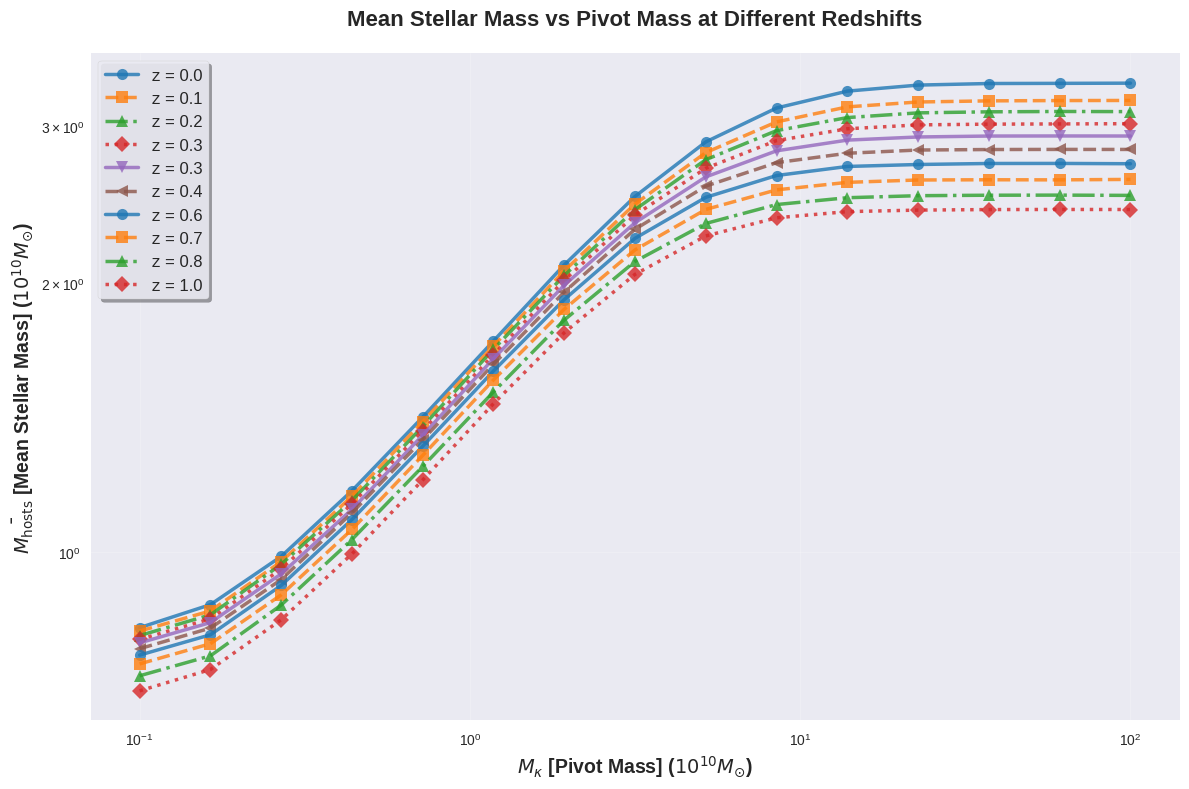


Summary:
Number of redshifts: 10
z = 0.0: 15 pivot mass values
z = 0.11: 15 pivot mass values
z = 0.18: 15 pivot mass values
z = 0.26: 15 pivot mass values
z = 0.35: 15 pivot mass values
z = 0.44: 15 pivot mass values
z = 0.55: 15 pivot mass values
z = 0.68: 15 pivot mass values
z = 0.82: 15 pivot mass values
z = 1.0: 15 pivot mass values


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from collections import defaultdict
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_process_data(file_pattern):
    """
    Load all pickle files matching the pattern and process the data
    """
    files = glob.glob(file_pattern)
    print(f"Found {len(files)} files matching pattern")
    
    # Dictionary to store data grouped by redshift and M_c
    data_dict = defaultdict(list)
    
    for file_path in files:
        try:
            # Load the pickle file
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            
            print(f"Processing {file_path}: {len(df)} rows")
            
            # Group by redshift (z) and pivot mass (M_c), then calculate mean stellar mass
            grouped = df.groupby(['z', 'M_c'])['stellar_mass'].mean().reset_index()
            
            # Store the data
            for _, row in grouped.iterrows():
                data_dict[(row['z'], row['M_c'])].append(row['stellar_mass'])
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return data_dict

def calculate_mean_stellar_mass(data_dict):
    """
    Calculate the mean stellar mass averaged over all delta_l and delta_h values
    """
    result_dict = defaultdict(lambda: defaultdict(list))
    
    for (z, mc), stellar_masses in data_dict.items():
        # Average over all delta_l and delta_h combinations for this z and M_c
        mean_stellar_mass = np.mean(stellar_masses)
        result_dict[z][mc].append(mean_stellar_mass)
    
    # Final averaging
    final_dict = {}
    for z in result_dict:
        final_dict[z] = {}
        for mc in result_dict[z]:
            final_dict[z][mc] = np.mean(result_dict[z][mc])
    
    return final_dict

def create_plot(final_dict):
    """
    Create an aesthetically pleasing plot
    """
    plt.figure(figsize=(12, 8))
    
    # Define colors and line styles for different redshifts
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    line_styles = ['-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    # Sort redshifts for consistent plotting
    redshifts = sorted(final_dict.keys())
    
    for i, z in enumerate(redshifts):
        # Extract M_c and corresponding mean stellar masses
        mc_values = []
        stellar_masses = []
        
        for mc in sorted(final_dict[z].keys()):
            mc_values.append(mc)
            stellar_masses.append(final_dict[z][mc])
        
        # Convert to numpy arrays for easier handling
        mc_values = np.array(mc_values)
        stellar_masses = np.array(stellar_masses)
        
        # Plot the data
        plt.plot(mc_values, stellar_masses, 
                color=colors[i % len(colors)],
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markersize=8,
                linewidth=2.5,
                alpha=0.8,
                label=f'z = {z:.1f}')
    
    # Customize the plot
    plt.xlabel(r'$M_{{\kappa}}$ [Pivot Mass] ($10^{10} M_{\odot}$)', fontsize=14, fontweight='bold')
    plt.ylabel(r'$\bar{M_{\mathrm{hosts}}}$ [Mean Stellar Mass] ($10^{10} M_{\odot}$)', fontsize=14, fontweight='bold')
    plt.title('Mean Stellar Mass vs Pivot Mass at Different Redshifts', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Set log scale if needed (uncomment if your data spans multiple orders of magnitude)
    plt.xscale('log')
    plt.yscale('log')
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Customize legend
    plt.legend(frameon=True, fancybox=True, shadow=True, 
              framealpha=0.9, fontsize=12, loc='best')
    
    # Adjust layout
    plt.tight_layout()
    
    # Add some styling touches
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    return plt

def main():
    """
    Main function to execute the analysis
    """
    # File pattern for the pickle files
    file_pattern = "/gpfs/nchugh/gw/results/siren_cat_snap_*_dl_*_dh_*_mc_*.pkl"
    
    print("Loading and processing data...")
    data_dict = load_and_process_data(file_pattern)
    
    if not data_dict:
        print("No data found! Please check the file pattern and directory.")
        return
    
    print("Calculating mean stellar masses...")
    final_dict = calculate_mean_stellar_mass(data_dict)
    
    print("Creating plot...")
    plt = create_plot(final_dict)
    
    # Save the plot
    output_filename = "stellar_mass_vs_pivot_mass.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"Plot saved as {output_filename}")
    
    # Display the plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary:")
    print(f"Number of redshifts: {len(final_dict)}")
    for z in sorted(final_dict.keys()):
        print(f"z = {z}: {len(final_dict[z])} pivot mass values")

if __name__ == "__main__":
    main()

Loading and processing data...
Found 2400 files matching pattern
Processing /gpfs/nchugh/gw/results/siren_cat_snap_85_dl_1.10_dh_2.67_mc_0.720.pkl: 78081 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_50_dl_1.30_dh_3.33_mc_22.758.pkl: 71516 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_65_dl_0.90_dh_2.00_mc_1.179.pkl: 80872 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_85_dl_1.10_dh_4.00_mc_5.179.pkl: 78081 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_90_dl_1.30_dh_2.00_mc_0.720.pkl: 76803 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_65_dl_1.10_dh_4.00_mc_1.179.pkl: 80872 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_55_dl_1.30_dh_2.67_mc_1.179.pkl: 77069 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_99_dl_1.10_dh_3.33_mc_0.164.pkl: 74518 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_90_dl_1.50_dh_4.00_mc_8.483.pkl: 76803 rows
Processing /gpfs/nchugh/gw/results/siren_cat_snap_50_dl_1.50_dh_4.00_mc_1.931.pkl: 71516

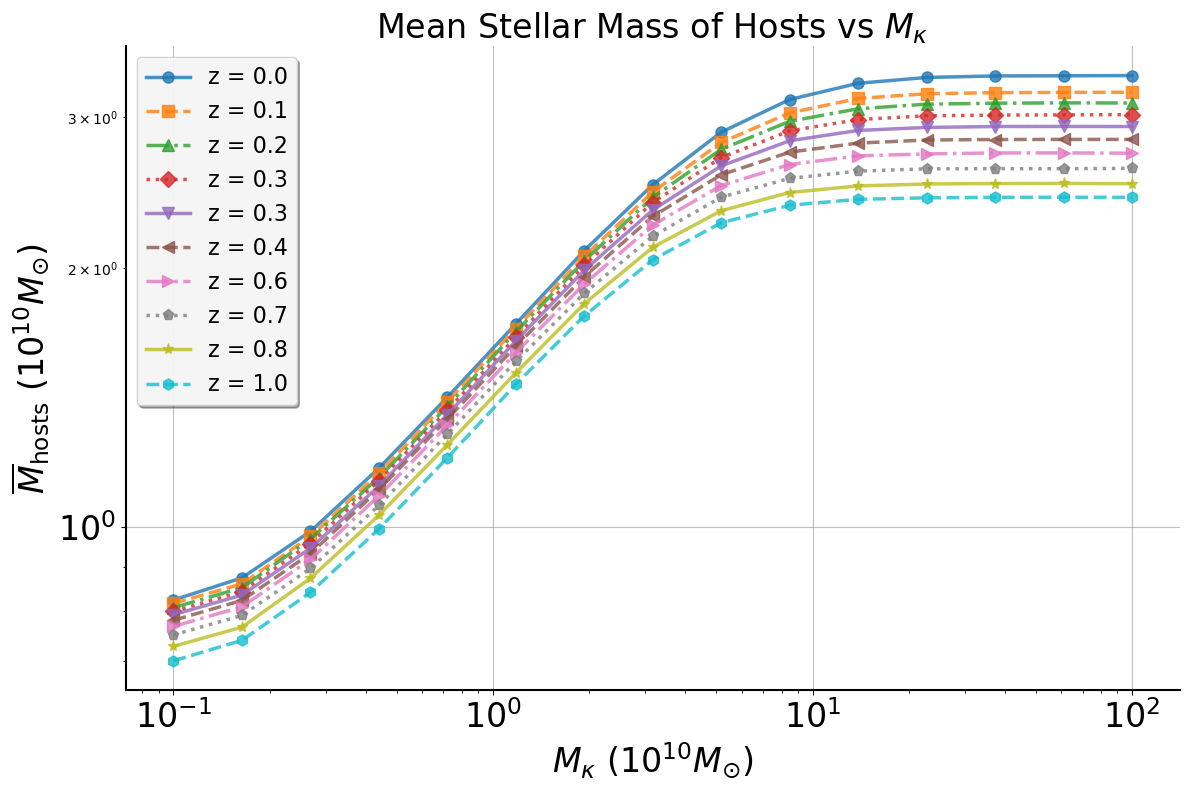


Summary:
Number of redshifts: 10
z = 0.0: 15 pivot mass values
z = 0.11: 15 pivot mass values
z = 0.18: 15 pivot mass values
z = 0.26: 15 pivot mass values
z = 0.35: 15 pivot mass values
z = 0.44: 15 pivot mass values
z = 0.55: 15 pivot mass values
z = 0.68: 15 pivot mass values
z = 0.82: 15 pivot mass values
z = 1.0: 15 pivot mass values


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from collections import defaultdict
import seaborn as sns

# Set up plotting style - remove seaborn style to avoid grey background
plt.style.use('default')

def load_and_process_data(file_pattern):
    """
    Load all pickle files matching the pattern and process the data
    """
    files = glob.glob(file_pattern)
    print(f"Found {len(files)} files matching pattern")
    
    # Dictionary to store data grouped by redshift and M_c
    data_dict = defaultdict(list)
    
    for file_path in files:
        try:
            # Load the pickle file
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            
            print(f"Processing {file_path}: {len(df)} rows")
            
            # Group by redshift (z) and pivot mass (M_c), then calculate mean stellar mass
            grouped = df.groupby(['z', 'M_c'])['stellar_mass'].mean().reset_index()
            
            # Store the data
            for _, row in grouped.iterrows():
                data_dict[(row['z'], row['M_c'])].append(row['stellar_mass'])
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return data_dict

def calculate_mean_stellar_mass(data_dict):
    """
    Calculate the mean stellar mass averaged over all delta_l and delta_h values
    """
    result_dict = defaultdict(lambda: defaultdict(list))
    
    for (z, mc), stellar_masses in data_dict.items():
        # Average over all delta_l and delta_h combinations for this z and M_c
        mean_stellar_mass = np.mean(stellar_masses)
        result_dict[z][mc].append(mean_stellar_mass)
    
    # Final averaging
    final_dict = {}
    for z in result_dict:
        final_dict[z] = {}
        for mc in result_dict[z]:
            final_dict[z][mc] = np.mean(result_dict[z][mc])
    
    return final_dict

def create_plot(final_dict):
    """
    Create an aesthetically pleasing plot
    """
    plt.figure(figsize=(12, 8))
    
    # Define colors and line styles for different redshifts
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Sort redshifts for consistent plotting
    redshifts = sorted(final_dict.keys())
    
    for i, z in enumerate(redshifts):
        # Extract M_c and corresponding mean stellar masses
        mc_values = []
        stellar_masses = []
        
        for mc in sorted(final_dict[z].keys()):
            mc_values.append(mc)
            stellar_masses.append(final_dict[z][mc])
        
        # Convert to numpy arrays for easier handling
        mc_values = np.array(mc_values)
        stellar_masses = np.array(stellar_masses)
        
        # Plot the data
        plt.plot(mc_values, stellar_masses, 
                color=colors[i % len(colors)],
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markersize=8,
                linewidth=2.5,
                alpha=0.8,
                label=f'z = {z:.1f}')
    
    # Customize the plot with font size 24
    plt.xlabel(r'$M_{{\kappa}}$ ($10^{10} M_{\odot}$)', fontsize=24)
    plt.ylabel(r'$\overline{M}_{\mathrm{hosts}}$ ($10^{10} M_{\odot}$)', fontsize=24)

    # Remove title (commented out)
    # plt.title('Mean Stellar Mass vs Pivot Mass at Different Redshifts', 
    #           fontsize=16, fontweight='bold', pad=20)
    
    # Set log scale if needed (uncomment if your data spans multiple orders of magnitude)
    plt.xscale('log')
    plt.yscale('log')
    
    # Add grid with white background
    plt.grid(True, alpha=0.5, linestyle='-', linewidth=0.8, color='gray')
    
    # Set tick label font size
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    # Customize legend (keep original font size)
    plt.legend(frameon=True, fancybox=True, shadow=True, 
              framealpha=0.9, fontsize=16, loc='best')
    
    # Title
    plt.title('Mean Stellar Mass of Hosts vs $M_{\kappa}$', fontsize=24)
    # Adjust layout
    plt.tight_layout()
    
    # Add some styling touches
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Set white background
    ax.set_facecolor('white')
    plt.gcf().patch.set_facecolor('white')
    
    return plt

def main():
    """
    Main function to execute the analysis
    """
    # File pattern for the pickle files
    file_pattern = "/gpfs/nchugh/gw/results/siren_cat_snap_*_dl_*_dh_*_mc_*.pkl"
    
    print("Loading and processing data...")
    data_dict = load_and_process_data(file_pattern)
    
    if not data_dict:
        print("No data found! Please check the file pattern and directory.")
        return
    
    print("Calculating mean stellar masses...")
    final_dict = calculate_mean_stellar_mass(data_dict)
    
    print("Creating plot...")
    plt = create_plot(final_dict)
    
    # Save the plot
    output_filename = "stellar_mass_vs_pivot_mass.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"Plot saved as {output_filename}")
    
    # Display the plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary:")
    print(f"Number of redshifts: {len(final_dict)}")
    for z in sorted(final_dict.keys()):
        print(f"z = {z}: {len(final_dict[z])} pivot mass values")

if __name__ == "__main__":
    main()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_PLEASEWORK_AGAIN"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Galaxy bias values from your actual data (snapshot: bias)
galaxy_bias_snap = {
    50: 1.7309134857458386, 
    55: 1.6022313487459154, 
    60: 1.5022849461250445, 
    65: 1.4357474709434652, 
    70: 1.3701157750838004, 
    75: 1.328179002554566, 
    80: 1.2855231655386756, 
    85: 1.2459544171362074, 
    90: 1.2228309418513719, 
    99: 1.1748298825176093
}

# Create redshift to galaxy bias mapping
galaxy_bias_redshift = {}
for snap, bias_val in galaxy_bias_snap.items():
    redshift = snap_to_redshift[snap]
    galaxy_bias_redshift[redshift] = bias_val

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style with increased font size
sns.set(style="whitegrid", font_scale=2.4)  # Increased font scale for size 24
palette = sns.color_palette("tab10")

# === Fig 10: b vs m_c for diff redshifts (log x) ===
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):  # Show first 8 redshifts to avoid overcrowding
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        # Correct error bars calculation
        ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                    yerr=sorted_df['bias_error'], fmt='o-',
                    label=f'z={redshift}', capsize=4,
                    color=palette[i % len(palette)], markersize=4, alpha=0.8)
        
        # Add galaxy bias as horizontal line if available for this redshift
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel(r"$M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Bias vs $M_{{\kappa}}", fontsize=24)
ax.legend(fontsize=18)  # Slightly smaller for legend readability
fig.tight_layout()
fig.savefig(f"{output_dir}/fig10_b_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 11: Mean mass of siren hosts vs m_c for diff redshifts (log-log) ===
fig, ax = plt.subplots(figsize=(10, 7))
for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        mean_mass = sorted_df['n_sirens'] * sorted_df['mc']
        ax.plot(sorted_df['mc'], mean_mass, lw=2, label=f'z={redshift}', 
                color=palette[i % len(palette)])
        ax.scatter(sorted_df['mc'], mean_mass, s=40, color=palette[i % len(palette)])

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel("Mean Siren Host Mass")
ax.set_xscale("log")
ax.set_yscale("log")
# Title removed
ax.legend(fontsize=18)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig11_meanmass_vs_mc_redshifts.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 12: b vs delta_l and delta_h, fix m_c and other delta ===
mc_fixed = df['mc'].unique()[0]

# Fix pivot mass and delta_h for delta_l plot
dh_fixed_12 = df['dh'].unique()[0]
dl_df = df[(df['mc'] == mc_fixed) & (df['dh'] == dh_fixed_12)]

# Correct aggregation - use proper error propagation
dl_agg = dl_df.groupby('dl').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)  # Standard error propagation
}).reset_index().sort_values('dl')

# Fix pivot mass and delta_l for delta_h plot
dl_fixed_12 = df['dl'].unique()[0]
dh_df = df[(df['mc'] == mc_fixed) & (df['dl'] == dl_fixed_12)]

dh_agg = dh_df.groupby('dh').agg({
    'bias': 'mean',
    'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index().sort_values('dh')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot bias vs delta_l
ax[0].errorbar(dl_agg['dl'], dl_agg['bias'], yerr=dl_agg['bias_error'],
               fmt='o-', capsize=4, color="C0")
ax[0].set_xlabel(r"$\delta_l$")
ax[0].set_ylabel(r"$b_{GW}$")
# Title removed

# Plot bias vs delta_h
ax[1].errorbar(dh_agg['dh'], dh_agg['bias'], yerr=dh_agg['bias_error'],
               fmt='o-', capsize=4, color="C1")
ax[1].set_xlabel(r"$\delta_h$")
ax[1].set_ylabel(r"$b_{GW}$")
# Title removed

fig.tight_layout()
fig.savefig(f"{output_dir}/fig12_b_vs_dl_dh.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# === Fig 13: for each redshift, b vs m_c for selected delta_l, delta_h ===
pairs_to_plot = 4  # Reduced number for better readability
for redshift in redshift_order[:6]:  # Show first 6 redshifts
    fig, ax = plt.subplots(figsize=(10, 7))
    redshift_df = df[df['redshift'] == redshift]
    unique_pairs = redshift_df[['dl', 'dh']].drop_duplicates().values[:pairs_to_plot]
    
    # Create color mapping for dl and dh combinations
    colors = ['C0', 'C1', 'C2', 'C3']
    linestyles = ['-', '--', '-', '--']  # Alternate between solid and dashed

    for i, (dl_val, dh_val) in enumerate(unique_pairs):
        group = redshift_df[(redshift_df['dl'] == dl_val) & (redshift_df['dh'] == dh_val)]
        group = group.sort_values('mc')
        
        # Use same color for same dl or dh values, different linestyles
        color_idx = i % len(colors)
        linestyle = linestyles[i % len(linestyles)]
        
        label = fr"$\delta_l$={dl_val}, $\delta_h$={dh_val}"
        ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
                    fmt='o-', capsize=3, label=label,
                    color=colors[color_idx], linestyle=linestyle, 
                    markersize=4, alpha=0.8)
    
    # Add galaxy bias line if available for this redshift
    if redshift in galaxy_bias_redshift:
        galaxy_b = galaxy_bias_redshift[redshift]
        ax.axhline(y=galaxy_b, color='gray', linestyle=':', alpha=0.7, 
                   linewidth=2, label=f'Galaxy bias = {galaxy_b:.3f}')

    ax.set_xlabel(r"$M_{{\kappa}}$ ($10^{10} M_\odot$)")
    ax.set_ylabel(r"$b_{GW}$")
    ax.set_xscale("log")
    ax.set_title("Bias vs $M_{{\kappa}}$ for $z$ = {:.2f}".format(redshift), fontsize=24)
    ax.legend(fontsize=16, loc='best')  # Smaller legend font for readability
    fig.tight_layout()
    fig.savefig(f"{output_dir}/fig13_b_vs_mc_dl_dh_z{redshift}.png", dpi=600, bbox_inches='tight')
    plt.close(fig)

# === Fig 14: b vs redshift in mc bins ===
df['mc_bin'] = pd.qcut(df['mc'], 4, duplicates='drop')

# Create custom labels for the bins
custom_labels = ["(9, 9.75)", "(9.75, 10.5)", "(10.5, 11.25)", "(11.25, 12)"]
bin_labels = {}
for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    bin_labels[bin_label] = custom_labels[i]

fig, ax = plt.subplots(figsize=(10, 7))
for i, (bin_label, group) in enumerate(df.groupby('mc_bin')):
    grouped = group.groupby('redshift').agg({
        'bias': 'mean',
        'bias_error': lambda x: np.sqrt(np.sum(x**2)) / len(x)
    }).reset_index()
   
    # Sort by redshift for proper line connection
    grouped = grouped.sort_values('redshift', ascending=False)
   
    ax.errorbar(grouped['redshift'], grouped['bias'], yerr=grouped['bias_error'],
                fmt='o-', capsize=3, label=bin_labels[bin_label],
                color=palette[i % len(palette)], markersize=4, alpha=0.8)

# Add galaxy bias evolution - only for redshifts where we have data
available_redshifts = []
available_bias_values = []
for redshift in sorted(galaxy_bias_redshift.keys(), reverse=True):
    available_redshifts.append(redshift)
    available_bias_values.append(galaxy_bias_redshift[redshift])
ax.plot(available_redshifts, available_bias_values, 'k:', linewidth=2,
        alpha=0.7, label='Galaxy bias', marker='s', markersize=6)

ax.set_xlabel("Redshift")
ax.set_ylabel(r"$b_{GW}$")
ax.legend(title="$\log(M_{{\kappa}})$", fontsize=16)
ax.set_title("Mean Bias in $M_{{\kappa}}$ Bin vs Redshift", fontsize=24)
fig.tight_layout()
fig.savefig(f"{output_dir}/fig14_b_vs_redshift_mc_bins.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print(f"✅ Updated figures with no titles and font size 24 saved to: {output_dir}")
print("\nKey changes made:")
print("1. Removed all plot titles")
print("2. Increased font scale to 2.4 for ~24pt font size")
print("3. Adjusted legend font sizes for better readability")
print("4. Kept all axis labels and other formatting")
print(f"\nAvailable galaxy bias data for redshifts: {list(galaxy_bias_redshift.keys())}")
print(f"Corresponding snapshots: {list(galaxy_bias_snap.keys())}")

/tmp/ipykernel_4154154/3382992662.py:171: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_4154154/3382992662.py:171: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_4154154/3382992662.py:171: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(group['mc'], group['bias'], yerr=group['bias_error'],
/tmp/ipykernel_4154154/3382992662.py:171: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='

✅ Updated figures with no titles and font size 24 saved to: ./siren_bias_figures_PLEASEWORK_AGAIN

Key changes made:
1. Removed all plot titles
2. Increased font scale to 2.4 for ~24pt font size
3. Adjusted legend font sizes for better readability
4. Kept all axis labels and other formatting

Available galaxy bias data for redshifts: [1.0, 0.82, 0.68, 0.55, 0.44, 0.35, 0.26, 0.18, 0.11, 0.0]
Corresponding snapshots: [50, 55, 60, 65, 70, 75, 80, 85, 90, 99]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_PLEASEWORK_AGAIN"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style with increased font size
sns.set(style="whitegrid", font_scale=2.4)
palette = sns.color_palette("tab10")

# Simple bias vs mc plot
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        # Plot with proper error bar caps
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,  # Add horizontal caps
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        # Add redshift label above the line at the median point
        median_idx = len(sorted_df) // 2
        median_mc = sorted_df.iloc[median_idx]['mc']
        median_bias = sorted_df.iloc[median_idx]['bias']
        
        # Position label slightly above the line
        ax.text(median_mc, median_bias + 0.05, f'z={redshift}', 
                color=palette[i % len(palette)], fontsize=14, 
                ha='center', va='bottom', fontweight='bold', fontstyle='italic')

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Bias vs $M_{{\kappa}}$ for Different Redshifts", fontsize=24)

fig.tight_layout()
fig.savefig(f"{output_dir}/bias_vs_mc_simple.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print(f"✅ Simple bias vs mc plot saved to: {output_dir}/bias_vs_mc_simple.png")
print("Features:")
print("- Error bars with horizontal caps (capsize=6, capthick=2)")
print("- Redshift labels positioned above each line")
print("- No legend")
print("- Font size 24")
print("- Clean, minimal design")

✅ Simple bias vs mc plot saved to: ./siren_bias_figures_PLEASEWORK_AGAIN/bias_vs_mc_simple.png
Features:
- Error bars with horizontal caps (capsize=6, capthick=2)
- Redshift labels positioned above each line
- No legend
- Font size 24
- Clean, minimal design


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_PLEASEWORK_AGAIN"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Galaxy bias values from your actual data (snapshot: bias)
galaxy_bias_snap = {
    50: 1.7309134857458386, 
    55: 1.6022313487459154, 
    60: 1.5022849461250445, 
    65: 1.4357474709434652, 
    70: 1.3701157750838004, 
    75: 1.328179002554566, 
    80: 1.2855231655386756, 
    85: 1.2459544171362074, 
    90: 1.2228309418513719, 
    99: 1.1748298825176093
}

# Create redshift to galaxy bias mapping
galaxy_bias_redshift = {}
for snap, bias_val in galaxy_bias_snap.items():
    redshift = snap_to_redshift[snap]
    galaxy_bias_redshift[redshift] = bias_val

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style with increased font size
sns.set(style="whitegrid", font_scale=2.4)
palette = sns.color_palette("tab10")

# Simple bias vs mc plot
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        # Plot with proper error bar caps
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,  # Add horizontal caps
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        # Add galaxy bias as horizontal dashed line if available for this redshift
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # Add redshift label at the end of the dashed line (right side)
            xlim = ax.get_xlim()
            # Replace the text line with annotation:
            ax.annotate(f'z={redshift}', xy=(xlim[0], galaxy_b), 
                       xytext=(-20, 0), textcoords='offset points',
                       color=palette[i % len(palette)], fontsize=14, 
                       ha='right', va='center', fontweight='bold', fontstyle='italic')
            
ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Bias vs $M_{{\kappa}}$ for Different Redshifts", fontsize=24)

fig.tight_layout()
fig.savefig(f"{output_dir}/bias_vs_mc_simple.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print(f"✅ Simple bias vs mc plot saved to: {output_dir}/bias_vs_mc_simple.png")
print("Features:")
print("- Error bars with horizontal caps (capsize=6, capthick=2)")
print("- Galaxy bias shown as dashed horizontal lines")
print("- Redshift labels at the end of galaxy bias lines (fontsize=10)")
print("- No legend")
print("- Font size 24")
print("- Clean, minimal design")

✅ Simple bias vs mc plot saved to: ./siren_bias_figures_PLEASEWORK_AGAIN/bias_vs_mc_simple.png
Features:
- Error bars with horizontal caps (capsize=6, capthick=2)
- Galaxy bias shown as dashed horizontal lines
- Redshift labels at the end of galaxy bias lines (fontsize=10)
- No legend
- Font size 24
- Clean, minimal design


In [30]:
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/analysis_summary.pkl")
print(df)

n_measurements                                                 2400
redshifts         [0.0, 0.11, 0.18, 0.26, 0.35, 0.44, 0.55, 0.68...
bias_mean                                                  1.396341
bias_std                                                   0.156057
bias_min                                                   1.136366
bias_max                                                   1.793633
correlations      {'mc': 0.17577916183618916, 'dl': -0.050710105...
dtype: object


In [36]:
print(df.head())

n_measurements                                                 2400
redshifts         [0.0, 0.11, 0.18, 0.26, 0.35, 0.44, 0.55, 0.68...
bias_mean                                                  1.396341
bias_std                                                   0.156057
bias_min                                                   1.136366
dtype: object


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

# Output directory
output_dir = "./siren_bias_figures_PLEASEWORK_AGAIN"
os.makedirs(output_dir, exist_ok=True)

# Create snapshot to redshift mapping
snap_to_redshift = {
    0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
    10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
    20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
    30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
    40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
    50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
    60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
    70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
    80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
    90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
}

# Add redshift column to dataframe
df['redshift'] = df['snap'].map(snap_to_redshift)

# Galaxy bias values from your actual data (snapshot: bias)
galaxy_bias_snap = {
    50: 1.7309134857458386, 
    55: 1.6022313487459154, 
    60: 1.5022849461250445, 
    65: 1.4357474709434652, 
    70: 1.3701157750838004, 
    75: 1.328179002554566, 
    80: 1.2855231655386756, 
    85: 1.2459544171362074, 
    90: 1.2228309418513719, 
    99: 1.1748298825176093
}

# Create redshift to galaxy bias mapping
galaxy_bias_redshift = {}
for snap, bias_val in galaxy_bias_snap.items():
    redshift = snap_to_redshift[snap]
    galaxy_bias_redshift[redshift] = bias_val

# Redshift order (sorted by redshift, descending)
redshift_order = sorted(df['redshift'].unique(), reverse=True)

# Plot style with increased font size
sns.set(style="whitegrid", font_scale=2.4)
palette = sns.color_palette("tab10")

# Simple bias vs mc plot
dl_fixed = df['dl'].unique()[0]
dh_fixed = df['dh'].unique()[0]

# =============================================================================
# METHOD 1: Left-side annotations with offset points and background box
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        # Plot with proper error bar caps
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        # Add galaxy bias as horizontal dashed line if available for this redshift
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 1: Left-side annotation with background box
            xlim = ax.get_xlim()
            ax.annotate(f'z={redshift}', xy=(xlim[0], galaxy_b), 
                       xytext=(-40, 0), textcoords='offset points',
                       color='black', fontsize=12, 
                       ha='right', va='center', fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='gray'))

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Method 1: Left-side Annotations with Background Box", fontsize=20)

fig.tight_layout()
fig.savefig(f"{output_dir}/method1_left_annotations.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 2: Right-side annotations with colored text matching lines
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 2: Right-side annotation with colored text
            xlim = ax.get_xlim()
            ax.annotate(f'z={redshift}', xy=(xlim[1], galaxy_b), 
                       xytext=(20, 0), textcoords='offset points',
                       color=palette[i % len(palette)], fontsize=14, 
                       ha='left', va='center', fontweight='bold')

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Method 2: Right-side Colored Annotations", fontsize=20)

fig.tight_layout()
fig.savefig(f"{output_dir}/method2_right_colored.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 3: Inside plot area annotations at fixed x-position
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 3: Fixed x-position inside plot
            ax.text(0.2, galaxy_b + 0.005, f'z={redshift}', 
                    color='black', fontsize=11, 
                    ha='left', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Method 3: Fixed Position Inside Plot", fontsize=20)

fig.tight_layout()
fig.savefig(f"{output_dir}/method3_inside_fixed.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 4: Legend-style text box with all redshifts
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)

# METHOD 4: Legend-style box
redshift_text = 'Galaxy Bias (dashed lines):\n' + '\n'.join([f'z={z:.2f}' for z in sorted(galaxy_bias_redshift.keys(), reverse=True)])
ax.text(0.02, 0.98, redshift_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.9, edgecolor='navy'))

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Method 4: Legend-style Text Box", fontsize=20)

fig.tight_layout()
fig.savefig(f"{output_dir}/method4_legend_box.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 5: End-of-line annotations (at the right end of each dashed line)
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 5: End-of-line annotation
            xlim = ax.get_xlim()
            ax.text(xlim[1] * 0.95 + 0.1, galaxy_b+0.008, f'  z={redshift}', 
                    color=palette[i % len(palette)], fontsize=12, 
                    ha='left', va='center')

ax.set_xlabel(r"$M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Bias vs $M_{{\kappa}}$", fontsize=24)

fig.tight_layout()
fig.savefig(f"{output_dir}/method5_end_of_line.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 6: Staggered vertical positions to avoid overlap
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 6: Staggered positions with connecting lines
            xlim = ax.get_xlim()
            x_pos = 0.15
            y_offset = i * 0.02  # Stagger vertically
            text_y = galaxy_b + y_offset
            
            # Draw connecting line from dashed line to text
            ax.plot([x_pos * 0.8, x_pos], [galaxy_b, text_y], 
                   color=palette[i % len(palette)], linewidth=1, alpha=0.5)
            
            ax.text(x_pos, text_y, f'z={redshift}', 
                    color=palette[i % len(palette)], fontsize=11, 
                    ha='left', va='center', fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

ax.set_xlabel(r"$M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Bias vs $M_{{\kappa}}$", fontsize=24)

fig.tight_layout()
fig.savefig(f"{output_dir}/method6_staggered.png", dpi=600, bbox_inches='tight')
plt.close(fig)

# =============================================================================
# METHOD 7: Arrow annotations pointing to dashed lines
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

for i, redshift in enumerate(redshift_order[:8]):
    redshift_df = df[(df['redshift'] == redshift) & (df['dl'] == dl_fixed) & (df['dh'] == dh_fixed)]
    if not redshift_df.empty:
        sorted_df = redshift_df.sort_values('mc')
        
        line = ax.errorbar(sorted_df['mc'], sorted_df['bias'],
                          yerr=sorted_df['bias_error'], fmt='o-',
                          capsize=6, capthick=2,
                          color=palette[i % len(palette)], markersize=6, 
                          linewidth=2, alpha=0.8)
        
        if redshift in galaxy_bias_redshift:
            galaxy_b = galaxy_bias_redshift[redshift]
            ax.axhline(y=galaxy_b, color=palette[i % len(palette)], 
                       linestyle='--', alpha=0.7, linewidth=2)
            
            # METHOD 7: Arrow annotations
            xlim = ax.get_xlim()
            ax.annotate(f'z={redshift}', 
                       xy=(xlim[1] * 0.7, galaxy_b), 
                       xytext=(xlim[1] * 0.5, galaxy_b + (i-4) * 0.02),
                       arrowprops=dict(arrowstyle='->', color=palette[i % len(palette)], lw=1.5),
                       color=palette[i % len(palette)], fontsize=12, 
                       ha='center', va='center', fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))

ax.set_xlabel(r"Pivot Mass $M_{{\kappa}}$ ($10^{10} M_\odot$)")
ax.set_ylabel(r"$b_{GW}$")
ax.set_xscale("log")
ax.set_title("Method 7: Arrow Annotations", fontsize=20)

fig.tight_layout()
fig.savefig(f"{output_dir}/method7_arrows.png", dpi=600, bbox_inches='tight')
plt.close(fig)

print("✅ All 7 annotation methods saved:")
print(f"  - Method 1: {output_dir}/method1_left_annotations.png")
print(f"  - Method 2: {output_dir}/method2_right_colored.png")
print(f"  - Method 3: {output_dir}/method3_inside_fixed.png")
print(f"  - Method 4: {output_dir}/method4_legend_box.png")
print(f"  - Method 5: {output_dir}/method5_end_of_line.png")
print(f"  - Method 6: {output_dir}/method6_staggered.png")
print(f"  - Method 7: {output_dir}/method7_arrows.png")

✅ All 7 annotation methods saved:
  - Method 1: ./siren_bias_figures_PLEASEWORK_AGAIN/method1_left_annotations.png
  - Method 2: ./siren_bias_figures_PLEASEWORK_AGAIN/method2_right_colored.png
  - Method 3: ./siren_bias_figures_PLEASEWORK_AGAIN/method3_inside_fixed.png
  - Method 4: ./siren_bias_figures_PLEASEWORK_AGAIN/method4_legend_box.png
  - Method 5: ./siren_bias_figures_PLEASEWORK_AGAIN/method5_end_of_line.png
  - Method 6: ./siren_bias_figures_PLEASEWORK_AGAIN/method6_staggered.png
  - Method 7: ./siren_bias_figures_PLEASEWORK_AGAIN/method7_arrows.png


In [1]:
def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias"""
   
    print("\n" + "="*50)
    print("PARAMETER CORRELATION ANALYSIS")
    print("="*50)
   
    # Calculate correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_valid.columns:
            corr = df_valid[param].corr(df_valid['bias'])
            correlations[param] = corr
            print(f"Correlation bias vs {param}: {corr:.4f}")
   
    # Create correlation heatmap
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_valid.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_valid[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Parameter Correlation Matrix', fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations


In [3]:
import pandas as pd
df = pd.read_pickle("/gpfs/nchugh/gw/bias_results_linear_largek/siren_bias_linear_results_all_snapshots.pkl")

In [4]:
def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias"""
   
    print("\n" + "="*50)
    print("PARAMETER CORRELATION ANALYSIS")
    print("="*50)
   
    # Calculate overall correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_valid.columns:
            corr = df_valid[param].corr(df_valid['bias'])
            correlations[param] = corr
            print(f"Correlation bias vs {param}: {corr:.4f}")
   
    # Calculate dl-bias correlation for each fixed mc value
    print("\n" + "-"*40)
    print("DL-BIAS CORRELATION FOR EACH FIXED MC")
    print("-"*40)
    
    if 'mc' in df_valid.columns and 'dl' in df_valid.columns and 'bias' in df_valid.columns:
        # Get unique mc values
        mc_values = sorted(df_valid['mc'].unique())
        mc_correlations = {}
        
        for mc_val in mc_values:
            # Filter data for this specific mc value
            mc_subset = df_valid[df_valid['mc'] == mc_val]
            
            # Calculate correlation between dl and bias for this mc
            if len(mc_subset) > 1:  # Need at least 2 points for correlation
                corr_dl_bias = mc_subset['dl'].corr(mc_subset['bias'])
                mc_correlations[mc_val] = corr_dl_bias
                print(f"MC = {mc_val:.3f}: dl-bias correlation = {corr_dl_bias:.4f} (n={len(mc_subset)})")
            else:
                print(f"MC = {mc_val:.3f}: insufficient data (n={len(mc_subset)})")
        
        # Store the mc-specific correlations in the main correlations dict
        correlations['dl_bias_by_mc'] = mc_correlations
        
        # Plot dl-bias correlation vs mc
        if mc_correlations:
            plt.figure(figsize=(10, 6))
            mc_vals = list(mc_correlations.keys())
            corr_vals = list(mc_correlations.values())
            
            plt.plot(mc_vals, corr_vals, 'o-', linewidth=2, markersize=8)
            plt.xlabel(r'$M_{\kappa}$', fontsize=16)
            plt.ylabel(r'Correlation($\delta_l$, $b_{GW}$)', fontsize=16)
            plt.title(r'$\delta_l$-$b_{GW}$ Correlation vs $M_{\kappa}$', fontsize=18)
            plt.grid(True, alpha=0.3)
            plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.savefig('bias_results_linear_largek/dl_bias_correlation_by_mc.png', dpi=600, bbox_inches='tight')
            plt.show()
    
    else:
        print("Missing required columns (mc, dl, bias) for mc-specific analysis")
   
    # Create correlation heatmap (original code)
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_valid.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_valid[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Parameter Correlation Matrix', fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations

In [6]:
correlations = analyze_parameter_correlations(df)
# Access mc-specific correlations:
mc_correlations = correlations['dl_bias_by_mc']


PARAMETER CORRELATION ANALYSIS
Correlation bias vs mc: 0.1750
Correlation bias vs dl: -0.0507
Correlation bias vs dh: 0.0204

----------------------------------------
DL-BIAS CORRELATION FOR EACH FIXED MC
----------------------------------------
MC = 0.100: dl-bias correlation = 0.0022 (n=160)
MC = 0.164: dl-bias correlation = -0.0104 (n=160)
MC = 0.268: dl-bias correlation = -0.0164 (n=160)
MC = 0.439: dl-bias correlation = -0.0289 (n=160)
MC = 0.720: dl-bias correlation = -0.0440 (n=160)
MC = 1.179: dl-bias correlation = -0.0586 (n=160)
MC = 1.931: dl-bias correlation = -0.0736 (n=160)
MC = 3.162: dl-bias correlation = -0.0796 (n=160)
MC = 5.179: dl-bias correlation = -0.0791 (n=160)
MC = 8.483: dl-bias correlation = -0.0708 (n=160)
MC = 13.895: dl-bias correlation = -0.0602 (n=160)
MC = 22.758: dl-bias correlation = -0.0669 (n=160)
MC = 37.276: dl-bias correlation = -0.0594 (n=160)
MC = 61.054: dl-bias correlation = -0.0619 (n=160)
MC = 100.000: dl-bias correlation = -0.0631 (n=160

NameError: name 'plt' is not defined

In [12]:
def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias"""
   
    print("\n" + "="*50)
    print("PARAMETER CORRELATION ANALYSIS")
    print("="*50)
   
    # Calculate overall correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_valid.columns:
            corr = df_valid[param].corr(df_valid['bias'])
            correlations[param] = corr
            print(f"Correlation bias vs {param}: {corr:.4f}")
   
    # Define all parameter pairs and their correlations with bias
    param_pairs = [
        ('mc', 'dl', 'bias'),      # Fix mc, correlate dl-bias
        ('mc', 'dh', 'bias'),      # Fix mc, correlate dh-bias
        ('redshift', 'dl', 'bias'), # Fix redshift, correlate dl-bias
        ('redshift', 'dh', 'bias'), # Fix redshift, correlate dh-bias
        ('mc', 'redshift', 'dl'),   # Fix mc & redshift, correlate dl-bias (if bias not third param)
        ('mc', 'redshift', 'dh'),   # Fix mc & redshift, correlate dh-bias
    ]
    
    # Two-parameter fixing analysis
    two_param_pairs = [
        ('mc', 'redshift', 'dl', 'bias'),    # Fix mc & redshift, correlate dl-bias
        ('mc', 'redshift', 'dh', 'bias'),    # Fix mc & redshift, correlate dh-bias
        ('dl', 'dh', 'mc', 'bias'),          # Fix dl & dh, correlate mc-bias
        ('dl', 'dh', 'redshift', 'bias'),    # Fix dl & dh, correlate redshift-bias
        ('mc', 'dl', 'dh', 'bias'),          # Fix mc & dl, correlate dh-bias
        ('mc', 'dl', 'redshift', 'bias'),    # Fix mc & dl, correlate redshift-bias
        ('mc', 'dh', 'dl', 'bias'),          # Fix mc & dh, correlate dl-bias
        ('mc', 'dh', 'redshift', 'bias'),    # Fix mc & dh, correlate redshift-bias
        ('redshift', 'dl', 'mc', 'bias'),    # Fix redshift & dl, correlate mc-bias
        ('redshift', 'dl', 'dh', 'bias'),    # Fix redshift & dl, correlate dh-bias
        ('redshift', 'dh', 'mc', 'bias'),    # Fix redshift & dh, correlate mc-bias
        ('redshift', 'dh', 'dl', 'bias'),    # Fix redshift & dh, correlate dl-bias
    ]
    
    # Function to analyze correlations for fixed parameter values
    def analyze_fixed_params(df, fixed_params, corr_param1, corr_param2, analysis_name):
        print(f"\n" + "-"*60)
        print(f"{analysis_name}")
        print("-"*60)
        
        # Check if all required columns exist
        required_cols = fixed_params + [corr_param1, corr_param2]
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            print(f"Missing columns: {missing}")
            return {}
        
        correlations_dict = {}
        
        if len(fixed_params) == 1:
            # Single parameter fixing
            fixed_param = fixed_params[0]
            unique_vals = sorted(df[fixed_param].unique())
            
            for val in unique_vals:
                subset = df[df[fixed_param] == val]
                
                if len(subset) > 1:
                    corr = subset[corr_param1].corr(subset[corr_param2])
                    correlations_dict[val] = corr
                    print(f"{fixed_param} = {val:.3f}: {corr_param1}-{corr_param2} correlation = {corr:.4f} (n={len(subset)})")
                else:
                    print(f"{fixed_param} = {val:.3f}: insufficient data (n={len(subset)})")
        
        elif len(fixed_params) == 2:
            # Two parameter fixing
            param1, param2 = fixed_params
            # Get unique combinations of the two fixed parameters
            unique_combinations = df[[param1, param2]].drop_duplicates().sort_values([param1, param2])
            
            for _, row in unique_combinations.iterrows():
                val1, val2 = row[param1], row[param2]
                subset = df[(df[param1] == val1) & (df[param2] == val2)]
                
                if len(subset) > 1:
                    corr = subset[corr_param1].corr(subset[corr_param2])
                    correlations_dict[(val1, val2)] = corr
                    print(f"{param1} = {val1:.3f}, {param2} = {val2:.3f}: {corr_param1}-{corr_param2} correlation = {corr:.4f} (n={len(subset)})")
                else:
                    print(f"{param1} = {val1:.3f}, {param2} = {val2:.3f}: insufficient data (n={len(subset)})")
        
        return correlations_dict
    
    # Perform single-parameter fixing analysis
    print("\n" + "="*70)
    print("SINGLE PARAMETER FIXING ANALYSIS")
    print("="*70)
    
    # Fix mc, correlate others with bias
    correlations['dl_bias_by_mc'] = analyze_fixed_params(
        df_valid, ['mc'], 'dl', 'bias', 
        "DL-BIAS CORRELATION FOR EACH FIXED MC"
    )
    
    correlations['dh_bias_by_mc'] = analyze_fixed_params(
        df_valid, ['mc'], 'dh', 'bias',
        "DH-BIAS CORRELATION FOR EACH FIXED MC"
    )
    
    # Fix redshift, correlate others with bias
    correlations['dl_bias_by_redshift'] = analyze_fixed_params(
        df_valid, ['redshift'], 'dl', 'bias',
        "DL-BIAS CORRELATION FOR EACH FIXED REDSHIFT"
    )
    
    correlations['dh_bias_by_redshift'] = analyze_fixed_params(
        df_valid, ['redshift'], 'dh', 'bias',
        "DH-BIAS CORRELATION FOR EACH FIXED REDSHIFT"
    )
    
    # Perform two-parameter fixing analysis
    print("\n" + "="*70)
    print("TWO PARAMETER FIXING ANALYSIS")
    print("="*70)
    
    # Fix mc & redshift, correlate dl-bias and dh-bias
    correlations['dl_bias_by_mc_redshift'] = analyze_fixed_params(
        df_valid, ['mc', 'redshift'], 'dl', 'bias',
        "DL-BIAS CORRELATION FOR EACH FIXED (MC, REDSHIFT) PAIR"
    )
    
    correlations['dh_bias_by_mc_redshift'] = analyze_fixed_params(
        df_valid, ['mc', 'redshift'], 'dh', 'bias',
        "DH-BIAS CORRELATION FOR EACH FIXED (MC, REDSHIFT) PAIR"
    )
    
    # Additional two-parameter combinations
    correlations['mc_bias_by_dl_dh'] = analyze_fixed_params(
        df_valid, ['dl', 'dh'], 'mc', 'bias',
        "MC-BIAS CORRELATION FOR EACH FIXED (DL, DH) PAIR"
    )
    
    correlations['redshift_bias_by_dl_dh'] = analyze_fixed_params(
        df_valid, ['dl', 'dh'], 'redshift', 'bias',
        "REDSHIFT-BIAS CORRELATION FOR EACH FIXED (DL, DH) PAIR"
    )
    
    # Create visualization plots
    def plot_correlations(corr_dict, title, xlabel, ylabel, filename):
        if not corr_dict:
            return
            
        plt.figure(figsize=(12, 6))
        
        if isinstance(list(corr_dict.keys())[0], tuple):
            # Two-parameter case - create a more complex visualization
            keys = list(corr_dict.keys())
            values = list(corr_dict.values())
            
            # For 2D case, we'll create a scatter plot with color coding
            x_vals = [k[0] for k in keys]
            y_vals = [k[1] for k in keys]
            
            scatter = plt.scatter(x_vals, y_vals, c=values, cmap='coolwarm', 
                                s=100, alpha=0.7, vmin=-1, vmax=1)
            plt.colorbar(scatter, label='Correlation')
            
            # Add text annotations
            for i, (key, val) in enumerate(corr_dict.items()):
                plt.annotate(f'{val:.3f}', (x_vals[i], y_vals[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        else:
            # Single-parameter case
            keys = list(corr_dict.keys())
            values = list(corr_dict.values())
            plt.plot(keys, values, 'o-', linewidth=2, markersize=8)
            plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.title(title, fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'bias_results_linear_largek/{filename}', dpi=600, bbox_inches='tight')
        plt.show()
    
    # Create plots for key relationships
    plot_correlations(
        correlations.get('dl_bias_by_mc', {}),
        r'$\delta_l$-$b_{GW}$ Correlation vs $M_{\kappa}$',
        r'$M_{\kappa}$', r'Correlation($\delta_l$, $b_{GW}$)',
        'dl_bias_correlation_by_mc.png'
    )
    
    plot_correlations(
        correlations.get('dh_bias_by_mc', {}),
        r'$\delta_h$-$b_{GW}$ Correlation vs $M_{\kappa}$',
        r'$M_{\kappa}$', r'Correlation($\delta_h$, $b_{GW}$)',
        'dh_bias_correlation_by_mc.png'
    )
    
    plot_correlations(
        correlations.get('dl_bias_by_redshift', {}),
        r'$\delta_l$-$b_{GW}$ Correlation vs Redshift',
        'Redshift', r'Correlation($\delta_l$, $b_{GW}$)',
        'dl_bias_correlation_by_redshift.png'
    )
    
    plot_correlations(
        correlations.get('dh_bias_by_redshift', {}),
        r'$\delta_h$-$b_{GW}$ Correlation vs Redshift',
        'Redshift', r'Correlation($\delta_h$, $b_{GW}$)',
        'dh_bias_correlation_by_redshift.png'
    )
    
    # Create correlation heatmap (original code)
    param_cols = ['mc', 'dl', 'dh', 'z', 'bias']
    available_cols = [col for col in param_cols if col in df_valid.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_valid[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'z': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Parameter Correlation Matrix', fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations

In [11]:
correlations = analyze_parameter_correlations(df)

# Access specific correlations:
dl_bias_by_mc = correlations['dl_bias_by_mc']
dl_bias_by_mc_redshift = correlations['dl_bias_by_mc_redshift']  # Two-param fixing


PARAMETER CORRELATION ANALYSIS
Correlation bias vs mc: 0.1750
Correlation bias vs dl: -0.0507
Correlation bias vs dh: 0.0204

SINGLE PARAMETER FIXING ANALYSIS

------------------------------------------------------------
DL-BIAS CORRELATION FOR EACH FIXED MC
------------------------------------------------------------
mc = 0.100: dl-bias correlation = 0.0022 (n=160)
mc = 0.164: dl-bias correlation = -0.0104 (n=160)
mc = 0.268: dl-bias correlation = -0.0164 (n=160)
mc = 0.439: dl-bias correlation = -0.0289 (n=160)
mc = 0.720: dl-bias correlation = -0.0440 (n=160)
mc = 1.179: dl-bias correlation = -0.0586 (n=160)
mc = 1.931: dl-bias correlation = -0.0736 (n=160)
mc = 3.162: dl-bias correlation = -0.0796 (n=160)
mc = 5.179: dl-bias correlation = -0.0791 (n=160)
mc = 8.483: dl-bias correlation = -0.0708 (n=160)
mc = 13.895: dl-bias correlation = -0.0602 (n=160)
mc = 22.758: dl-bias correlation = -0.0669 (n=160)
mc = 37.276: dl-bias correlation = -0.0594 (n=160)
mc = 61.054: dl-bias correl

NameError: name 'plt' is not defined

In [13]:
print(df.head())

   snap       mc   dl    dh  n_sirens      bias  bias_error  chi2_reduced  \
0    50   22.758  1.3  3.33     71516  1.755759    0.015513      0.362236   
1    50    1.931  1.5  4.00     71516  1.702014    0.014974      0.213936   
2    50    0.100  1.1  2.67     71516  1.562861    0.013799      0.313707   
3    50  100.000  1.5  3.33     71516  1.753818    0.015364      0.659882   
4    50    0.439  0.9  2.00     71516  1.603476    0.014159      0.149815   

   n_fit_points  
0            15  
1            15  
2            15  
3            15  
4            15  


In [18]:
def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias for all parameter pairs"""
    
    SNAP_TO_REDSHIFT = {
        0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
        10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
        20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
        30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
        40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
        50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
        60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
        70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
        80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
        90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
    }
    
    # Add redshift column
    df_analysis = df_valid.copy()
    df_analysis['redshift'] = df_analysis['snap'].map(SNAP_TO_REDSHIFT)
   
    print("\n" + "="*70)
    print("COMPREHENSIVE PARAMETER CORRELATION ANALYSIS")
    print("="*70)
   
    # Calculate overall correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_analysis.columns:
            corr = df_analysis[param].corr(df_analysis['bias'])
            correlations[param] = corr
            print(f"Overall correlation bias vs {param}: {corr:.4f}")
    
    # Define parameter pairs to analyze
    param_pairs = [
        ('mc', 'redshift', 'dl', 'bias'),  # Fix mc & redshift, corr dl-bias
        ('mc', 'redshift', 'dh', 'bias'),  # Fix mc & redshift, corr dh-bias
    ]
    
    correlations['conditional_correlations'] = {}
    
    for fixed_param1, fixed_param2, var_param1, var_param2 in param_pairs:
        print(f"\n" + "-"*60)
        print(f"CORRELATION {var_param1.upper()}-{var_param2.upper()} FOR EACH FIXED ({fixed_param1.upper()}, {fixed_param2.upper()})")
        print("-"*60)
        
        if all(col in df_analysis.columns for col in [fixed_param1, fixed_param2, var_param1, var_param2]):
            # Get unique combinations of the two fixed parameters
            fixed_combinations = df_analysis[[fixed_param1, fixed_param2]].drop_duplicates()
            fixed_combinations = fixed_combinations.sort_values([fixed_param1, fixed_param2])
            
            pair_key = f"{var_param1}_{var_param2}_fixed_{fixed_param1}_{fixed_param2}"
            correlations['conditional_correlations'][pair_key] = {}
            
            correlation_results = []
            
            for _, row in fixed_combinations.iterrows():
                val1, val2 = row[fixed_param1], row[fixed_param2]
                
                # Filter data for this specific combination
                subset_mask = (df_analysis[fixed_param1] == val1) & (df_analysis[fixed_param2] == val2)
                subset = df_analysis[subset_mask]
                
                # Calculate correlation between var_param1 and var_param2 for this combination
                if len(subset) > 1:  # Need at least 2 points for correlation
                    corr_val = subset[var_param1].corr(subset[var_param2])
                    if not pd.isna(corr_val):  # Check for valid correlation
                        key = (val1, val2)
                        correlations['conditional_correlations'][pair_key][key] = corr_val
                        correlation_results.append({
                            fixed_param1: val1,
                            fixed_param2: val2,
                            'correlation': corr_val,
                            'n_points': len(subset)
                        })
                        
                        # Format output based on parameter types
                        if fixed_param1 == 'mc':
                            val1_str = f"{val1:.3f}"
                        else:
                            val1_str = f"{val1:.2f}"
                        
                        if fixed_param2 == 'redshift':
                            val2_str = f"{val2:.2f}"
                        else:
                            val2_str = f"{val2:.3f}"
                            
                        print(f"{fixed_param1.upper()}={val1_str}, {fixed_param2.upper()}={val2_str}: "
                              f"{var_param1}-{var_param2} correlation = {corr_val:.4f} (n={len(subset)})")
                    else:
                        print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                              f"invalid correlation (n={len(subset)})")
                else:
                    print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                          f"insufficient data (n={len(subset)})")
            
            # Create visualization if we have results
            if correlation_results:
                correlation_df = pd.DataFrame(correlation_results)
                
                # Create a pivot table for heatmap
                pivot_table = correlation_df.pivot(index=fixed_param1, columns=fixed_param2, values='correlation')
                
                plt.figure(figsize=(12, 8))
                
                # Create heatmap
                sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0,
                           square=False, linewidths=0.5, fmt='.3f', 
                           cbar_kws={'label': f'{var_param1}-{var_param2} Correlation'})
                
                # Create custom labels
                label_map = {'mc': r'$M_{\kappa} (10^{10}M_{\odot})$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                            'bias': r'$b_{GW}$', 'redshift': 'z'}
                
                xlabel = label_map.get(fixed_param2, fixed_param2)
                ylabel = label_map.get(fixed_param1, fixed_param1)
                var1_label = label_map.get(var_param1, var_param1)
                var2_label = label_map.get(var_param2, var_param2)
                
                plt.xlabel(xlabel, fontsize=14)
                plt.ylabel(ylabel, fontsize=14)
                plt.title(f'{var1_label}-{var2_label} Correlation\nConditioned on {ylabel} and {xlabel}', 
                         fontsize=16)
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations


COMPREHENSIVE PARAMETER CORRELATION ANALYSIS
Overall correlation bias vs mc: 0.1750
Overall correlation bias vs dl: -0.0507
Overall correlation bias vs dh: 0.0204
Overall correlation bias vs redshift: 0.9392

------------------------------------------------------------
CORRELATION DL-BIAS FOR EACH FIXED (MC, REDSHIFT)
------------------------------------------------------------
Reduced resolution: Using 5 mc values (every 3rd) and 3 redshift values (every 4th)
Total combinations: 15 (reduced from original)
MC=0.100, REDSHIFT=0.00: dl-bias correlation = -0.0139 (n=16)
MC=0.100, REDSHIFT=0.35: dl-bias correlation = 0.0198 (n=16)
MC=0.100, REDSHIFT=0.82: dl-bias correlation = 0.0353 (n=16)
MC=0.439, REDSHIFT=0.00: dl-bias correlation = -0.0345 (n=16)
MC=0.439, REDSHIFT=0.35: dl-bias correlation = -0.4308 (n=16)
MC=0.439, REDSHIFT=0.82: dl-bias correlation = -0.5368 (n=16)
MC=1.931, REDSHIFT=0.00: dl-bias correlation = -0.7368 (n=16)
MC=1.931, REDSHIFT=0.35: dl-bias correlation = -0.7949 

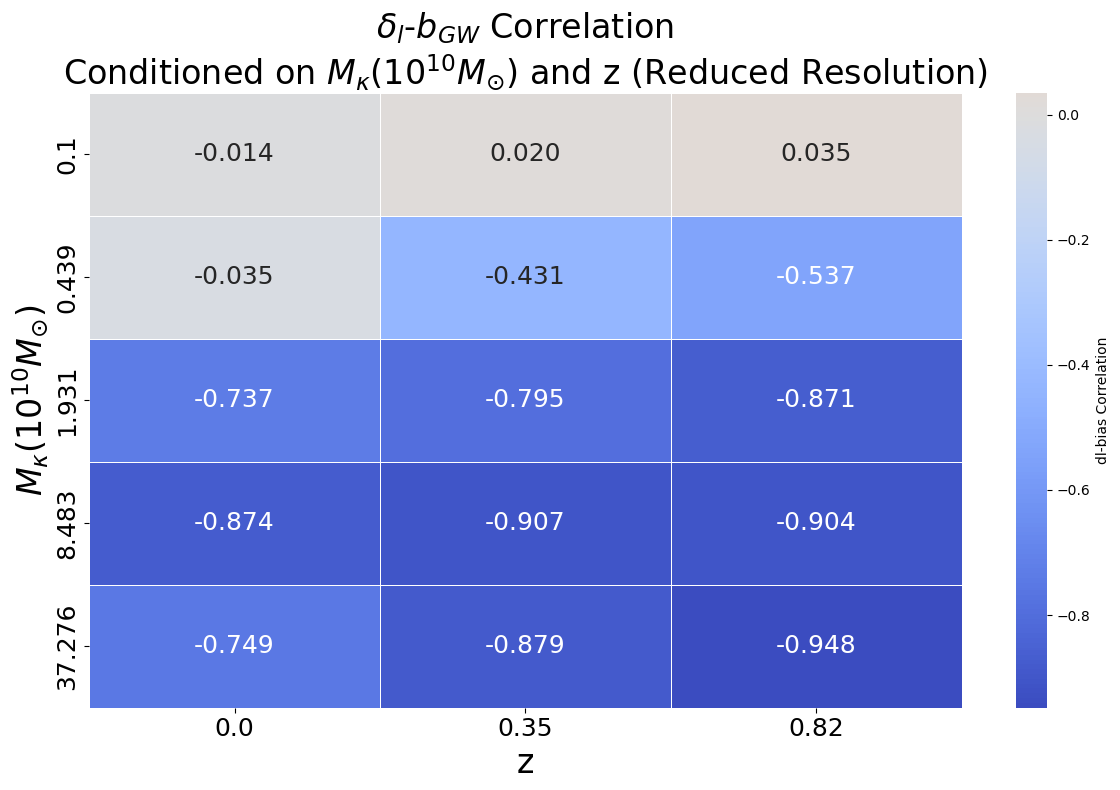


Summary for dl-bias correlations:
  Mean correlation: -0.5750
  Std correlation: 0.3862
  Min correlation: -0.9482
  Max correlation: 0.0353
  Total combinations analyzed: 15

------------------------------------------------------------
CORRELATION DH-BIAS FOR EACH FIXED (MC, REDSHIFT)
------------------------------------------------------------
Reduced resolution: Using 5 mc values (every 3rd) and 3 redshift values (every 4th)
Total combinations: 15 (reduced from original)
MC=0.100, REDSHIFT=0.00: dh-bias correlation = 0.5766 (n=16)
MC=0.100, REDSHIFT=0.35: dh-bias correlation = 0.8272 (n=16)
MC=0.100, REDSHIFT=0.82: dh-bias correlation = 0.8989 (n=16)
MC=0.439, REDSHIFT=0.00: dh-bias correlation = 0.5383 (n=16)
MC=0.439, REDSHIFT=0.35: dh-bias correlation = 0.7036 (n=16)
MC=0.439, REDSHIFT=0.82: dh-bias correlation = 0.4333 (n=16)
MC=1.931, REDSHIFT=0.00: dh-bias correlation = 0.3985 (n=16)
MC=1.931, REDSHIFT=0.35: dh-bias correlation = 0.2597 (n=16)
MC=1.931, REDSHIFT=0.82: dh-bias

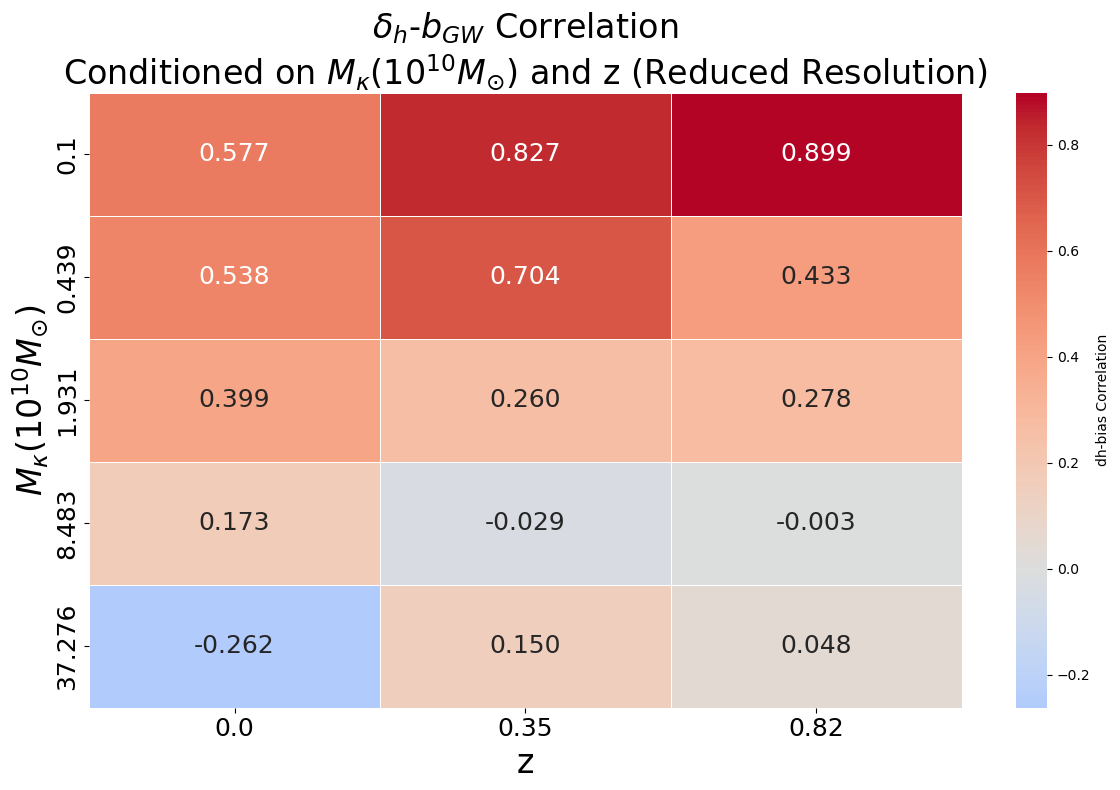


Summary for dh-bias correlations:
  Mean correlation: 0.3327
  Std correlation: 0.3343
  Min correlation: -0.2619
  Max correlation: 0.8989
  Total combinations analyzed: 15

--------------------------------------------------
OVERALL CORRELATION MATRIX
--------------------------------------------------


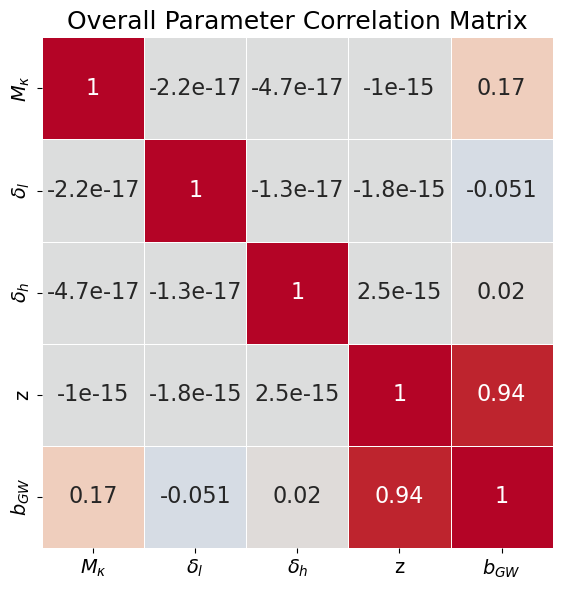

In [30]:
correlations = analyze_parameter_correlations(df)

# Access specific conditional correlations:
dl_bias_correlations = correlations['conditional_correlations']['dl_bias_fixed_mc_redshift']
dh_bias_correlations = correlations['conditional_correlations']['dh_bias_fixed_mc_redshift']

In [28]:
def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias for all parameter pairs"""
    
    SNAP_TO_REDSHIFT = {
        0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
        10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
        20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
        30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
        40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
        50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
        60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
        70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
        80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
        90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
    }
    
    # Add redshift column
    df_analysis = df_valid.copy()
    df_analysis['redshift'] = df_analysis['snap'].map(SNAP_TO_REDSHIFT)
   
    print("\n" + "="*70)
    print("COMPREHENSIVE PARAMETER CORRELATION ANALYSIS")
    print("="*70)
   
    # Calculate overall correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_analysis.columns:
            corr = df_analysis[param].corr(df_analysis['bias'])
            correlations[param] = corr
            print(f"Overall correlation bias vs {param}: {corr:.4f}")
    
    # Define parameter pairs to analyze
    param_pairs = [
        ('mc', 'redshift', 'dl', 'bias'),  # Fix mc & redshift, corr dl-bias
        ('mc', 'redshift', 'dh', 'bias'),  # Fix mc & redshift, corr dh-bias
    ]
    
    correlations['conditional_correlations'] = {}
    
    for fixed_param1, fixed_param2, var_param1, var_param2 in param_pairs:
        print(f"\n" + "-"*60)
        print(f"CORRELATION {var_param1.upper()}-{var_param2.upper()} FOR EACH FIXED ({fixed_param1.upper()}, {fixed_param2.upper()})")
        print("-"*60)
        
        if all(col in df_analysis.columns for col in [fixed_param1, fixed_param2, var_param1, var_param2]):
            # Get unique combinations of the two fixed parameters
            fixed_combinations = df_analysis[[fixed_param1, fixed_param2]].drop_duplicates()
            fixed_combinations = fixed_combinations.sort_values([fixed_param1, fixed_param2])
            
            # REDUCE RESOLUTION: Sample fewer mc and redshift values
            if fixed_param1 == 'mc' and fixed_param2 == 'redshift':
                # Get unique values
                unique_mc = sorted(fixed_combinations['mc'].unique())
                unique_redshift = sorted(fixed_combinations['redshift'].unique())
                
                # Sample every 3rd value for mc (or adjust step as needed)
                mc_step = 3
                sampled_mc = unique_mc[::mc_step]
                
                # Sample every 4th value for redshift (or adjust step as needed)  
                redshift_step = 4
                sampled_redshift = unique_redshift[::redshift_step]
                
                # Filter combinations to only include sampled values
                fixed_combinations = fixed_combinations[
                    fixed_combinations['mc'].isin(sampled_mc) & 
                    fixed_combinations['redshift'].isin(sampled_redshift)
                ]
                
                print(f"Reduced resolution: Using {len(sampled_mc)} mc values (every {mc_step}rd) and {len(sampled_redshift)} redshift values (every {redshift_step}th)")
                print(f"Total combinations: {len(fixed_combinations)} (reduced from original)")
            
            pair_key = f"{var_param1}_{var_param2}_fixed_{fixed_param1}_{fixed_param2}"
            correlations['conditional_correlations'][pair_key] = {}
            
            correlation_results = []
            
            for _, row in fixed_combinations.iterrows():
                val1, val2 = row[fixed_param1], row[fixed_param2]
                
                # Filter data for this specific combination
                subset_mask = (df_analysis[fixed_param1] == val1) & (df_analysis[fixed_param2] == val2)
                subset = df_analysis[subset_mask]
                
                # Calculate correlation between var_param1 and var_param2 for this combination
                if len(subset) > 1:  # Need at least 2 points for correlation
                    corr_val = subset[var_param1].corr(subset[var_param2])
                    if not pd.isna(corr_val):  # Check for valid correlation
                        key = (val1, val2)
                        correlations['conditional_correlations'][pair_key][key] = corr_val
                        correlation_results.append({
                            fixed_param1: val1,
                            fixed_param2: val2,
                            'correlation': corr_val,
                            'n_points': len(subset)
                        })
                        
                        # Format output based on parameter types
                        if fixed_param1 == 'mc':
                            val1_str = f"{val1:.3f}"
                        else:
                            val1_str = f"{val1:.2f}"
                        
                        if fixed_param2 == 'redshift':
                            val2_str = f"{val2:.2f}"
                        else:
                            val2_str = f"{val2:.3f}"
                            
                        print(f"{fixed_param1.upper()}={val1_str}, {fixed_param2.upper()}={val2_str}: "
                              f"{var_param1}-{var_param2} correlation = {corr_val:.4f} (n={len(subset)})")
                    else:
                        print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                              f"invalid correlation (n={len(subset)})")
                else:
                    print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                          f"insufficient data (n={len(subset)})")
            
            # Create visualization if we have results
            if correlation_results:
                correlation_df = pd.DataFrame(correlation_results)
                
                # Create a pivot table for heatmap
                pivot_table = correlation_df.pivot(index=fixed_param1, columns=fixed_param2, values='correlation')
                
                plt.figure(figsize=(12, 8))
                
                # Create heatmap with custom tick spacing and larger annotation font
                ax = sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0,
                               square=False, linewidths=0.5, fmt='.3f', 
                               annot_kws={'fontsize': 18},
                               cbar_kws={'label': f'{var_param1}-{var_param2} Correlation'})
                
                # Reduce the number of tick labels on axes to match reduced resolution
                if fixed_param1 == 'mc' and fixed_param2 == 'redshift':
                    # Get current tick positions and labels
                    y_ticks = ax.get_yticks()
                    x_ticks = ax.get_xticks()
                    y_labels = [item.get_text() for item in ax.get_yticklabels()]
                    x_labels = [item.get_text() for item in ax.get_xticklabels()]
                    
                    # Show every nth tick to match our sampling
                    y_step = max(1, len(y_labels) // 8)  # Show ~8 y-axis labels
                    x_step = max(1, len(x_labels) // 6)  # Show ~6 x-axis labels
                    
                    # Set reduced tick labels with larger font
                    ax.set_yticks(y_ticks[::y_step])
                    ax.set_yticklabels([y_labels[i] for i in range(0, len(y_labels), y_step)], fontsize=18)
                    ax.set_xticks(x_ticks[::x_step])
                    ax.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), x_step)], fontsize=18)
                
                # Create custom labels
                label_map = {'mc': r'$M_{\kappa} (10^{10}M_{\odot})$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                            'bias': r'$b_{GW}$', 'redshift': 'z'}
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations, 'dl': r'$\delta_l
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations, 'dh': r'$\delta_h
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations,
                            'bias': r'$b_{GW}
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations, 'redshift': 'z'}
                
                xlabel = label_map.get(fixed_param2, fixed_param2)
                ylabel = label_map.get(fixed_param1, fixed_param1)
                var1_label = label_map.get(var_param1, var_param1)
                var2_label = label_map.get(var_param2, var_param2)
                
                plt.xlabel(xlabel, fontsize=24)
                plt.ylabel(ylabel, fontsize=24)
                plt.title(f'{var1_label}-{var2_label} Correlation\nConditioned on {ylabel} and {xlabel} (Reduced Resolution)', 
                         fontsize=24)
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap (original code)
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {'mc': r'$M_{\kappa}$', 'dl': r'$\delta_l$', 'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 'redshift': 'z'}
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 220)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_parameter_correlations(df_valid):
    """Analyze correlations between parameters and bias for all parameter pairs"""
    
    SNAP_TO_REDSHIFT = {
        0: 20.05, 1: 14.99, 2: 11.98, 3: 10.98, 4: 10.00, 5: 9.39, 6: 9.00, 7: 8.45, 8: 8.01, 9: 7.60,
        10: 7.24, 11: 7.01, 12: 6.49, 13: 6.01, 14: 5.85, 15: 5.53, 16: 5.23, 17: 5.00, 18: 4.66, 19: 4.43,
        20: 4.18, 21: 4.01, 22: 3.71, 23: 3.49, 24: 3.28, 25: 3.01, 26: 2.90, 27: 2.73, 28: 2.58, 29: 2.44,
        30: 2.32, 31: 2.21, 32: 2.10, 33: 2.00, 34: 1.90, 35: 1.82, 36: 1.74, 37: 1.67, 38: 1.60, 39: 1.53,
        40: 1.50, 41: 1.41, 42: 1.36, 43: 1.30, 44: 1.25, 45: 1.21, 46: 1.15, 47: 1.11, 48: 1.07, 49: 1.04,
        50: 1.00, 51: 0.95, 52: 0.92, 53: 0.89, 54: 0.85, 55: 0.82, 56: 0.79, 57: 0.76, 58: 0.73, 59: 0.70,
        60: 0.68, 61: 0.64, 62: 0.62, 63: 0.60, 64: 0.58, 65: 0.55, 66: 0.52, 67: 0.50, 68: 0.48, 69: 0.46,
        70: 0.44, 71: 0.42, 72: 0.40, 73: 0.38, 74: 0.36, 75: 0.35, 76: 0.33, 77: 0.31, 78: 0.30, 79: 0.27,
        80: 0.26, 81: 0.24, 82: 0.23, 83: 0.21, 84: 0.20, 85: 0.18, 86: 0.17, 87: 0.15, 88: 0.14, 89: 0.13,
        90: 0.11, 91: 0.10, 92: 0.08, 93: 0.07, 94: 0.06, 95: 0.05, 96: 0.03, 97: 0.02, 98: 0.01, 99: 0.00
    }
    
    # Add redshift column
    df_analysis = df_valid.copy()
    df_analysis['redshift'] = df_analysis['snap'].map(SNAP_TO_REDSHIFT)
   
    print("\n" + "="*70)
    print("COMPREHENSIVE PARAMETER CORRELATION ANALYSIS")
    print("="*70)
   
    # Calculate overall correlations
    params = ['mc', 'dl', 'dh', 'redshift']
    correlations = {}
   
    for param in params:
        if param in df_analysis.columns:
            corr = df_analysis[param].corr(df_analysis['bias'])
            correlations[param] = corr
            print(f"Overall correlation bias vs {param}: {corr:.4f}")
    
    # Define parameter pairs to analyze
    param_pairs = [
        ('mc', 'redshift', 'dl', 'bias'),  # Fix mc & redshift, corr dl-bias
        ('mc', 'redshift', 'dh', 'bias'),  # Fix mc & redshift, corr dh-bias
    ]
    
    correlations['conditional_correlations'] = {}
    
    for fixed_param1, fixed_param2, var_param1, var_param2 in param_pairs:
        print(f"\n" + "-"*60)
        print(f"CORRELATION {var_param1.upper()}-{var_param2.upper()} FOR EACH FIXED ({fixed_param1.upper()}, {fixed_param2.upper()})")
        print("-"*60)
        
        if all(col in df_analysis.columns for col in [fixed_param1, fixed_param2, var_param1, var_param2]):
            # Get unique combinations of the two fixed parameters
            fixed_combinations = df_analysis[[fixed_param1, fixed_param2]].drop_duplicates()
            fixed_combinations = fixed_combinations.sort_values([fixed_param1, fixed_param2])
            
            # REDUCE RESOLUTION: Sample fewer mc and redshift values
            if fixed_param1 == 'mc' and fixed_param2 == 'redshift':
                # Get unique values
                unique_mc = sorted(fixed_combinations['mc'].unique())
                unique_redshift = sorted(fixed_combinations['redshift'].unique())
                
                # Sample every 3rd value for mc (or adjust step as needed)
                mc_step = 3
                sampled_mc = unique_mc[::mc_step]
                
                # Sample every 4th value for redshift (or adjust step as needed)  
                redshift_step = 4
                sampled_redshift = unique_redshift[::redshift_step]
                
                # Filter combinations to only include sampled values
                fixed_combinations = fixed_combinations[
                    fixed_combinations['mc'].isin(sampled_mc) & 
                    fixed_combinations['redshift'].isin(sampled_redshift)
                ]
                
                print(f"Reduced resolution: Using {len(sampled_mc)} mc values (every {mc_step}rd) and {len(sampled_redshift)} redshift values (every {redshift_step}th)")
                print(f"Total combinations: {len(fixed_combinations)} (reduced from original)")
            
            pair_key = f"{var_param1}_{var_param2}_fixed_{fixed_param1}_{fixed_param2}"
            correlations['conditional_correlations'][pair_key] = {}
            
            correlation_results = []
            
            for _, row in fixed_combinations.iterrows():
                val1, val2 = row[fixed_param1], row[fixed_param2]
                
                # Filter data for this specific combination
                subset_mask = (df_analysis[fixed_param1] == val1) & (df_analysis[fixed_param2] == val2)
                subset = df_analysis[subset_mask]
                
                # Calculate correlation between var_param1 and var_param2 for this combination
                if len(subset) > 1:  # Need at least 2 points for correlation
                    corr_val = subset[var_param1].corr(subset[var_param2])
                    if not pd.isna(corr_val):  # Check for valid correlation
                        key = (val1, val2)
                        correlations['conditional_correlations'][pair_key][key] = corr_val
                        correlation_results.append({
                            fixed_param1: val1,
                            fixed_param2: val2,
                            'correlation': corr_val,
                            'n_points': len(subset)
                        })
                        
                        # Format output based on parameter types
                        if fixed_param1 == 'mc':
                            val1_str = f"{val1:.3f}"
                        else:
                            val1_str = f"{val1:.2f}"
                        
                        if fixed_param2 == 'redshift':
                            val2_str = f"{val2:.2f}"
                        else:
                            val2_str = f"{val2:.3f}"
                            
                        print(f"{fixed_param1.upper()}={val1_str}, {fixed_param2.upper()}={val2_str}: "
                              f"{var_param1}-{var_param2} correlation = {corr_val:.4f} (n={len(subset)})")
                    else:
                        print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                              f"invalid correlation (n={len(subset)})")
                else:
                    print(f"{fixed_param1.upper()}={val1:.3f}, {fixed_param2.upper()}={val2:.2f}: "
                          f"insufficient data (n={len(subset)})")
            
            # Create visualization if we have results
            if correlation_results:
                correlation_df = pd.DataFrame(correlation_results)
                
                # Create a pivot table for heatmap
                pivot_table = correlation_df.pivot(index=fixed_param1, columns=fixed_param2, values='correlation')
                
                plt.figure(figsize=(12, 8))
                
                # Create heatmap with custom tick spacing and larger annotation font
                ax = sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0,
                               square=False, linewidths=0.5, fmt='.3f', 
                               annot_kws={'fontsize': 18},
                               cbar_kws={'label': f'{var_param1}-{var_param2} Correlation'})
                
                # Reduce the number of tick labels on axes to match reduced resolution
                if fixed_param1 == 'mc' and fixed_param2 == 'redshift':
                    # Get current tick positions and labels
                    y_ticks = ax.get_yticks()
                    x_ticks = ax.get_xticks()
                    y_labels = [item.get_text() for item in ax.get_yticklabels()]
                    x_labels = [item.get_text() for item in ax.get_xticklabels()]
                    
                    # Show every nth tick to match our sampling
                    y_step = max(1, len(y_labels) // 8)  # Show ~8 y-axis labels
                    x_step = max(1, len(x_labels) // 6)  # Show ~6 x-axis labels
                    
                    # Set reduced tick labels with larger font
                    ax.set_yticks(y_ticks[::y_step])
                    ax.set_yticklabels([y_labels[i] for i in range(0, len(y_labels), y_step)], fontsize=18)
                    ax.set_xticks(x_ticks[::x_step])
                    ax.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), x_step)], fontsize=18)
                
                # Create custom labels
                label_map = {
                    'mc': r'$M_{\kappa} (10^{10}M_{\odot})$', 
                    'dl': r'$\delta_l$', 
                    'dh': r'$\delta_h$',
                    'bias': r'$b_{GW}$', 
                    'redshift': 'z'
                }
                
                xlabel = label_map.get(fixed_param2, fixed_param2)
                ylabel = label_map.get(fixed_param1, fixed_param1)
                var1_label = label_map.get(var_param1, var_param1)
                var2_label = label_map.get(var_param2, var_param2)
                
                plt.xlabel(xlabel, fontsize=24)
                plt.ylabel(ylabel, fontsize=24)
                plt.title(f'{var1_label}-{var2_label} Correlation\nConditioned on {ylabel} and {xlabel}', 
                         fontsize=24)
                plt.tight_layout()
                
                # Save with descriptive filename
                filename = f'bias_results_linear_largek/{var_param1}_{var_param2}_correlation_fixed_{fixed_param1}_{fixed_param2}_reduced.png'
                plt.savefig(filename, dpi=600, bbox_inches='tight')
                plt.show()
                
                # Summary statistics
                print(f"\nSummary for {var_param1}-{var_param2} correlations:")
                print(f"  Mean correlation: {correlation_df['correlation'].mean():.4f}")
                print(f"  Std correlation: {correlation_df['correlation'].std():.4f}")
                print(f"  Min correlation: {correlation_df['correlation'].min():.4f}")
                print(f"  Max correlation: {correlation_df['correlation'].max():.4f}")
                print(f"  Total combinations analyzed: {len(correlation_df)}")
        
        else:
            missing_cols = [col for col in [fixed_param1, fixed_param2, var_param1, var_param2] 
                           if col not in df_analysis.columns]
            print(f"Missing required columns: {missing_cols}")
   
    # Create overall correlation heatmap
    print(f"\n" + "-"*50)
    print("OVERALL CORRELATION MATRIX")
    print("-"*50)
    
    param_cols = ['mc', 'dl', 'dh', 'redshift', 'bias']
    available_cols = [col for col in param_cols if col in df_analysis.columns]
   
    if len(available_cols) > 2:
        plt.figure(figsize=(8, 6))
        corr_matrix = df_analysis[available_cols].corr()
       
        # Create custom labels for the heatmap
        label_map = {
            'mc': r'$M_{\kappa}$', 
            'dl': r'$\delta_l$', 
            'dh': r'$\delta_h$',
            'bias': r'$b_{GW}$', 
            'redshift': 'z'
        }
        corr_labels = [label_map.get(col, col) for col in available_cols]
       
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, xticklabels=corr_labels,
                   yticklabels=corr_labels, annot_kws={'fontsize': 16}, cbar=False)
        plt.title('Overall Parameter Correlation Matrix', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig('bias_results_linear_largek/correlation_matrix_overall.png', dpi=600, bbox_inches='tight')
        plt.show()
   
    return correlations